In [246]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
from lmfit.models import GaussianModel

In [247]:
from astropy.timeseries import LombScargle as lst

In [248]:
#somewhat arbitrarily used a few plotting colors
#set them to variables here so they can be easily changed
c1 = 'cornflowerblue'
c2 = 'navy'
c3 = 'rebeccapurple'
c4 = '#CF6275'
c5 = 'maroon'

In [249]:
def ps(name):
    '''save as postscript file'''
    plt.savefig(name+'.ps')
def png(name,dpi=200):
    '''save as png with sufficient quality'''
    plt.savefig(name+'.png',dpi=dpi,bbox_inches='tight')

# 1. Load in Data and Plot I Band Lightcurve

In [250]:
#load Ogle IV, only keep first three columns
og4 = np.loadtxt('phot.dat',usecols=range(0,3))
#turn into panda dataframe with labelled columns based on known time units (Julian Date)
og4 = pd.DataFrame(og4,columns=['JD','I mag','I mag err'])
#add columns for MJD and MJD-50000, which will be the time unit used in all plots
og4['MJD'] = og4['JD']-2400000.5
og4['MJD-50000'] = og4['MJD']-50000
og4['I mag'] = og4['I mag']+.041 #calibrating

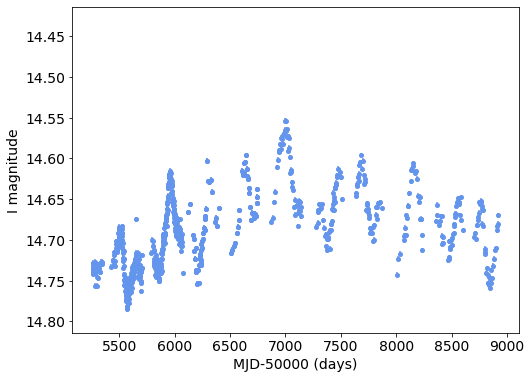

In [251]:
#Ogle IV
plt.figure(figsize=(8,6))
plt.errorbar(og4['MJD']-50000,og4['I mag'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
#flipped y axis since showing magnitudes
plt.ylim(14.8+.014,14.4+.014)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)
plt.savefig('Imag.ps') #testing saving plot as ps

# 2. Detrend Data and Perform LS Periodogram

In [252]:
#detrending by Georgios

# Detrend with window size, window size refers to number of points,
# so 100  points its about 100-200 days (OGLE takes 1 observation every 1-3 days)
# a more efficient way to detrend perhaps is to remove the average of each year, be carefull when detrending... 
# if you detrend using a window of 30 days .. and then you find a period of 30 days... 
# then you introduced an artificial signal.

Imag=og4['I mag']
window=201 #also tested other windows to make sure periodogram results unaffected
print('Smooth (window = ', window, ') and detrend data...')
Ismooth = signal.savgol_filter(Imag, window, 1)
Imean = np.mean(Imag)
print('Average I band magnitude', Imean)
og4['I detrend 2'] = Imag-Ismooth  + og4['I mag'].mean()

print('min:',og4['I detrend 2'].min(),'max:',og4['I detrend 2'].max())

# # clip large deviations
# mask = (Idetrend > -0.03) & (Idetrend < 0.03)
# Idetrend = Idetrend+Imean
# time = time[mask]
# Idetrend = Idetrend[mask]
# eIdetrend = Imag_err[mask]
# print 'No of selected data points:', len(time)


Smooth (window =  201 ) and detrend data...
Average I band magnitude 14.691636897767347
min: 14.59130853955839 max: 14.780144360453912


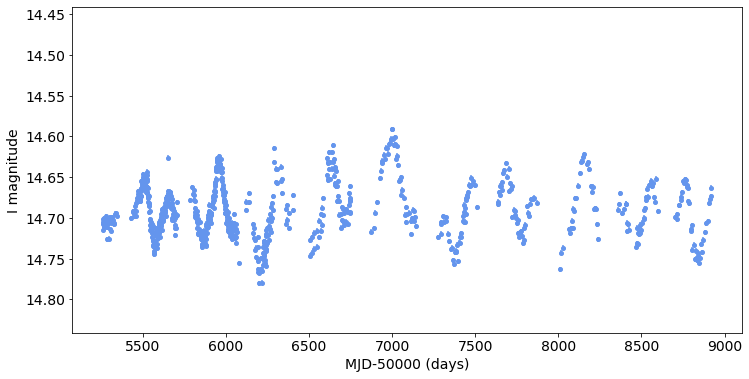

In [253]:
#detrended lightcurve
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
#flipped y axis since showing magnitudes
plt.ylim(14.8+.041,14.4+.041)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)

In [254]:
#find link for credit
def periodogram(more=False,minf=.005,maxf=.05,t=og4['MJD-50000'],y=og4['I detrend 2'],dy=og4['I mag err'],bayes=False,sub=False):
    '''Perform and plot single LS periodogram.
    Two different return options.'''
    fig = plt.figure(figsize=(8, 4))

    ls = LombScargle(t, y)
    freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=minf,
                           maximum_frequency=maxf,
                           samples_per_peak=10)
    if bayes: power = np.exp(power)
    plt.plot(1/freq,power,color='black')
    best_freq = freq[np.argmax(power)]
    plt.xlabel('Period',fontsize=14)
    plt.ylabel('Power',fontsize=14)
    if more:
        return freq, power, 1/best_freq
    else:
        return 1/best_freq

In [255]:
def pdsub(st,end,minf=.005,maxf=.05,t=og4['MJD-50000'],y=og4['I detrend 2'],dy=og4['I mag err'],sub=False,figsize=(20,5)):
    '''Subplots of periodograms based on lists of indices of data.'''
    fig,ax = plt.subplots(1,len(st),figsize=figsize)
    best_pds = []
    for s in range(len(st)):
        ls = LombScargle(t[st[s]:end[s]], y[st[s]:end[s]])
        freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=minf,
                           maximum_frequency=maxf,
                           samples_per_peak=50) #originally 10
        ax[s].plot(1/freq,power,color='black')
        best_freq = freq[np.argmax(power)]
        best_pds.append(1/best_freq)
        ax[s].tick_params(labelsize=14)
    ax[0].set_xlabel('Period (days)',fontsize=18)
    ax[0].set_ylabel('Power',fontsize=18)
    
    plt.subplots_adjust(wspace=.12)    
    return best_pds

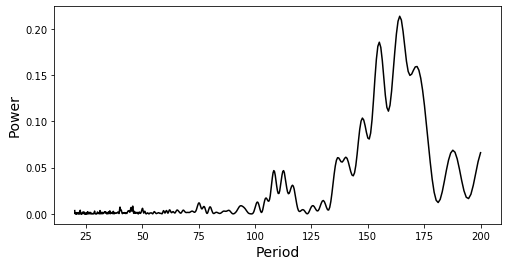

In [256]:
freq, power, best_p = periodogram(minf=.005,more=True)

248.81855254052064

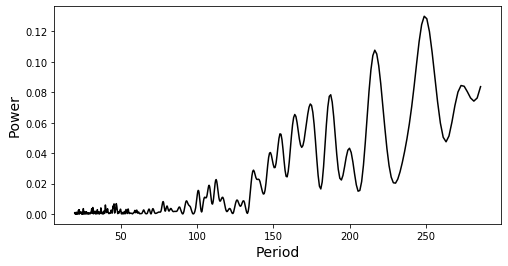

In [257]:
#periodogram with all data without detrending
periodogram(y=og4['I mag'],minf=.0035)

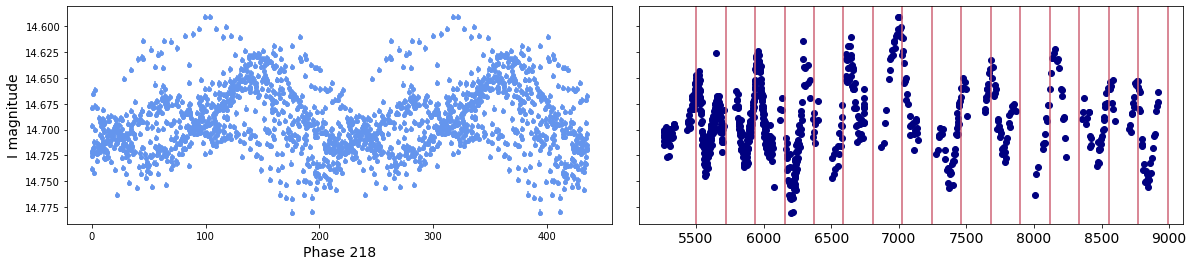

In [258]:
#showing that 218 days is not a meaningful signal, at least for us
fig,ax=plt.subplots(1,2,figsize=(20,4),sharey=True)
ax[0].errorbar(og4['MJD']%218,og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
ax[0].errorbar(218+og4['MJD']%218,og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)

#flipped y axis since showing magnitudes
ax[0].set_ylim(14.75+.041,14.54+.041)
ax[0].set_xlabel('Phase 218',fontsize=14)
ax[0].set_ylabel('I magnitude',fontsize=14)

ax[1].scatter(og4['MJD-50000'],og4['I detrend 2'],color='navy')
for i in range(17):
    plt.axvline(5501+218*i,color=c4)
plt.tick_params(labelsize=14)
plt.subplots_adjust(wspace=.05)

In [259]:
og4['phase 164'] = og4['MJD-50000'] % best_p

Text(0, 0.5, 'I magnitude')

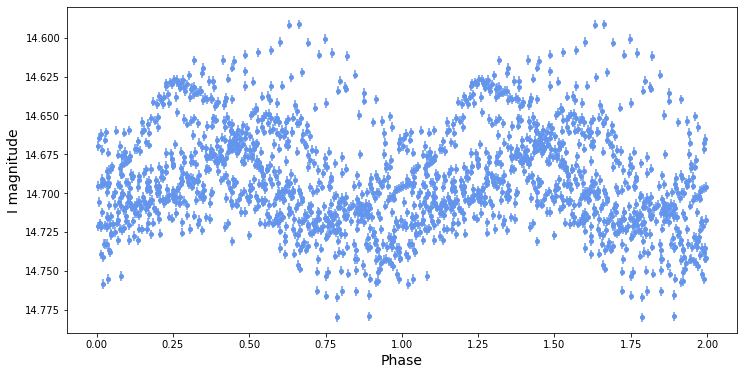

In [260]:
#version up to phase two
plt.figure(figsize=(12,6))
plt.errorbar(og4['phase 164']/best_p,og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
plt.errorbar(1+og4['phase 164']/best_p,og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
plt.ylim(14.75+.04,14.54+.04)
#flipped y axis since showing magnitudes
plt.xlabel('Phase',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
#plt.tick_params(labelsize=14)

## 3.  Test Period of 164 Days
starting from peak of whole lightcurve (peak of flare around 7000)

In [261]:
#time overall minimum (brightest point) from central flare
t = og4['MJD-50000']
maxt = t[np.argmin(og4['I detrend 2'])]
maxt

7002.222860000096

Text(0, 0.5, 'I magnitude')

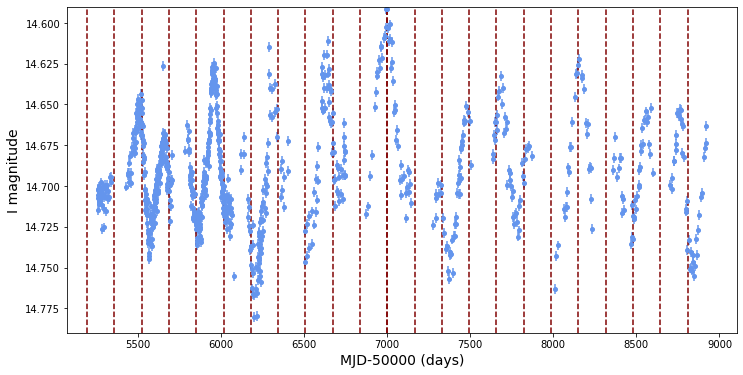

In [262]:
#detrended curve with lines spaced by 164d, measured from middle flare
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
#flipped y axis since showing magnitudes
for i in range(0,12):
    plt.axvline(maxt+i*best_p,0,1,linestyle='dashed',color=c5)
for i in range(0,12):
    plt.axvline(maxt-i*best_p,0,1,linestyle='dashed',color=c5)
plt.ylim(14.75+.04,14.55+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
#plt.tick_params(labelsize=14)
#plt.savefig('164wrong.png',dpi=200,bbox_inches='tight')

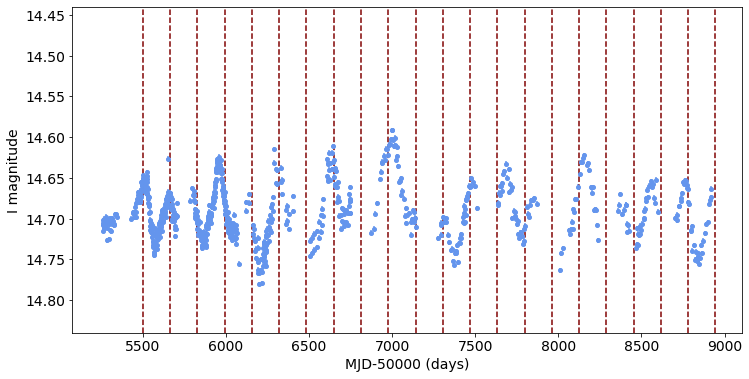

In [263]:
#Ogle IV
#measured from first flare (center found below using Gaussian fit)
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
#flipped y axis since showing magnitudes
for i in range(0,22):
    plt.axvline(5501+i*164,0,1,linestyle='dashed',color='maroon')
plt.ylim(14.8+.04,14.4+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)
plt.savefig('164wrong.png',dpi=200,bbox_inches='tight')

> In both cases, we see that 164 is too high of a period in the beginning and too low at the end. No single period value will predict the flares well.

# 4. To Confirm: Look at Other Periodogram Local Maxima

In [264]:
f = freq
lsoutput = np.c_[power, f, 1./f] #from LS periodogram
lsframe = pd.DataFrame(lsoutput, columns=['Power', 'Frequency', 'Period'])
# now sort the whole dataframe by the “Power” column and display the head of the table (first five rows):
lsframe.sort_values(by='Power', ascending=False)[:10]

Power  Frequency      Period
40  0.213587   0.006093  164.133090
39  0.209546   0.006065  164.872272
41  0.208223   0.006120  163.400506
38  0.197390   0.006038  165.618143
42  0.194513   0.006147  162.674433
53  0.185547   0.006448  155.093654
54  0.181080   0.006475  154.439379
37  0.180867   0.006011  166.370792
52  0.179915   0.006420  155.753495
43  0.175018   0.006175  161.954783

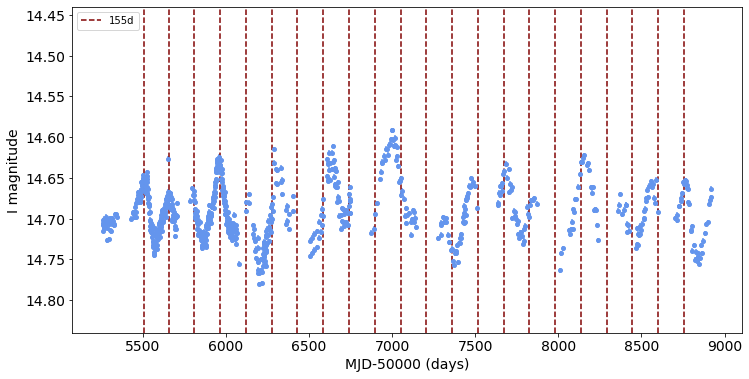

In [265]:
#try 155 days
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
#flipped y axis since showing magnitudes
for i in range(1,22):
    plt.axvline(5501+i*155,0,1,linestyle='dashed',color=c5)
plt.axvline(5510,0,1,linestyle='dashed',color=c5,label='155d')
plt.ylim(14.8+.04,14.4+.04)
plt.legend()
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)

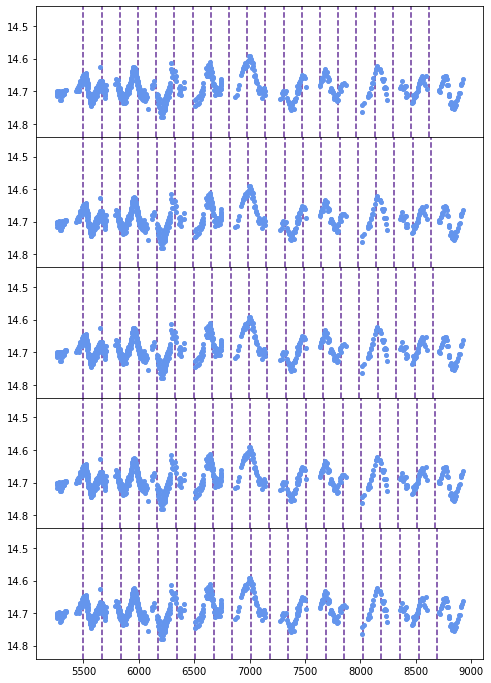

In [266]:
#can try multiple periods here
fig,ax=plt.subplots(5,1,figsize=(8,12),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
ax[0].errorbar(og4['MJD-50000'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
for i in range(20):
    ax[0].axvline(5501+i*best_p,0,1,linestyle='dashed',color=c3)
plt.ylim(14.8+.04,14.4+.04)
ax[1].errorbar(og4['MJD-50000'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
for i in range(20):
    ax[1].axvline(5501+i*165,0,1,linestyle='dashed',color=c3)
ax[2].errorbar(og4['MJD-50000'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
for i in range(20):
    ax[2].axvline(5501+i*166,0,1,linestyle='dashed',color=c3)
ax[3].errorbar(og4['MJD-50000'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
for i in range(20):
    ax[3].axvline(5501+i*167,0,1,linestyle='dashed',color=c3)
ax[4].errorbar(og4['MJD-50000'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
for i in range(20):
    ax[4].axvline(5501+i*168,0,1,linestyle='dashed',color=c3)

> periods around 164 can work decently well for many flares, but they are not trustworthy if the goal is prediction, especially considering that their effectiveness completely falls apart in recent years.

# 5. Identify Each Peak

In [267]:
og4[170:190]

JD   I mag  I mag err          MJD   MJD-50000  I detrend 2  \
170  2.455614e+06  14.743      0.003  55613.17037  5613.17037    14.700234   
171  2.455615e+06  14.739      0.003  55614.16272  5614.16272    14.696020   
172  2.455616e+06  14.733      0.003  55615.15611  5615.15611    14.689756   
173  2.455617e+06  14.734      0.003  55616.17214  5616.17214    14.690493   
174  2.455620e+06  14.759      0.003  55619.15402  5619.15402    14.715323   
175  2.455623e+06  14.748      0.003  55622.15556  5622.15556    14.704075   
176  2.455624e+06  14.747      0.003  55623.11492  5623.11492    14.702861   
177  2.455625e+06  14.741      0.003  55624.05615  5624.05615    14.696577   
178  2.455626e+06  14.747      0.003  55625.14764  5625.14764    14.702338   
179  2.455627e+06  14.739      0.003  55626.10871  5626.10871    14.694090   
180  2.455628e+06  14.732      0.003  55627.07352  5627.07352    14.686826   
181  2.455630e+06  14.735      0.003  55629.11369  5629.11369    14.689552   
182  2.455631e+06  14.740      0.003  55630.12510  5630.12510    14.694249   
183  2.455633e+06  14.737      0.003  55632.07329  5632.07329    14.690975   
184  2.455634e+06  14.739      0.003  55633.12219  5633.12219    14.692791   
185  2.455635e+06  14.728      0.003  55634.08269  5634.08269    14.681587   
186  2.455636e+06  14.739      0.003  55635.08696  5635.08696    14.692413   
187  2.455639e+06  14.745      0.003  55638.09156  5638.09156    14.698309   
188  2.455640e+06  14.732      0.003  55639.10181  5639.10181    14.685199   
189  2.455641e+06  14.731      0.003  55640.04075  5640.04075    14.684025   

     phase 164  
170  32.645307  
171  33.637657  
172  34.631047  
173  35.647077  
174  38.628957  
175  41.630497  
176  42.589857  
177  43.531087  
178  44.622577  
179  45.583647  
180  46.548457  
181  48.588627  
182  49.600037  
183  51.548227  
184  52.597127  
185  53.557627  
186  54.561897  
187  57.566497  
188  58.576747  
189  59.515687

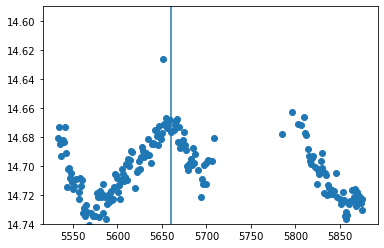

In [268]:
#plt.figure(figsize=(10,6))
plt.scatter(og4['MJD-50000'][100:300],og4['I detrend 2'][100:300])
plt.ylim(14.7+.04,14.55+.04)
plt.axvline(5660,0,1) #by-eye center determination

### Quickly Getting a Sense of Period in Different Regions
then return to identifying maxima

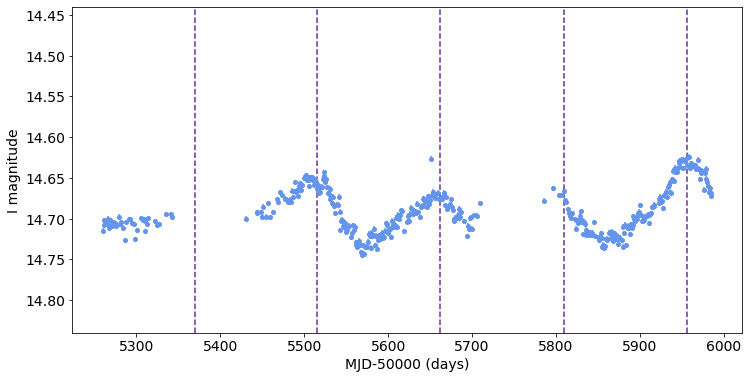

In [269]:
#low period best at beginning of dataset
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'][:400],og4['I detrend 2'][:400],yerr=og4['I mag err'][:400],marker='o',markersize=4,linestyle='None',color=c1)

for i in range(4):
    plt.axvline(5515.2+i*147,0,1,linestyle='dashed',color=c3)
plt.axvline(5515.2-145,0,1,linestyle='dashed',color=c3)
#for i in range(20):
    #plt.axvline(5651+i*166,0,1,linestyle='-.',color='rebeccapurple')
plt.ylim(14.8+.04,14.4+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)

Text(0, 0.5, 'I magnitude')

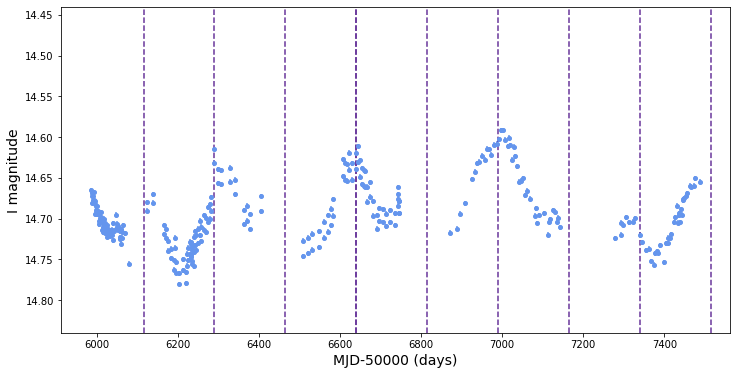

In [270]:
#different start place from above
#higher period needed here
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'][400:700],og4['I detrend 2'][400:700],yerr=og4['I mag err'][400:700],marker='o',markersize=4,linestyle='None',color=c1)

for i in range(6):
    plt.axvline(6640+i*175,0,1,linestyle='dashed',color=c3)
for i in range(4):
    plt.axvline(6640-i*175,0,1,linestyle='dashed',color=c3)
#plt.axvline(5515.2-145,0,1,linestyle='dashed',color=c3)
#for i in range(20):
    #plt.axvline(5651+i*166,0,1,linestyle='-.',color='rebeccapurple')
plt.ylim(14.8+.04,14.4+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
#plt.tick_params(labelsize=14)

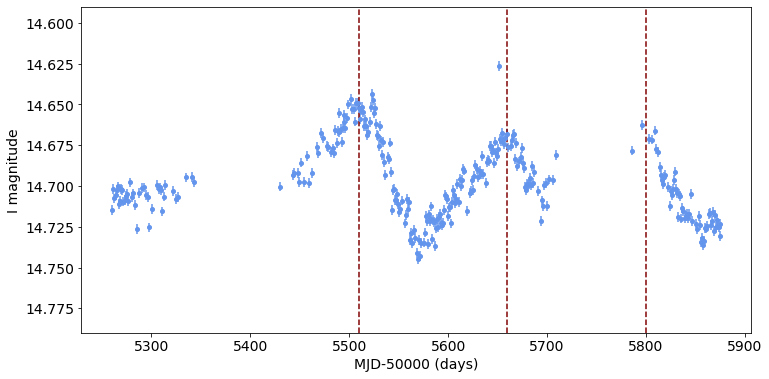

In [271]:
#zooming to estimate centers
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'][:300],og4['I detrend 2'][:300],yerr=og4['I mag err'][:300],marker='o',markersize=4,linestyle='None',color=c1)

plt.axvline(5510,0,1,linestyle='dashed',color=c5)
plt.axvline(5660,0,1,linestyle='dashed',color=c5)
plt.axvline(5800,0,1,linestyle='dashed',color=c5)

plt.ylim(14.75+.04,14.55+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)

In [272]:
flaremid=[5510,5660,5800] #middles of flares in MJD-50000

figure out other bounds using table

In [273]:
og4[50:200]

JD   I mag  I mag err          MJD   MJD-50000  I detrend 2  \
50   2.455468e+06  14.710      0.003  55467.35635  5467.35635    14.675930   
51   2.455469e+06  14.714      0.003  55468.34528  5468.34528    14.679790   
52   2.455472e+06  14.702      0.003  55471.36797  5471.36797    14.667650   
53   2.455474e+06  14.705      0.003  55473.30282  5473.30282    14.670510   
54   2.455478e+06  14.710      0.003  55477.30483  5477.30483    14.675371   
..            ...     ...        ...          ...         ...          ...   
195  2.455647e+06  14.734      0.003  55646.02887  5646.02887    14.685856   
196  2.455648e+06  14.721      0.003  55647.03084  5647.03084    14.672741   
197  2.455649e+06  14.728      0.003  55648.03150  5648.03150    14.679627   
198  2.455650e+06  14.730      0.003  55649.04625  5649.04625    14.681517   
199  2.455651e+06  14.726      0.003  55650.02670  5650.02670    14.677388   

     phase 164  
50   50.964377  
51   51.953307  
52   54.975997  
53   56.910847  
54   60.912857  
..         ...  
195  65.503807  
196  66.505777  
197  67.506437  
198  68.521187  
199  69.501637  

[150 rows x 7 columns]

Text(0, 0.5, 'I magnitude')

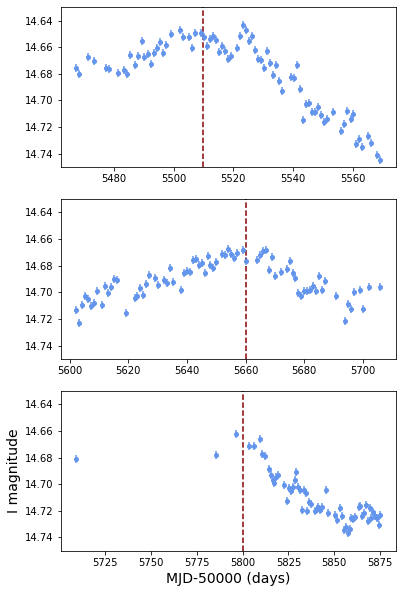

In [274]:
fig,ax=plt.subplots(3,1,sharey=True,figsize=(6,10))

ax[0].errorbar(og4['MJD-50000'][50:130],og4['I detrend 2'][50:130],yerr=og4['I mag err'][50:130],marker='o',markersize=4,linestyle='None',color=c1)
ax[0].axvline(5510,0,1,linestyle='dashed',color='maroon')

ax[1].errorbar(og4['MJD-50000'][160:240],og4['I detrend 2'][160:240],yerr=og4['I mag err'][160:240],marker='o',markersize=4,linestyle='None',color=c1)

ax[1].axvline(5660,0,1,linestyle='dashed',color='maroon')
ax[2].axvline(5800,0,1,linestyle='dashed',color='maroon')
ax[2].errorbar(og4['MJD-50000'][240:300],og4['I detrend 2'][240:300],yerr=og4['I mag err'][240:300],marker='o',markersize=4,linestyle='None',color=c1)

plt.ylim(14.71+.04,14.59+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
#plt.tick_params(labelsize=14)
#plt.title('First Flare')
#plt.savefig('maximaex.png',dpi=300,bbox_inches='tight')

In [275]:
flareinds = [[50,130],[160,240],[240,300]] #starting list of approx start and ends of flares

Text(0, 0.5, 'I magnitude')

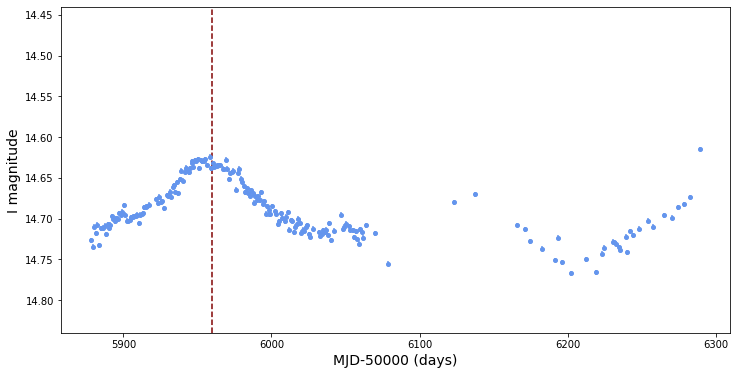

In [276]:
#not going to define other flares within these indices for now; look at predictions for those
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'][300:500],og4['I detrend 2'][300:500],yerr=og4['I mag err'][300:500],marker='o',markersize=4,linestyle='None',color=c1)


plt.axvline(5960,0,1,linestyle='dashed',color='maroon')
plt.ylim(14.8+.04,14.4+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
#plt.tick_params(labelsize=14)

Text(0, 0.5, 'I magnitude')

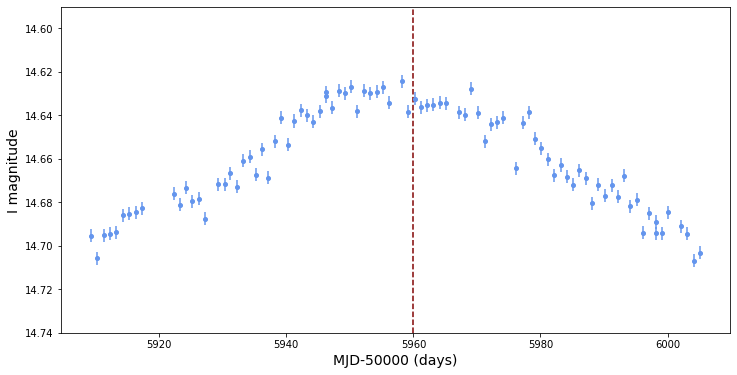

In [277]:
#not going to define other flares within these indices for now; look at predictions for those
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'][330:420],og4['I detrend 2'][330:420],yerr=og4['I mag err'][330:420],marker='o',markersize=4,linestyle='None',color=c1)


plt.axvline(5960,0,1,linestyle='dashed',color='maroon')
plt.ylim(14.7+.04,14.55+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
#plt.tick_params(labelsize=14)

In [278]:
flaremid.append(5960)
flareinds.append([330,420])

In [279]:
flareinds

[[50, 130], [160, 240], [240, 300], [330, 420]]

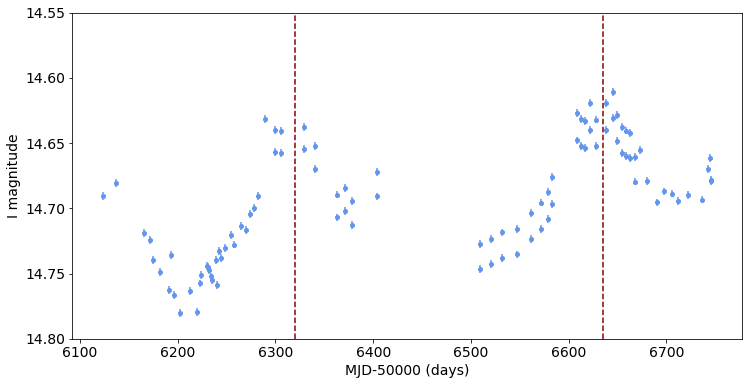

In [280]:
#not going to define other flares within these indices for now; look at predictions for those
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'][500:600],og4['I detrend 2'][500:600],yerr=og4['I mag err'][500:600],marker='o',markersize=4,linestyle='None',color=c1)

plt.axvline(6320,0,1,linestyle='dashed',color=c5)
plt.axvline(6635,0,1,linestyle='dashed',color=c5)

plt.ylim(14.8,14.55)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)

In [281]:
flaremid.append(6320)
flaremid.append(6635)

Text(0, 0.5, 'I magnitude')

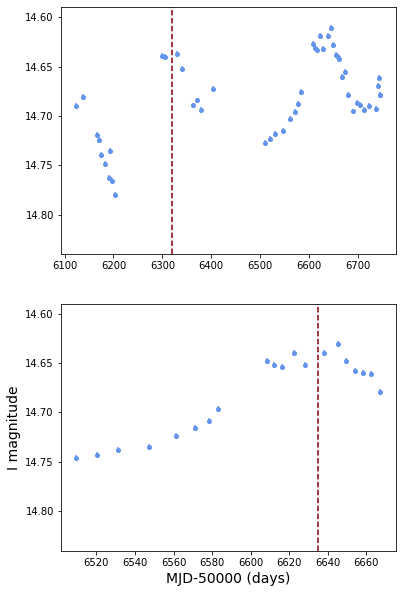

In [282]:
#find start and end indices of each flare between 500 and 700
fig,ax=plt.subplots(2,1,sharey=True,figsize=(6,10))

ax[0].errorbar(og4['MJD-50000'][500:550],og4['I detrend 2'][500:550],yerr=og4['I mag err'][500:550],marker='o',markersize=4,linestyle='None',color=c1)
ax[0].axvline(6320,0,1,linestyle='dashed',color='maroon')

ax[1].errorbar(og4['MJD-50000'][580:600],og4['I detrend 2'][580:600],yerr=og4['I mag err'][580:600],marker='o',markersize=4,linestyle='None',color=c1)

ax[1].axvline(6635,0,1,linestyle='dashed',color='maroon')

plt.ylim(14.8+.04,14.55+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)

## table not in time order -- not all the same points there when indexing
from here, use sog4 (sorted og)

In [283]:
#sorted og4
sog4 = og4.sort_values(by='MJD-50000')

Text(0, 0.5, 'I magnitude')

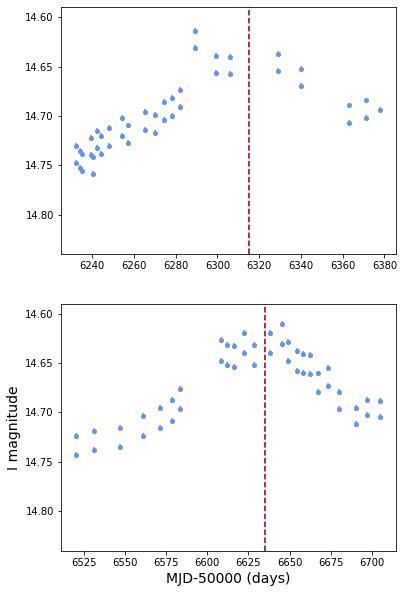

In [284]:
#find start and end indices of each flare between 500 and 700
fig,ax=plt.subplots(2,1,sharey=True,figsize=(6,10))

ax[0].errorbar(sog4['MJD-50000'][500:545],sog4['I detrend 2'][500:545],yerr=sog4['I mag err'][500:545],marker='o',markersize=4,linestyle='None',color=c1)
ax[0].axvline(6315,0,1,linestyle='dashed',color='maroon')

ax[1].errorbar(sog4['MJD-50000'][550:598],sog4['I detrend 2'][550:598],yerr=sog4['I mag err'][550:598],marker='o',markersize=4,linestyle='None',color=c1)

ax[1].axvline(6635,0,1,linestyle='dashed',color='maroon')

plt.ylim(14.8+.04,14.55+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)

In [285]:
flaremid=[5510, 5660, 5800, 5960, 6315, 6635]

In [286]:
flareinds.append([500,545])
flareinds.append([550,598])

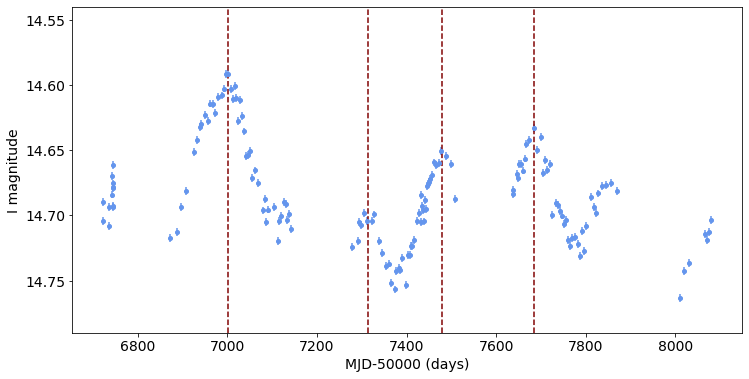

In [287]:
plt.figure(figsize=(12,6))
plt.errorbar(sog4['MJD-50000'][600:750],sog4['I detrend 2'][600:750],yerr=sog4['I mag err'][600:750],marker='o',markersize=4,linestyle='None',color=c1)


plt.axvline(7002,0,1,linestyle='dashed',color='maroon')
plt.axvline(7315,0,1,linestyle='dashed',color='maroon')
plt.axvline(7480,0,1,linestyle='dashed',color='maroon')
plt.axvline(7685,0,1,linestyle='dashed',color='maroon')

#plt.axvline(6635,0,1,linestyle='dashed',color='maroon')

plt.ylim(14.75+.04,14.5+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)

(14.79, 14.54)

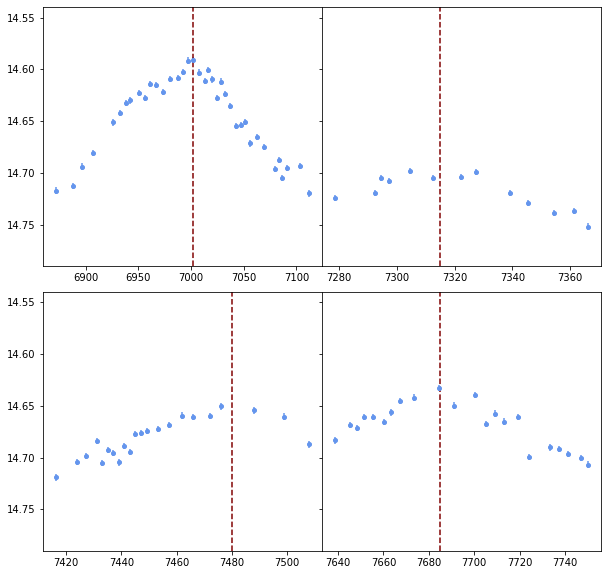

In [288]:
fig,ax=plt.subplots(2,2,sharey=True,figsize=(10,10))
plt.subplots_adjust(wspace=0, hspace=0.1)
ax[0][0].errorbar(sog4['MJD-50000'][612:650],sog4['I detrend 2'][612:650],yerr=sog4['I mag err'][612:650],marker='o',markersize=4,linestyle='None',color=c1)
ax[0][0].axvline(7002,0,1,linestyle='dashed',color=c5)

ax[0][1].errorbar(sog4['MJD-50000'][657:670],sog4['I detrend 2'][657:670],yerr=sog4['I mag err'][657:670],marker='o',markersize=4,linestyle='None',color=c1)
ax[0][1].axvline(7315,0,1,linestyle='dashed',color=c5)

ax[1][0].errorbar(sog4['MJD-50000'][680:702],sog4['I detrend 2'][680:702],yerr=sog4['I mag err'][680:702],marker='o',markersize=4,linestyle='None',color=c1)
ax[1][0].axvline(7480,0,1,linestyle='dashed',color=c5)
#ax[1].axvline(6635,0,1,linestyle='dashed',color='maroon')
ax[1][1].errorbar(sog4['MJD-50000'][703:725],sog4['I detrend 2'][703:725],yerr=sog4['I mag err'][703:725],marker='o',markersize=4,linestyle='None',color=c1)
ax[1][1].axvline(7685,0,1,linestyle='dashed',color=c5)
plt.ylim(14.75+.04,14.5+.04)
#plt.xlabel('MJD-50000 (days)',fontsize=14)
#plt.ylabel('I magnitude',fontsize=14)



In [289]:
flareinds

[[50, 130], [160, 240], [240, 300], [330, 420], [500, 545], [550, 598]]

In [290]:
flareinds.append([612,650])
flareinds.append([657,670])
flareinds.append([680,702])
flareinds.append([703,725])
flaremid.append(7002)
flaremid.append(7315)
flaremid.append(7480)
flaremid.append(7685)

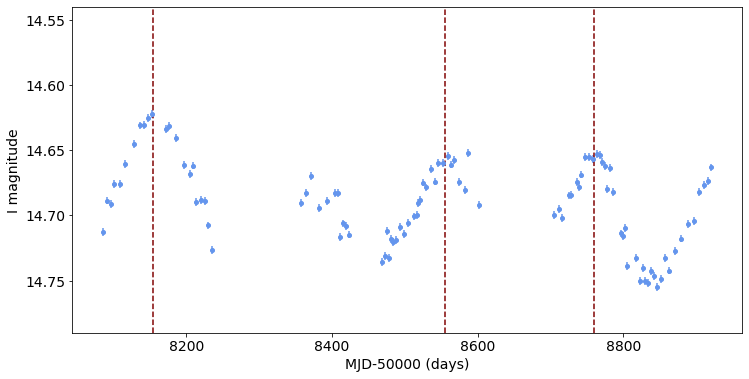

In [291]:
plt.figure(figsize=(12,6))
plt.errorbar(sog4['MJD-50000'][750:],sog4['I detrend 2'][750:],yerr=sog4['I mag err'][750:],marker='o',markersize=4,linestyle='None',color=c1)


plt.axvline(8155,0,1,linestyle='dashed',color=c5)
plt.axvline(8555,0,1,linestyle='dashed',color=c5)
plt.axvline(8760,0,1,linestyle='dashed',color=c5)
#plt.axvline(7685,0,1,linestyle='dashed',color='maroon')

#plt.axvline(6635,0,1,linestyle='dashed',color='maroon')

plt.ylim(14.75+.04,14.5+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)

(14.739999999999998, 14.59)

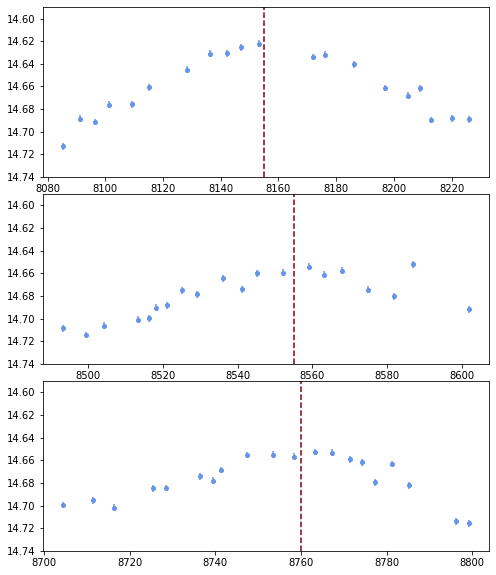

In [292]:
fig,ax=plt.subplots(3,1,sharey=True,figsize=(8,10))
plt.subplots_adjust(wspace=0, hspace=0.1)
ax[0].errorbar(sog4['MJD-50000'][750:770],sog4['I detrend 2'][750:770],yerr=sog4['I mag err'][750:770],marker='o',markersize=4,linestyle='None',color=c1)
ax[0].axvline(8155,0,1,linestyle='dashed',color='maroon')

ax[1].errorbar(sog4['MJD-50000'][790:810],sog4['I detrend 2'][790:810],yerr=sog4['I mag err'][790:810],marker='o',markersize=4,linestyle='None',color=c1)
ax[1].axvline(8555,0,1,linestyle='dashed',color='maroon')

ax[2].errorbar(sog4['MJD-50000'][810:830],sog4['I detrend 2'][810:830],yerr=sog4['I mag err'][810:830],marker='o',markersize=4,linestyle='None',color=c1)
ax[2].axvline(8760,0,1,linestyle='dashed',color='maroon')
#ax[1].axvline(6635,0,1,linestyle='dashed',color='maroon')

plt.ylim(14.7+.04,14.55+.04)

In [293]:
flaremid.append(8155)
flaremid.append(8555)
flaremid.append(8760)

In [294]:
flareinds.append([750,770])
flareinds.append([790,810])
flareinds.append([810,830])

In [295]:
flareinds

[[50, 130],
 [160, 240],
 [240, 300],
 [330, 420],
 [500, 545],
 [550, 598],
 [612, 650],
 [657, 670],
 [680, 702],
 [703, 725],
 [750, 770],
 [790, 810],
 [810, 830]]

# 6. Investigating 13 Identified Flares 
> - so now we have the approximate middle of 13 flares and the start and end indices
- first: all in one plot

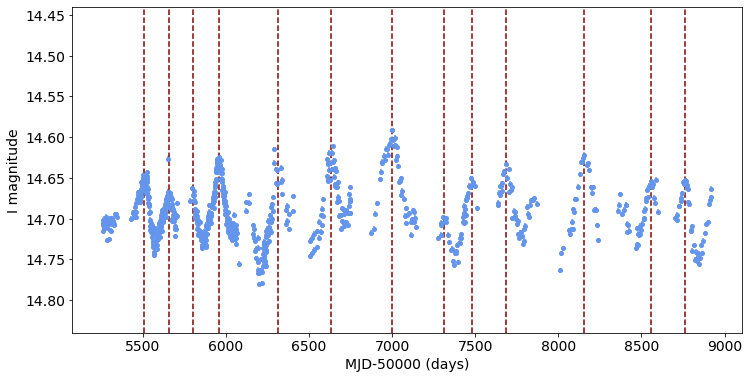

In [296]:
#Ogle IV
plt.figure(figsize=(12,6))
plt.errorbar(sog4['MJD-50000'],sog4['I detrend 2'],yerr=sog4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
for i in flaremid:
    plt.axvline(i,0,1,linestyle='dashed',color=c5)
plt.ylim(14.8+.04,14.4+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)
#plt.savefig('13flareloc.png',dpi=300,bbox_inches='tight')

# differences between consecutive flares

In [297]:
print(flaremid[1]-flaremid[0])
print(flaremid[2]-flaremid[1])
print(flaremid[3]-flaremid[2])
print(flaremid[8]-flaremid[7])
print(flaremid[-4]-flaremid[-5])
print(flaremid[-1]-flaremid[-2])

150
140
160
165
205
205


# 7. Different Epochs With Different Period?
figuring out where to split the data


In [298]:
#first attempt at splitting up the data

#first four known flares and then starting at fifth known flare
r1=sog4[:545]
r2=sog4[545:]

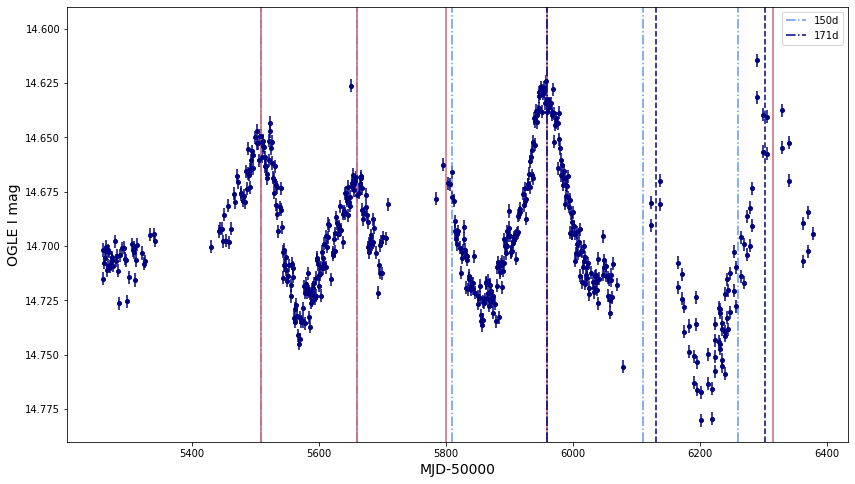

In [299]:
#shows transition from first period to second
plt.figure(figsize=(14,8))
plt.errorbar(r1['MJD-50000'],r1['I detrend 2'],yerr=r1['I mag err'],marker='o',markersize=4,linestyle='None',color=c2)
plt.ylim(14.75+.04,14.55+.04)
plt.axvline(5510,0,1,linestyle='-.',color='cornflowerblue',label='150d')
for i in range(1,6):
    plt.axvline(5510+150*i,0,1,linestyle='-.',color=c1)
for j in range(5):
    plt.axvline(flaremid[j],0,1,color=c4)
plt.axvline(5960,0,1,linestyle='-.',color='navy',label='171d')
for i in range(1,3):
    plt.axvline(5960+171*i,0,1,linestyle='dashed',color=c2)
plt.xlabel('MJD-50000',fontsize=14)
plt.ylabel('OGLE I mag',fontsize=14)
#plt.title('150 Day Period, Starting From 5510d; 171 Day Period From 5960')
plt.legend()
plt.savefig('150,171r1.png',dpi=300,bbox_inches='tight')

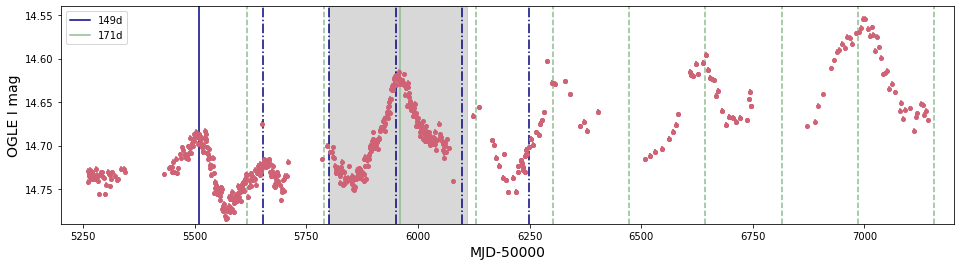

In [300]:
#plot for Overleaf; uses centers found with Gaussian (so update with final model and periods)
plt.figure(figsize=(16,4))
plt.errorbar(sog4['MJD-50000'],sog4['I mag'],yerr=sog4['I mag err'],marker='o',markersize=4,linestyle='None',color='#CF6275')
plt.ylim(14.75+.04,14.54)
plt.xlim(5200,7200)
plt.axvline(5510,0,1,linestyle='solid',color='navy',label='149d')
for i in range(1,6):
    plt.axvline(5503+149*i,0,1,linestyle='-.',color='navy')
#for j in range(5):
    #plt.axvline(flaremid[j],0,1,color=c4)
plt.axvline(5960,0,1,linestyle='solid',color='darkseagreen',label='171d')
for i in [-2,-1,1,2,3,4,5,6,7]:
    plt.axvline(5960+171*i,0,1,linestyle='dashed',color='darkseagreen')
plt.axvspan(5800,6110,color='grey',alpha=.3)
plt.xlabel('MJD-50000',fontsize=14)
plt.ylabel('OGLE I mag',fontsize=14)
#plt.title('150 Day Period, Starting From 5510d; 171 Day Period From 5960')
plt.legend()
png('firstch')

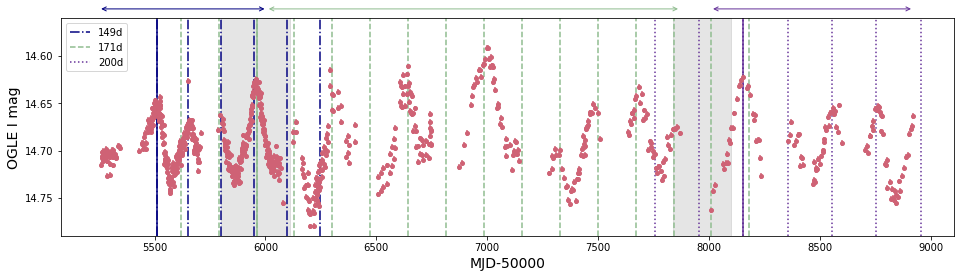

In [492]:
fg = plt.figure(1,figsize=(16,4));
fg.clf();
ax = fg.add_subplot(1,1,1)
ax.errorbar(sog4['MJD-50000'],sog4['I detrend 2'],yerr=sog4['I mag err'],marker='o',markersize=4,linestyle='None',color='#CF6275')
ax.set_ylim(14.75+.04,14.56)
ax.axvline(5510,0,1,linestyle='-.',color='navy',label='149d')
ax.axvline(5510,0,1,linestyle='solid',color='navy')
for i in range(1,6):
    ax.axvline(5503+149*i,0,1,linestyle='-.',color='navy')
ax.axvline(5960,0,1,linestyle='dashed',color='darkseagreen',label='171d')
ax.axvline(5960,0,1,linestyle='solid',color='darkseagreen')
for i in [-2,-1,1,2,3,4,5,6,7,8,9,10,11,12,13]:
    ax.axvline(5960+171*i,0,1,linestyle='dashed',color='darkseagreen')
ax.axvspan(5800,6110,color='grey',alpha=.2)
ax.axvspan(7840,8100,color='grey',alpha=.2)
ax.axvline(8155,0,1,linestyle='dotted',color='rebeccapurple',label='200d')
ax.axvline(8155,0,1,linestyle='solid',color='rebeccapurple')

for i in range(-2,5):
    ax.axvline(8155+200*i,0,1,linestyle='dotted',color='rebeccapurple')
ax.set_xlabel('MJD-50000',fontsize=14)
ax.set_ylabel('OGLE I mag',fontsize=14)
#plt.title('150 Day Period, Starting From 5510d; 171 Day Period From 5960')
ax.legend()
#ax.arrow(5260,14.55,6005-5260,0,clip_on=False,head_width=.01,head_length=.5)


ax.annotate('', xy=(5250, 14.55),xytext=(6005, 14.55), 
            arrowprops=dict(arrowstyle="<->", color='navy'),annotation_clip=False)
ax.annotate('', xy=(6006, 14.55),xytext=(7870, 14.55), 
            arrowprops=dict(arrowstyle="<->", color='darkseagreen'),annotation_clip=False)
ax.annotate('', xy=(8010, 14.55),xytext=(8921, 14.55), 
            arrowprops=dict(arrowstyle="<->", color='rebeccapurple'),annotation_clip=False)
fg.canvas.draw()
png('3epochs')

> we can see shift here from around 150 days being the best period to more like 170-175

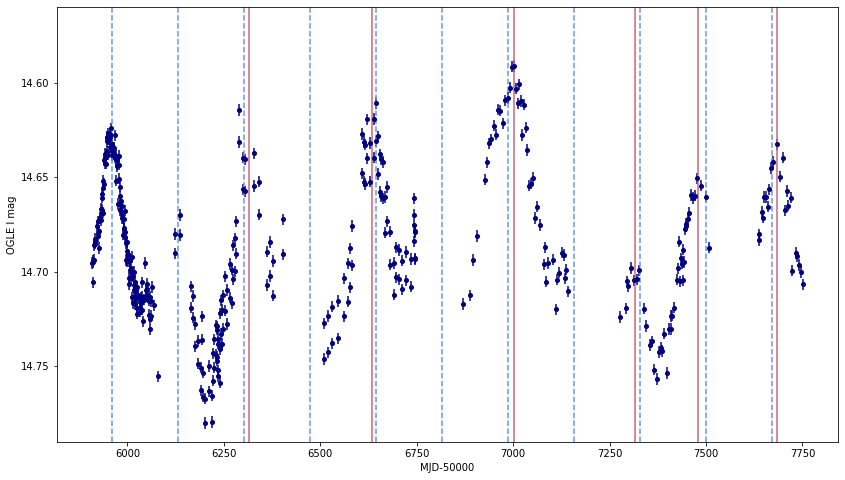

In [302]:
r5=sog4[330:725]
plt.figure(figsize=(14,8))
plt.errorbar(r5['MJD-50000'],r5['I detrend 2'],yerr=r5['I mag err'],marker='o',markersize=4,linestyle='None',color=c2)
plt.ylim(14.75+.04,14.52+.04)
for i in range(11):
    plt.axvline(5960+171*i,0,1,linestyle='dashed',color=c1)
#for i in range(1,3):
    #plt.axvline(7315+170*i,0,1,color='navy')
for j in range(4,10):
    plt.axvline(flaremid[j],0,1,color=c4)
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
#plt.title('171 Day Period, Starting From 5960d')
plt.savefig('171r5.png',dpi=300,bbox_inches='tight')

## error as a function of time for r5 (part with ~170 day period)

In [303]:
def errors(pd,st,end,inds):
    pred = np.arange(flaremid[st-1],flaremid[end]+5,pd)
    actual = flaremid[st:end]
    errs=[]
    for i in range(len(inds)):
        err = pred[inds[i]]-actual[i]
        errs.append(err)
    return errs, np.mean(np.abs(errs)) 

In [304]:
err70=errors(170,4,10,[2,4,6,8,9,10])
err71=errors(171,4,10,[2,4,6,8,9,10])
err72=errors(172,4,10,[2,4,6,8,9,10])
err73=errors(173,4,10,[2,4,6,8,9,10])
print('170:',err70)
print('171:',err71)
print('172:',err72)
print('173:',err73) #shows 171 is best period, but uncertainty

170: ([-15, 5, -22, 5, 10, -25], 13.666666666666666)
171: ([-13, 9, -16, 13, 19, -15], 14.166666666666666)
172: ([-11, 13, -10, 21, 28, -5], 14.666666666666666)
173: ([-9, 17, -4, 29, 37, 5], 16.833333333333332)


Text(0, 0.5, 'O-C')

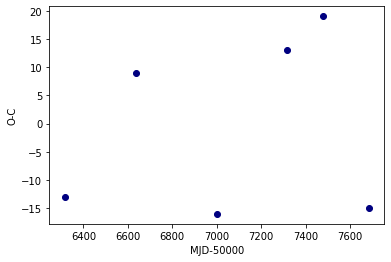

In [305]:
#O-C vs. time shows no trend apparent towards longer period
plt.scatter(flaremid[4:10],err71[0],color=c2)
plt.xlabel('MJD-50000')
plt.ylabel('O-C')

Text(0, 0.5, 'OGLE I mag')

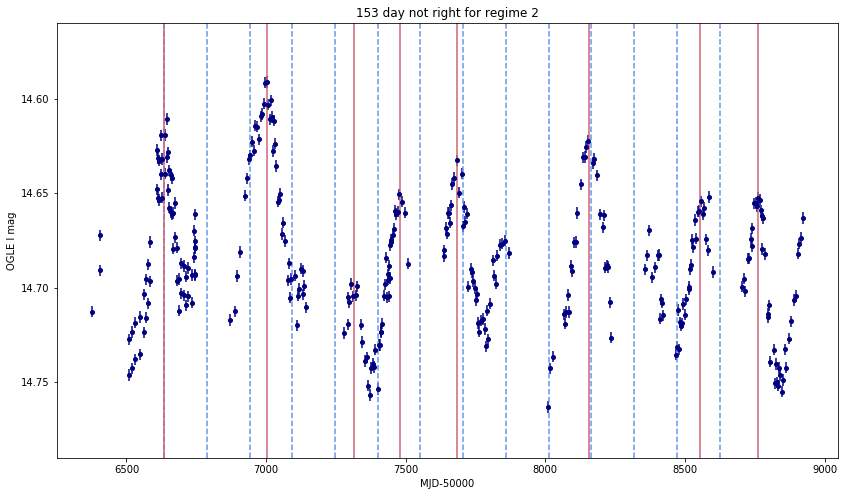

In [306]:
#showing first period ineffective in second epoch
plt.figure(figsize=(14,8))
plt.errorbar(r2['MJD-50000'],r2['I detrend 2'],yerr=r2['I mag err'],marker='o',markersize=4,linestyle='None',color=c2)
plt.ylim(14.75+.04,14.52+.04)
for i in range(14):
    plt.axvline(6635+153*i,0,1,color=c1,linestyle='dashed')
for j in range(5,len(flaremid)):
    plt.axvline(flaremid[j],0,1,color=c4)
plt.title('153 day not right for regime 2')
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
#plt.savefig('153wrongr2.png',dpi=300,bbox_inches='tight')


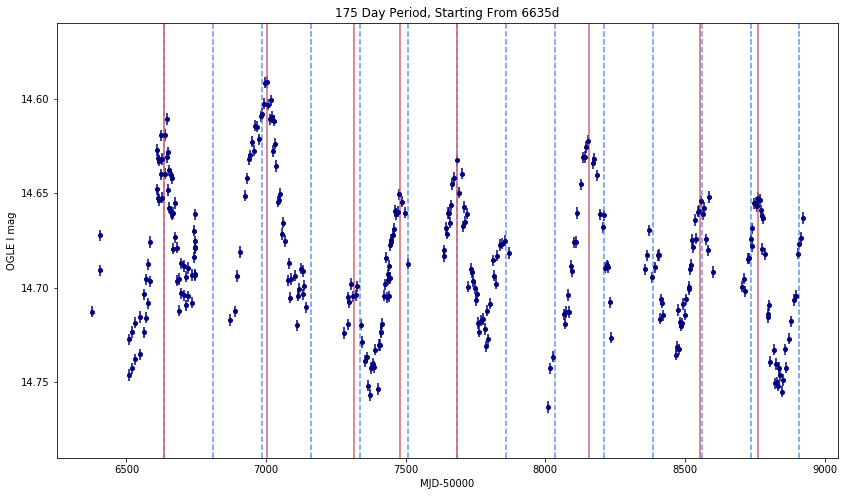

In [307]:
plt.figure(figsize=(14,8))
plt.errorbar(r2['MJD-50000'],r2['I detrend 2'],yerr=r2['I mag err'],marker='o',markersize=4,linestyle='None',color=c2)
plt.ylim(14.75+.04,14.52+.04)
for i in range(14):
    plt.axvline(6635+175*i,0,1,color=c1,linestyle='dashed')
for j in range(5,len(flaremid)):
    plt.axvline(flaremid[j],0,1,color=c4)
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
plt.title('175 Day Period, Starting From 6635d')
plt.savefig('175r2.png',dpi=300,bbox_inches='tight')

> break up into three parts

In [308]:
r3=sog4[550:725] #five known flares
r4=sog4[725:]

Text(0.5, 1.0, '171 Day Period, Starting From 6635d')

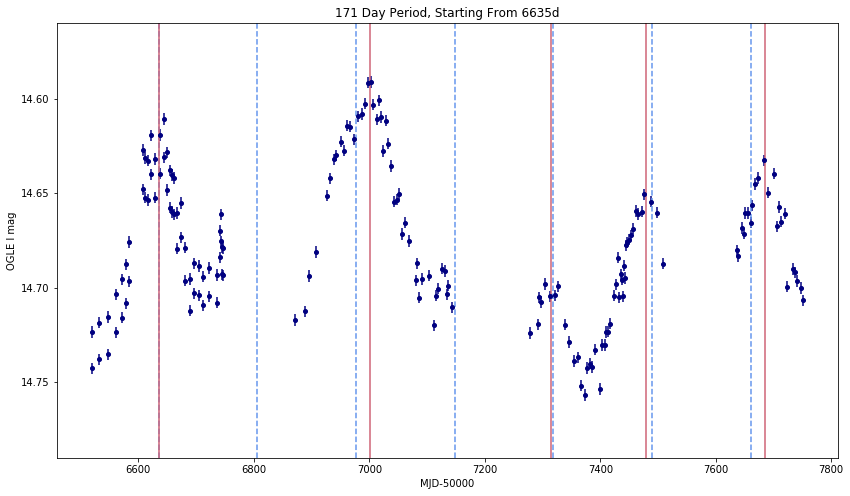

In [309]:
plt.figure(figsize=(14,8))
plt.errorbar(r3['MJD-50000'],r3['I detrend 2'],yerr=r3['I mag err'],marker='o',markersize=4,linestyle='None',color=c2)
plt.ylim(14.75+.04,14.52+.04)
for i in range(7):
    plt.axvline(6635+171*i,0,1,linestyle='dashed',color=c1)
#for i in range(1,3):
    #plt.axvline(7315+170*i,0,1,color='navy')
for j in range(5,10):
    plt.axvline(flaremid[j],0,1,color=c4)
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
plt.title('171 Day Period, Starting From 6635d')
#plt.savefig('171r3.png',dpi=300,bbox_inches='tight')
#add legend?

Text(0.5, 1.0, '201 Day Period, Starting From 8155d')

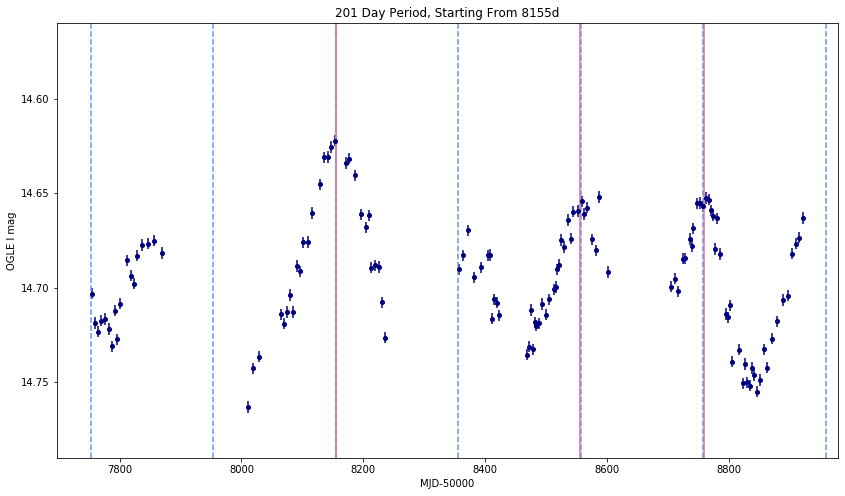

In [310]:
#longest period needed in most recent few flares
plt.figure(figsize=(14,8))
plt.errorbar(r4['MJD-50000'],r4['I detrend 2'],yerr=r4['I mag err'],marker='o',markersize=4,linestyle='None',color='navy')
plt.ylim(14.75+.04,14.52+.04)
for i in range(-2,5):
    plt.axvline(8155+201*i,0,1,linestyle='dashed',color='cornflowerblue')
#for i in range(1,3):
    #plt.axvline(7315+170*i,0,1,color='navy')
for j in range(10,len(flaremid)):
    plt.axvline(flaremid[j],0,1,color='palevioletred')
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
plt.title('201 Day Period, Starting From 8155d')
#plt.savefig('200r4.png',dpi=300,bbox_inches='tight')

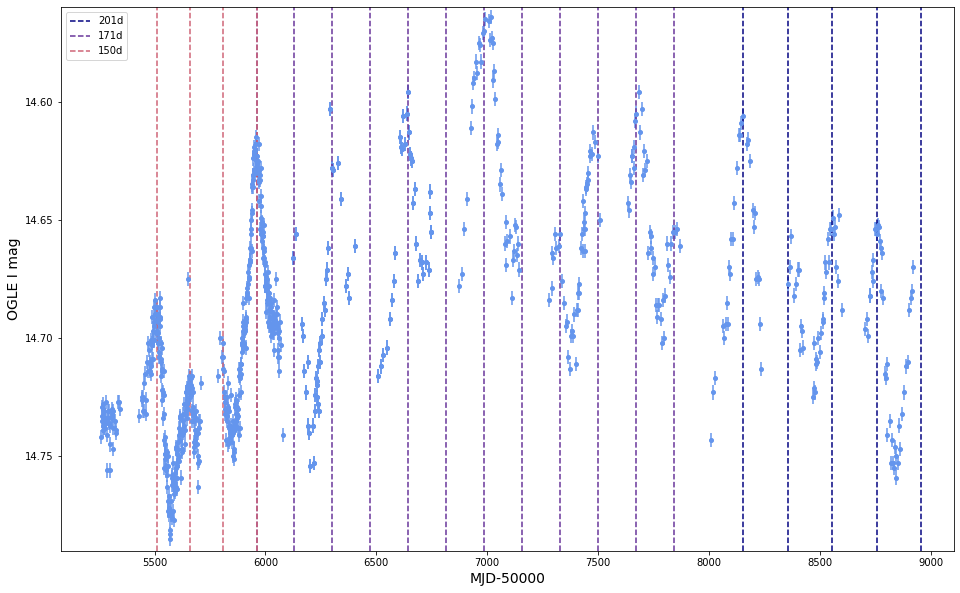

In [311]:
#putting it all together: full lightcurve with three different period values
plt.figure(figsize=(16,10))
plt.errorbar(sog4['MJD-50000'],sog4['I mag'],yerr=sog4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
plt.ylim(14.75+.04,14.52+.04)
plt.axvline(8155,0,1,linestyle='dashed',color=c2,label='201d')
for i in range(1,5):
    plt.axvline(8155+201*i,0,1,linestyle='dashed',color=c2)
plt.axvline(5960,0,1,linestyle='dashed',color=c3,label='171d')
for i in range(1,12):
    plt.axvline(5960+171*i,0,1,linestyle='dashed',color=c3)
plt.axvline(5510,0,1,linestyle='dashed',color=c4,label='150d')
for i in range(1,4):
    plt.axvline(5510+150*i,0,1,linestyle='dashed',color=c4)
#for i in range(len(flaremid)):
    #plt.axvline(flaremid[i],0,1,color=c3)

#for j in range(10,len(flaremid)):
    #plt.axvline(flaremid[j],0,1,color='palevioletred')
plt.xlabel('MJD-50000',fontsize=14)
plt.ylabel('OGLE I mag',fontsize=14)
plt.legend()
#plt.savefig('3pdsalldat2.png',dpi=300,bbox_inches='tight')

## 8. Examine Error of Each Epoch
> - make sure some kind of local minimum
- may not be that significant since error in center determinations
- used this for final determination in plot above
- see further down for chi-squared minimization using centers determined with gaussians

In [312]:
#first
print('149:',errors(149,1,4,[1,2,3]))
err150 = errors(150,1,4,[1,2,3])
print('150:',err150)
print('151:',errors(151,1,4,[1,2,3]))
print('148:',errors(148,1,4,[1,2,3]))
print('152:',errors(152,1,4,[1,2,3]))

149: ([-1, 8, -3], 4.0)
150: ([0, 10, 0], 3.3333333333333335)
151: ([1, 12, 3], 5.333333333333333)
148: ([-2, 6, -6], 4.666666666666667)
152: ([2, 14, 6], 7.333333333333333)


In [313]:
#second
print('170:',errors(170,4,10,[2,4,6,8,9,10]))
err171 = errors(171,4,10,[2,4,6,8,9,10])
print('171:',err171)
print('172:',errors(172,4,10,[2,4,6,8,9,10]))

170: ([-15, 5, -22, 5, 10, -25], 13.666666666666666)
171: ([-13, 9, -16, 13, 19, -15], 14.166666666666666)
172: ([-11, 13, -10, 21, 28, -5], 14.666666666666666)


In [314]:
prd=199
pred = np.arange(flaremid[10],flaremid[-1]+400,prd)
actual = flaremid[11:]
errs=[]
inds=[2,3]
for i in range(len(inds)):
    err = pred[inds[i]]-actual[i]
    errs.append(err)
print('199:',errs)
prd=200
pred = np.arange(flaremid[10],flaremid[-1]+400,prd)
actual = flaremid[11:]
errs=[]
inds=[2,3]
for i in range(len(inds)):
    err = pred[inds[i]]-actual[i]
    errs.append(err)
print('200:',errs)
prd=201
pred = np.arange(flaremid[10],flaremid[-1]+400,prd)
actual = flaremid[11:]
errs201=[]
inds=[2,3]
for i in range(len(inds)):
    err = pred[inds[i]]-actual[i]
    errs201.append(err)
print('201:',errs201)
prd=205
pred = np.arange(flaremid[10],flaremid[-1]+400,prd)
actual = flaremid[11:]
errs=[]
inds=[2,3]
for i in range(len(inds)):
    err = pred[inds[i]]-actual[i]
    errs.append(err)
print('205:',errs)

199: [-2, -8]
200: [0, -5]
201: [2, -2]
205: [10, 10]


> crucially, there's no clear linear pattern of error within any of these three regimes

# 9. Phase-Folding and Periodograms by Epoch


In [315]:
reg1=sog4[:420]
reg2=sog4[420:743]
reg3=sog4[743:]

In [316]:
reg3['MJD-50000'][-1:]

850    8921.08348
Name: MJD-50000, dtype: float64

[149.36959775342524, 171.57223282553693, 199.05709583291397]

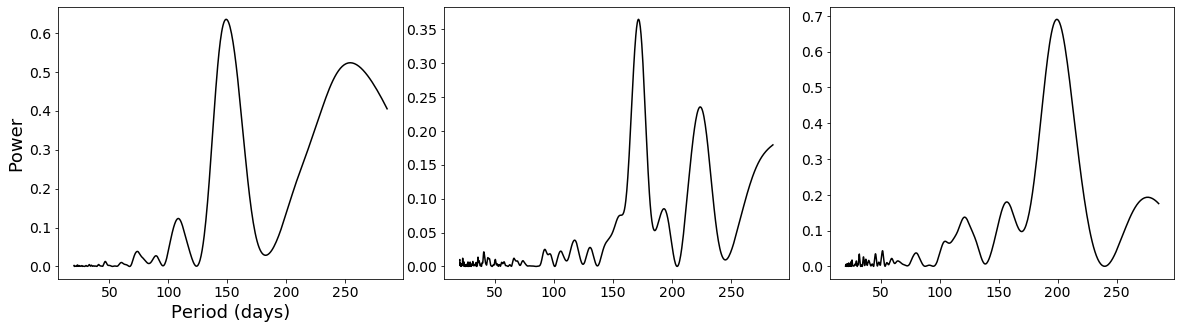

In [317]:
pdsub([0,420,743],[420,743,-1],minf=.0035)
#plt.savefig('3pdgram',dpi=200,bbox_inches='tight')

218.05063005834927


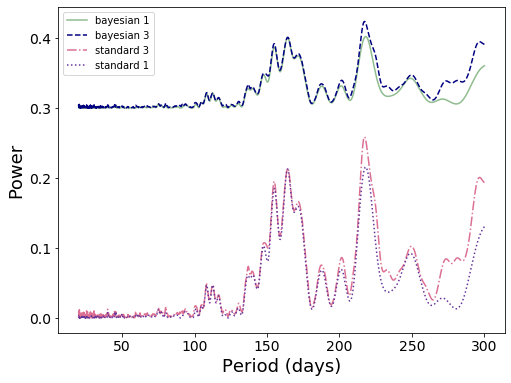

In [318]:
#right now: comparing bayesian 3 terms, bayesian 1 term, standard 3 and 1
plt.figure(figsize=(8,6))
colors = ['darkseagreen','navy','rebeccapurple','palevioletred']
#labs = ['total','first','second','third']
labs = ['bayesian 1','bayesian 3','standard 1','standard 3']
lins = ['solid','dashed','dotted','-.']
st = [0,0,420,743]
end = [-1,420,743,-1]
t = sog4['MJD-50000']
y = sog4['I detrend 2']
y2 = sog4['I mag']
#for s in range(len(st)):
    #if s == 0: 
ls = LombScargle(t[st[0]:end[0]], y[st[0]:end[0]])
    #else: ls = LombScargle(t[st[s]:end[s]], y2[st[s]:end[s]])
freq, power = ls.autopower(normalization='psd',
                           minimum_frequency=1/300,
                           maximum_frequency=.05,
                           samples_per_peak=50) #originally 10
power = np.exp(power)
plt.plot(1/freq,power-.7,color=colors[0],label=labs[0],linestyle=lins[0])

ls = LombScargle(t[st[0]:end[0]], y[st[0]:end[0]],nterms=3)
    #else: ls = LombScargle(t[st[s]:end[s]], y2[st[s]:end[s]])
freq, power = ls.autopower(normalization='psd',
                           minimum_frequency=1/300,
                           maximum_frequency=.05,
                           samples_per_peak=50) #originally 10
power = np.exp(power)
plt.plot(1/freq,power-.7,color=colors[1],label=labs[1],linestyle=lins[1])

ls = LombScargle(t[st[0]:end[0]], y[st[0]:end[0]],nterms=3)
    #else: ls = LombScargle(t[st[s]:end[s]], y2[st[s]:end[s]])
freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=1/300,
                           maximum_frequency=.05,
                           samples_per_peak=50) #originally 10
#power = np.exp(power)
plt.plot(1/freq,power,color=colors[3],label=labs[3],linestyle=lins[3])
ls = LombScargle(t[st[0]:end[0]], y[st[0]:end[0]])
    #else: ls = LombScargle(t[st[s]:end[s]], y2[st[s]:end[s]])
freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=1/300,
                           maximum_frequency=.05,
                           samples_per_peak=50) #originally 10
#power = np.exp(power)
plt.plot(1/freq,power,color=colors[2],label=labs[2],linestyle=lins[2])
best_freq = freq[np.argmax(power)]
print(1/best_freq)
#plt.axvline(1/best_freq,color=colors[0])
plt.tick_params(labelsize=14)
plt.xlabel('Period (days)',fontsize=18)
plt.ylabel('Power',fontsize=18)
plt.legend()
#png('bayestermpd') #nd if three regimes not detrended

In [319]:
#loading in V band data
lv = np.loadtxt('lmc519.22.v.25564.dat',usecols=range(0,3))
lv = pd.DataFrame(lv,columns=['MJD-50000','V mag','V mag err'])
li = sog4

bootstrap false alarm takes awhile so printing results and then hard-coding

218.05063005834927
148.89669704771234
171.7406003274557
199.53730244953758


Text(0, 0.5, 'OGLE I mag')

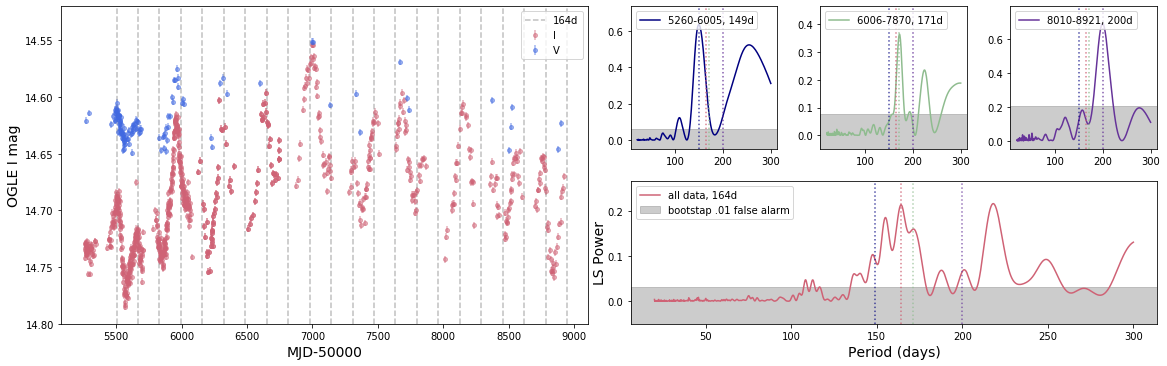

In [320]:
#add subplot version -- adjust heights of plots

fig,ax=plt.subplots(2,6,figsize=(16,5))
fig.tight_layout(w_pad=.9)
gs = ax[0, 0].get_gridspec()
# remove the underlying axes
for a in ax[1, 0:]:
    a.remove()
for a in ax[0, :3]:
    a.remove()
axbig = fig.add_subplot(gs[1, 3:])
axvi = fig.add_subplot(gs[:, :3])
#axvi = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gs[:,:3], wspace = 1)

#plt.subplots_adjust(hspace=.14,wspace=.2)
colors = ['#CF6275','navy','darkseagreen','rebeccapurple']
labs = ['all data, 164d','5260-6005, 149d','6006-7870, 171d','8010-8921, 200d']
#lins = ['solid','dashed','dotted','-.']
st = [0,0,420,743]
end = [-1,420,743,-1]
t = sog4['MJD-50000']
y = sog4['I detrend 2']
y2 = sog4['I mag']
#epoch false alarms
efl = [0.06017603227970809,0.0770878648805269,0.204807881794453]
for s in range(len(st)):
    if s == 0: 
        ls = LombScargle(t[st[s]:end[s]], y[st[s]:end[s]])
        freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=1/300,
                           maximum_frequency=.05,
                           samples_per_peak=50) #originally 10
        #power = np.exp(power)
        axbig.plot(1/freq,power,color=colors[0],label=labs[s])
        best_freq = freq[np.argmax(power)]
        print(1/best_freq)
        axbig.axvline(164,color='#CF6275',alpha=.8,linestyle='dotted')
        axbig.axvline(149,color='navy',alpha=.7,linestyle='dotted')
        axbig.axvline(171.42469761473853,color='darkseagreen',alpha=.7,linestyle='dotted')
        axbig.axvline(199.53730244953758,color='rebeccapurple',alpha=.7,linestyle='dotted')
        #fl = ls.false_alarm_level(.01,method='bootstrap')
        #print(fl)
        #adding false alarm value
        axbig.axhspan(-.1,0.03220795232373002,color='grey',alpha=.4,label='bootstap .01 false alarm')
        axbig.set_ylim(-.05,power.max()+.05)
    else: 
        ls = LombScargle(t[st[s]:end[s]], y[st[s]:end[s]])
        freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=1/300,
                           maximum_frequency=.05,
                           samples_per_peak=50) #originally 10
        #power = np.exp(power)
        ax[0,s+2].plot(1/freq,power,color=colors[s],label=labs[s])
        best_freq = freq[np.argmax(power)]
        print(1/best_freq)
        ax[0,s+2].legend(loc='upper left')
        ax[0,s+2].axvline(164,color='#CF6275',alpha=.8,linestyle='dotted')
        ax[0,s+2].axvline(149,color='navy',alpha=.7,linestyle='dotted')
        ax[0,s+2].axvline(171.42469761473853,color='darkseagreen',alpha=.8,linestyle='dotted')
        ax[0,s+2].axvline(199.53730244953758,color='rebeccapurple',alpha=.8,linestyle='dotted')
        #fl = ls.false_alarm_level(.01,method='bootstrap')
        #print(fl)
        ax[0,s+2].axhspan(-.1,efl[s-1],color='grey',alpha=.4)
        ax[0,s+2].set_ylim(-.05,power.max()+.1)
    #plt.axvline(1/best_freq,color=colors[s])
axbig.legend()
axbig.tick_params(labelsize=10)
axbig.set_yticks([0,.1,.2])
axbig.set_xlabel('Period (days)',fontsize=14)
axbig.set_ylabel('LS Power',fontsize=14,labelpad=1)


axvi.errorbar(li['MJD-50000'],li['I mag'],yerr=li['I mag err'],marker='o',markersize=4,alpha=.5,linestyle='None',color='#CF6275',label='I')
axvi.errorbar(lv['MJD-50000'],lv['V mag'],yerr=lv['V mag err'],marker='o',markersize=4,alpha=.5,linestyle='None',color='royalblue',label='V')
axvi.set_ylim(14.8,14.52)
for i in range(1,22):
     axvi.axvline(5503+i*164,0,1,linestyle='dashed',color='grey',alpha=.5)
axvi.axvline(5503,0,1,linestyle='dashed',color='grey',alpha=.5,label='164d')
axvi.legend(loc='upper right')
axvi.set_xlabel('MJD-50000',fontsize=14)
axvi.set_ylabel('OGLE I mag',fontsize=14)

#png('lcgram')

218.05063005834927
148.89669704771234
171.7406003274557
199.53730244953758


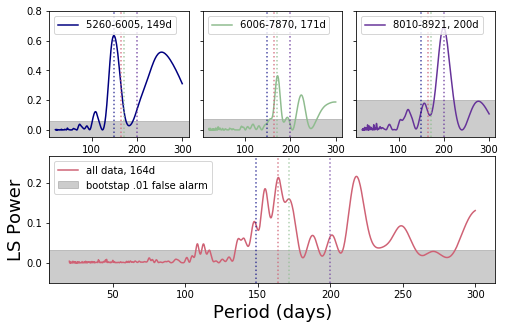

In [321]:
#add subplot version -- adjust heights of plots
from matplotlib import gridspec
fig,ax=plt.subplots(2,3,figsize=(8,5))
gs = ax[0, 0].get_gridspec()
# remove the underlying axes
for a in ax[1, 0:]:
    a.remove()
axbig = fig.add_subplot(gs[1, 0:])
efl = [0.06017603227970809,0.0770878648805269,0.204807881794453]
plt.subplots_adjust(hspace=.15,wspace=.1)
colors = ['#CF6275','navy','darkseagreen','rebeccapurple']
labs = ['all data, 164d','5260-6005, 149d','6006-7870, 171d','8010-8921, 200d']
#lins = ['solid','dashed','dotted','-.']
st = [0,0,420,743]
end = [-1,420,743,-1]
t = sog4['MJD-50000']
y = sog4['I detrend 2']
y2 = sog4['I mag']
for s in range(len(st)):
    if s == 0: 
        ls = LombScargle(t[st[s]:end[s]], y[st[s]:end[s]])
        freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=1/300,
                           maximum_frequency=.05,
                           samples_per_peak=50) #originally 10
        #power = np.exp(power)
        axbig.plot(1/freq,power,color=colors[0],label=labs[s])
        best_freq = freq[np.argmax(power)]
        print(1/best_freq)
        axbig.axvline(164,color='#CF6275',alpha=.8,linestyle='dotted')
        axbig.axvline(149,color='navy',alpha=.7,linestyle='dotted')
        axbig.axvline(171.42469761473853,color='darkseagreen',alpha=.7,linestyle='dotted')
        axbig.axvline(199.53730244953758,color='rebeccapurple',alpha=.7,linestyle='dotted')
        #fl = ls.false_alarm_level(.01,method='bootstrap')
        axbig.axhspan(-.1,0.03220795232373002,color='grey',alpha=.4,label='bootstap .01 false alarm')
        axbig.set_ylim(-.05,power.max()+.05)
    else: 
        ls = LombScargle(t[st[s]:end[s]], y[st[s]:end[s]])
        freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=1/300,
                           maximum_frequency=.05,
                           samples_per_peak=50) #originally 10
        #power = np.exp(power)
        ax[0,s-1].plot(1/freq,power,color=colors[s],label=labs[s])
        best_freq = freq[np.argmax(power)]
        print(1/best_freq)
        ax[0,s-1].legend(loc='upper left')
        ax[0,s-1].axvline(164,color='#CF6275',alpha=.8,linestyle='dotted')
        ax[0,s-1].axvline(149,color='navy',alpha=.7,linestyle='dotted')
        ax[0,s-1].axvline(171.42469761473853,color='darkseagreen',alpha=.8,linestyle='dotted')
        ax[0,s-1].axvline(199.53730244953758,color='rebeccapurple',alpha=.8,linestyle='dotted')
        #fl = ls.false_alarm_level(.01,method='bootstrap')
        ax[0,s-1].axhspan(-.1,efl[s-1],color='grey',alpha=.4)
        ax[0,s-1].set_ylim(-.05,.8)
        if s>1: 
            a=ax[0,0].get_yticks().tolist()
            a=['','','','','','','','']
            ax[0,s-1].set_yticklabels(a)
    #plt.axvline(1/best_freq,color=colors[s])
axbig.legend()
#plt.tick_params(labelsize=14)
axbig.set_xlabel('Period (days)',fontsize=18)
axbig.set_ylabel('LS Power',fontsize=18,labelpad=1)
plt.legend()

#png('4panelpdgramdet')

In [322]:
#using error minization values; close to periodogram values, couple days uncertainty
reg1['phase 150'] = reg1['MJD'] % 150.
reg2['phase 171'] = reg2['MJD'] % 171.
reg3['phase 201'] = reg3['MJD'] % 201.

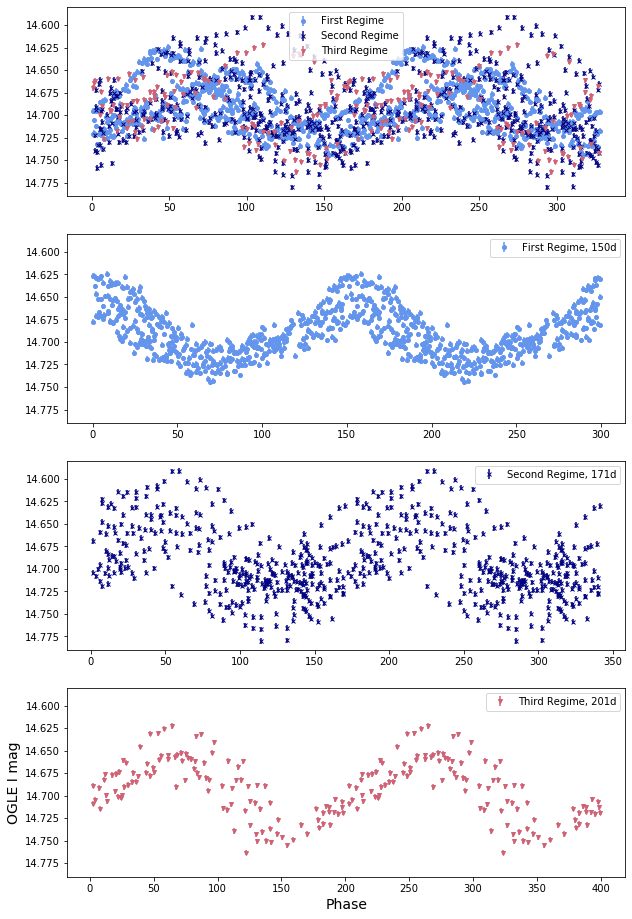

In [323]:
#version up to phase 2
#update with final "best" values
fig,ax=plt.subplots(4,1,sharey=True,figsize=(10,16))
#ax[0].errorbar(og4['phase 164'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1,label='All Data, 164d')
ax[0].errorbar(reg1['phase 164'],reg1['I detrend 2'],yerr=reg1['I mag err'],marker='o',markersize=4,linestyle='None',color=c1,label='First Regime')
ax[0].errorbar(reg2['phase 164'],reg2['I detrend 2'],yerr=reg2['I mag err'],marker='x',markersize=4,linestyle='None',color=c2,label='Second Regime')
ax[0].errorbar(reg3['phase 164'],reg3['I detrend 2'],yerr=reg3['I mag err'],marker='v',markersize=4,linestyle='None',color=c4,label='Third Regime')
ax[0].errorbar(best_p+reg1['phase 164'],reg1['I detrend 2'],yerr=reg1['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
ax[0].errorbar(best_p+reg2['phase 164'],reg2['I detrend 2'],yerr=reg2['I mag err'],marker='x',markersize=4,linestyle='None',color=c2)
ax[0].errorbar(best_p+reg3['phase 164'],reg3['I detrend 2'],yerr=reg3['I mag err'],marker='v',markersize=4,linestyle='None',color=c4)



ax[1].errorbar(reg1['phase 150'],reg1['I detrend 2'],yerr=reg1['I mag err'],marker='o',markersize=4,linestyle='None',color=c1,label='First Regime, 150d')
ax[1].errorbar(150+reg1['phase 150'],reg1['I detrend 2'],yerr=reg1['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)

ax[2].errorbar(reg2['phase 171'],reg2['I detrend 2'],yerr=reg2['I mag err'],marker='x',markersize=4,linestyle='None',color=c2,label='Second Regime, 171d')
ax[2].errorbar(171+reg2['phase 171'],reg2['I detrend 2'],yerr=reg2['I mag err'],marker='x',markersize=4,linestyle='None',color=c2)

ax[3].errorbar(reg3['phase 201'],reg3['I detrend 2'],yerr=reg3['I mag err'],marker='v',markersize=4,linestyle='None',color=c4,label='Third Regime, 201d')
ax[3].errorbar(201+reg3['phase 201'],reg3['I detrend 2'],yerr=reg3['I mag err'],marker='v',markersize=4,linestyle='None',color=c4)

ax[3].set_xlabel('Phase',fontsize=14)
ax[3].set_ylabel('OGLE I mag',fontsize=14)
plt.ylim(14.75+.04,14.54+.04)
ax[0].legend();ax[1].legend();ax[2].legend();ax[3].legend()
#png('4folds2ph')

## middle part is messiest; not surprising consider super wide flare around 7000 days

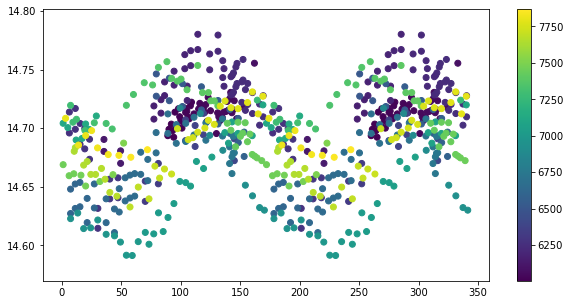

In [324]:
#can see separate flares with colorbar
plt.figure(figsize=(10,5))
plt.scatter(reg2['phase 171'],reg2['I detrend 2'],c=reg2['MJD-50000'],label='Second Regime, 171d')
plt.scatter(171+reg2['phase 171'],reg2['I detrend 2'],c=reg2['MJD-50000'],label='Second Regime, 171d')
plt.colorbar()

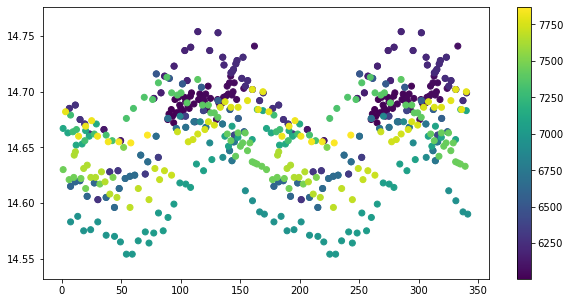

In [325]:
#can see separate flares with colorbar -- original rather than detrended
plt.figure(figsize=(10,5))
plt.scatter(reg2['phase 171'],reg2['I mag'],c=reg2['MJD-50000'],label='Second Regime, 171d')
plt.scatter(171+reg2['phase 171'],reg2['I mag'],c=reg2['MJD-50000'],label='Second Regime, 171d')
plt.colorbar()

> can see separate flares not in phase with each other

# 10. Fitting Flares With Gaussians
redoing center fitting by using centers of Gaussian fits
**define all models up here**

> show writing out of sog4 and why it was needed for this gauss package

In [326]:
#easiest to get into right format by reading out and back in
np.savetxt('sog4.dat',sog4)

In [327]:
load_sog4 = np.loadtxt('sog4.dat')

In [328]:
sog4.head()

JD   I mag  I mag err          MJD   MJD-50000  I detrend 2  \
0  2.455261e+06  14.742      0.003  55260.14719  5260.14719    14.714925   
1  2.455262e+06  14.729      0.003  55261.15051  5261.15051    14.701785   
2  2.455263e+06  14.735      0.003  55262.14427  5262.14427    14.707645   
3  2.455265e+06  14.733      0.003  55264.11167  5264.11167    14.705505   
4  2.455266e+06  14.730      0.003  55265.11299  5265.11299    14.702365   

   phase 164  
0   7.888307  
1   8.891627  
2   9.885387  
3  11.852787  
4  12.854107

In [329]:
#fix flareinds for half gaussian
flareinds[2] = [241,258]

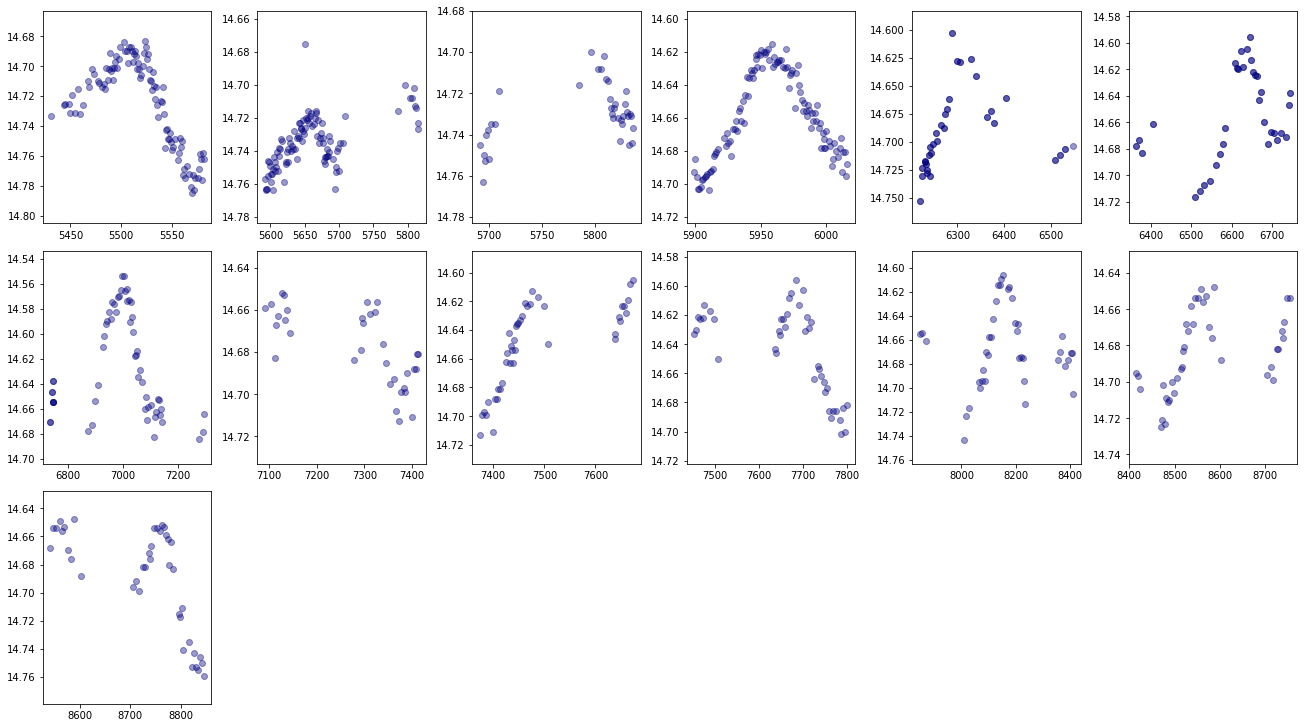

In [330]:
#investigating individual flares -- how many have known minima?
fig = plt.figure(constrained_layout=True,figsize=(18,10))
gs = fig.add_gridspec(3,6)
for f in range(13):
    if f < 6: axt = fig.add_subplot(gs[0, f])
    elif f < 12: axt = fig.add_subplot(gs[1, f-6])
    else: axt = fig.add_subplot(gs[2, f-12])
    st = flareinds[f][0]-10
    end = flareinds[f][1]+10 #increasing bounds
    stdate = int(sog4['MJD-50000'][st:st+1])
    enddate = int(sog4['MJD-50000'][end-1:end])
    axt.scatter(sog4['MJD-50000'][st:end],sog4['I mag'][st:end],color='navy',alpha=.4)
    axt.set_ylim(np.max(sog4['I mag'][st:end])+.02,np.min(sog4['I mag'][st:end])-.02)
    #axt.scatter(sog4['MJD-50000'][st:end],.05+np.max(sog4['I detrend 2'][st:end])-sog4['I detrend 2'][st:end],color='navy')


In [331]:
#see how trends vary with offset
def gparams(offset,mags=1,more=False):
    '''
    Fits Gaussian to each of 13 flares. 
    Uses offset argument to add to the difference between
    the flare's mag maximum and the data. 
    mags is ind of I data to use; 1 is original, 5 is detrended'''
    gouts = []
    for f in range(len(flareinds)):   
        x = load_sog4[flareinds[f][0]:flareinds[f][1],4]
        #uses original (not detrended) data
        y = offset + np.max(load_sog4[flareinds[f][0]:flareinds[f][1],mags]) - load_sog4[flareinds[f][0]:flareinds[f][1],mags]
        mod = GaussianModel()
        pars = mod.guess(y, x=x)
        out = mod.fit(y, pars, x=x)
        gouts.append(out)
    #DataFrame with values for each flare; includes error columns but those have to be hard-coded?
    ggfits = pd.DataFrame(columns=['center','center err','sigma','sigma err','fwhm','fwhm err','height','height err','amp','amp err'])
    #13 flares
    ggfits['center'] = np.zeros(13)
    i = 0
    for o in gouts: 
        ggfits['center'][i] = o.params['center'].value
        ggfits['fwhm'][i] = o.params['fwhm'].value
        ggfits['height'][i] = o.params['height'].value
        ggfits['amp'][i] = o.params['amplitude'].value
        ggfits['sigma'][i] = o.params['sigma'].value
        i += 1
    if more: return gouts,ggfits
    else: return ggfits

In [332]:
def plotrel(gfl,colors=['navy','cornflowerblue','rebeccapurple','palevioletred','darkseagreen']): #gaussian fit list
    '''Plots relations between Gaussian model quantities.
    gfl: list of DataFrames with center, height, fwhm, amp'''
    fig3 = plt.figure(constrained_layout=True,figsize=(11,9))
    gs = fig3.add_gridspec(3, 3)
    ax1 = fig3.add_subplot(gs[0, 0])
    ax2 = fig3.add_subplot(gs[0, 1],sharey=ax1)
    ax3 = fig3.add_subplot(gs[0, 2],sharey=ax1)
    ax4 = fig3.add_subplot(gs[1, 0])
    ax5 = fig3.add_subplot(gs[1, 1],sharey=ax4)
    ax6 = fig3.add_subplot(gs[2, 1])
    #colors = ['navy','cornflowerblue','rebeccapurple','palevioletred','darkseagreen']
    i = 0
    for g in gfl:
        ax1.errorbar(g['amp'],g['height'],linestyle='none',marker='o',alpha=.7,color=colors[i])
        ax2.errorbar(g['center'],g['height'],linestyle='none',marker='o',alpha=.7,color=colors[i])
        ax4.errorbar(g['amp'],g['fwhm'],linestyle='none',marker='o',alpha=.7,color=colors[i])
        ax5.errorbar(g['center'],g['fwhm'],linestyle='none',marker='o',alpha=.7,color=colors[i])

        ax6.errorbar(g['center'],g['amp'],linestyle='none',marker='o',alpha=.7,color=colors[i])
        ax6.set_xlabel('Center',fontsize=14)
    
        ax3.errorbar(g['fwhm'],g['height'],linestyle='none',marker='o',alpha=.7,color=colors[i])
        i+=1
    #set labels once
    ax4.set_ylabel('FWHM',fontsize=14)
    ax1.set_ylabel('Height',fontsize=14)
    ax1.set_xlabel('Amplitude',fontsize=14)
    ax6.set_ylabel('Amplitude',fontsize=14)
    ax2.set_xlabel('Center',fontsize=14)
    ax4.set_xlabel('Amplitude',fontsize=14)
    ax5.set_xlabel('Center',fontsize=14)
    ax3.set_xlabel('FWHM',fontsize=14)

In [595]:
gfl = []
gflouts = []
#try out offsets 0-0.08
for g in [0,.02,.04,.06,.08]:
    touts,tfits = (gparams(g,more=True))
    gfl.append(tfits)
    gflouts.append(touts) #report by flare

In [607]:
#compare chis
for f in range(13):
    print('no offset',f,gflouts[0][f].chisqr,'.08 offset',gflouts[-1][f].chisqr)


no offset 0 0.01326061235640647 .08 offset 0.01836748631058023
no offset 1 0.006664748677130002 .08 offset 0.007361481971187472
no offset 2 0.0003102184335112983 .08 offset 0.00045260576511911197
no offset 3 0.0036475898123836045 .08 offset 0.004599912570505478
no offset 4 0.005785808275644392 .08 offset 0.006695995001852208
no offset 5 0.0024603734916256166 .08 offset 0.006612846628318239
no offset 6 0.002490248436236144 .08 offset 0.0029581034343278837
no offset 7 0.0002767610027696118 .08 offset 0.0003133963729078969
no offset 8 0.0009283460179522538 .08 offset 0.001114929493141691
no offset 9 0.0011714900998810699 .08 offset 0.001402335743142568
no offset 10 0.000661920366776026 .08 offset 0.0006223567725802797
no offset 11 0.0010988715557884521 .08 offset 0.00115370184839072
no offset 12 0.0013165436166507095 .08 offset 0.001528769068883043


In [573]:
#centers with no offset, regular gaussian
np.array(gfl[0]['center'])

array([5503.14498827, 5654.91940517, 5798.59254892, 5960.25093808,
       6317.94475186, 6635.51535463, 6988.86401641, 7313.71627135,
       7477.07692024, 7681.64658117, 8157.14515184, 8559.27900244,
       8755.94374512])

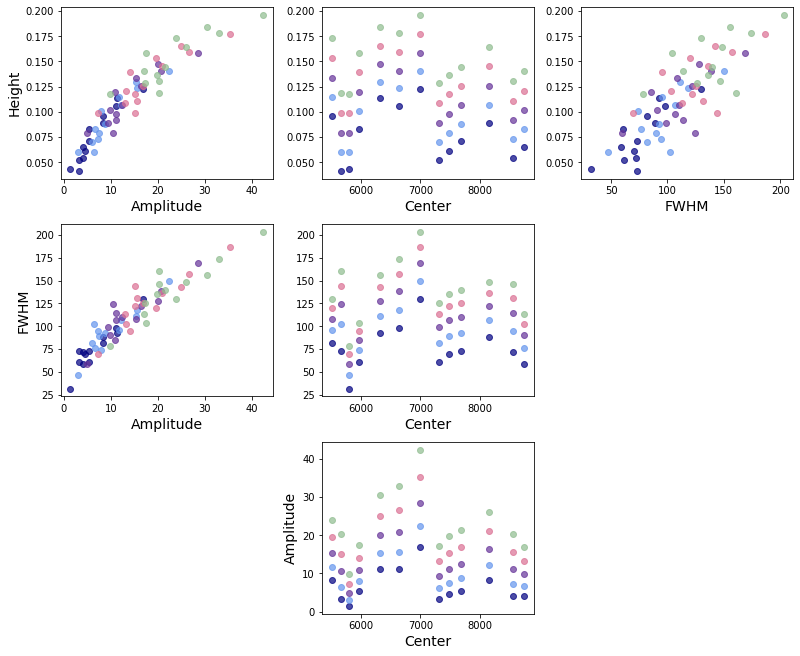

In [335]:
#plot the relationships using different offsets
#offsets go from 0 to .08, with navy at 0 and green at .08
plotrel(gfl)
#png('diffoffsetrel')

In [336]:
gfl[3]['center']

0     5502.702922
1     5654.802454
2     5797.665448
3     5960.177164
4     6318.022235
5     6634.198582
6     6988.816602
7     7314.237621
8     7477.111433
9     7682.473587
10    8157.051582
11    8559.417105
12    8753.727885
Name: center, dtype: float64

In [337]:
cenarray = np.zeros((13,5))
i = 0
for g in gfl:
    for c in range(13):
        cenarray[c][i] = g['center'][c]
    i+=1

In [338]:
#this can replace what's below
outs, gfits = gparams(.05,more=True)
centers = np.array(gfits['center'])

#detrended
det_outs, det_gfits = gparams(.05,mags=5,more=True)
det_centers = np.array(det_gfits['center'])

In [608]:
#detrended chi squared -- but it's relative to different data
for d in det_outs:
    print(d.chisqr)

0.0055806846860210375
0.007509446277761053
0.0004082127896273139
0.00400321149164906
0.010030646729499089
0.010358861518845217
0.0025993158191966654
0.00028546171028651204
0.0010772304662824386
0.0013502449539836102
0.0006202177964412298
0.0011071478850699142
0.0014167725942436427


In [339]:
#trying gaussian + line
#needs fixing to prevent negative values
from numpy import exp, pi, sqrt

from lmfit import Model


def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (sqrt(2*pi) * wid)) * exp(-(x-cen)**2 / (2*wid**2))


def line(x, slope, intercept):
    """a line"""
    return slope*x + intercept

def gaussline(ind,plot=True):
    x = load_sog4[flareinds[ind][0]:flareinds[ind][1],4]
    #gives a little extra space but still doesn't make much sense
    y = .05 + np.max(load_sog4[flareinds[ind][0]:flareinds[ind][1],1]) - load_sog4[flareinds[ind][0]:flareinds[ind][1],1]
    mod = Model(gaussian) + Model(line)
    #using guesses from previous model
    gf = outs[ind].best_values #getting guesses from previous fit (just gaussian)
    amp, cen, wid = gf['amplitude'], gf['center'], gf['sigma']
    print(cen)
    pars = mod.make_params(amp=amp, cen=cen, wid=wid, slope=0, intercept=1)
    pars['amp'].min = 0.0
    pars['cen'].min = cen-20
    pars['cen'].max = cen+20
    pars['wid'].min = 0.0

    result = mod.fit(y, pars, x=x)
    if plot:
        plt.plot(x, y, 'bo')
        #plt.plot(x, result.init_fit, 'k--', label='initial fit')
        plt.plot(x, result.best_fit, 'r-', label='best fit')
        plt.axvline(result.best_values['cen'],color='black')
        plt.legend(loc='best')
        plt.show()
    return result.best_values

In [340]:
centers

array([5502.75971879, 5654.80000132, 5797.75329703, 5960.2006646 ,
       6318.03954066, 6634.39651542, 6988.81060193, 7314.20106245,
       7477.07563141, 7682.40427138, 8157.06283888, 8559.40489096,
       8753.88179913])

5502.759718787926


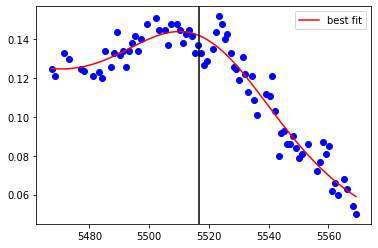

5654.8000013159135


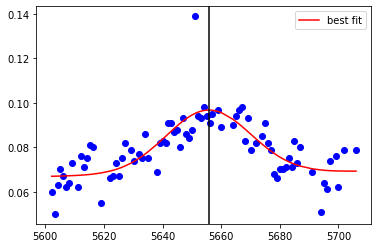

5797.7532970317025


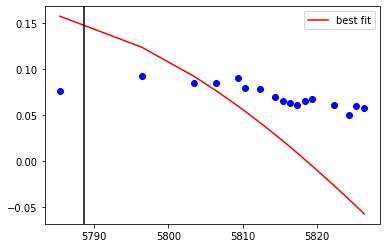

5960.200664601158


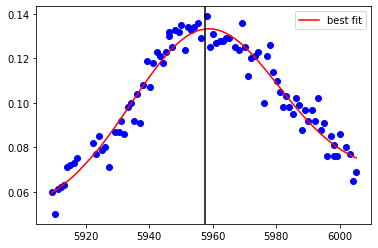

6318.039540660164


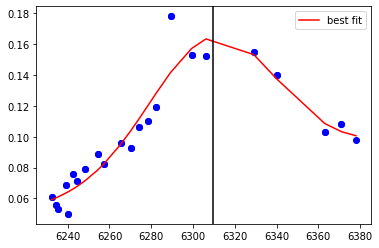

6634.3965154154575


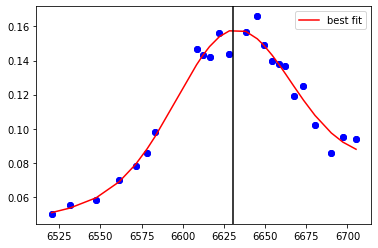

6988.810601929297


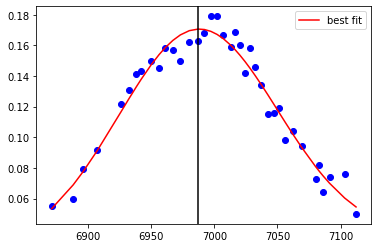

7314.2010624509485


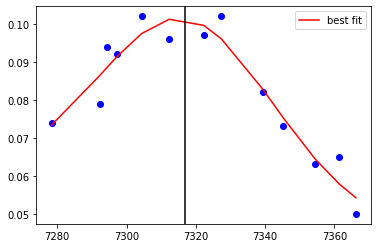

7477.075631412105


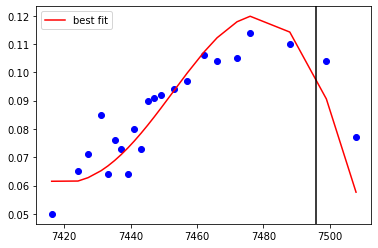

7682.40427137706


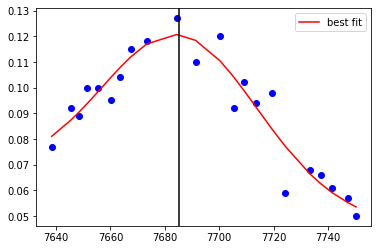

8157.062838878987


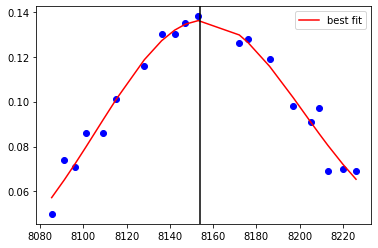

8559.404890964699


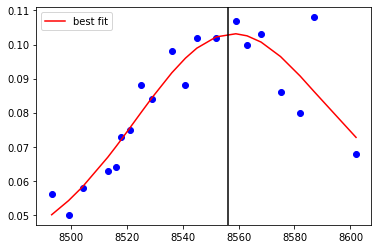

8753.881799131408


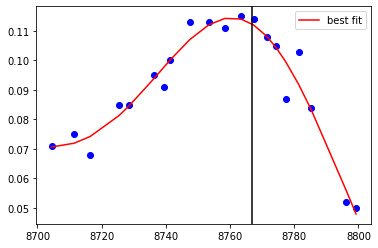

In [341]:
#gauss+line figures and centers
glcens = []
glfits = []
for i in range(13):
    #prints each center result
    flfit = gaussline(i) #can set to True to print out each flare fit
    glfits.append(flfit)
    glcens.append(flfit['cen']) 

In [342]:
glfits[0]['cen']

5516.581715632413

In [609]:
glfits[0]

{'slope': -0.0006336533308062703,
 'intercept': 3.5839270243896353,
 'amp': 3.1040341462928174,
 'cen': 5516.581715632413,
 'wid': 23.02288117609001}

In [343]:
#doesn't have the same values, at least for now -- plot separately
glff = pd.DataFrame(columns=['cen','wid','amp']) #gaussian line fit frame
glff['cen'] = np.zeros(13)
c = 0
for g in glfits:
    glff['cen'][c] = g['cen']
    glff['wid'][c] = g['wid']
    glff['amp'][c] = g['amp']
    c += 1
glff

cen      wid      amp
0   5516.581716  23.0229  3.10403
1   5655.694794  14.4549  1.03916
2   5788.583253  60.3727  90.1819
3   5957.653467  23.0495   4.2994
4   6309.594343  30.3336  6.75749
5   6630.778221  34.7159  7.89751
6   6987.139353  62.8546  21.9362
7   7316.873947  25.1531  3.01164
8   7495.962177  43.0992  31.4722
9   7685.377269  28.4077  4.43062
10  8153.709498  47.4021  13.3527
11  8556.221489  32.9514  4.63013
12  8766.884792  29.4108  6.91014

In [344]:
#taking out half flare
glff = glff[glff['amp']<90]

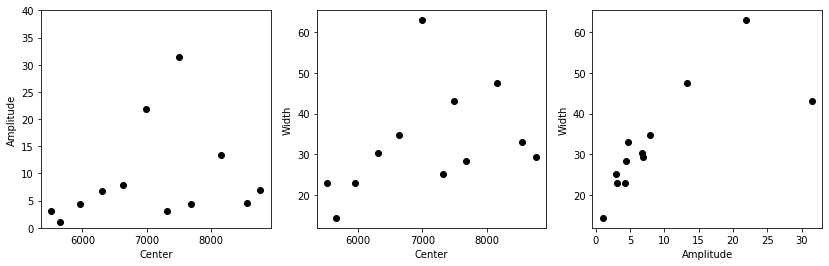

In [345]:
fig,ax=plt.subplots(1,3,figsize=(14,4))
ax[0].scatter(glff['cen'],glff['amp'],color='black')
ax[0].set_ylim(0,40)
ax[0].set_xlabel('Center')
ax[0].set_ylabel('Amplitude')
ax[1].scatter(glff['cen'],glff['wid'],color='black')
ax[1].set_xlabel('Center')
ax[1].set_ylabel('Width')
ax[2].scatter(glff['amp'],glff['wid'],color='black')
ax[2].set_xlabel('Amplitude')
ax[2].set_ylabel('Width')
png('gausslinerel')

In [346]:
#model with no offset
outs2,gfits2 = gparams(0,more=True)
centers2 = np.array(gfits2['center'])

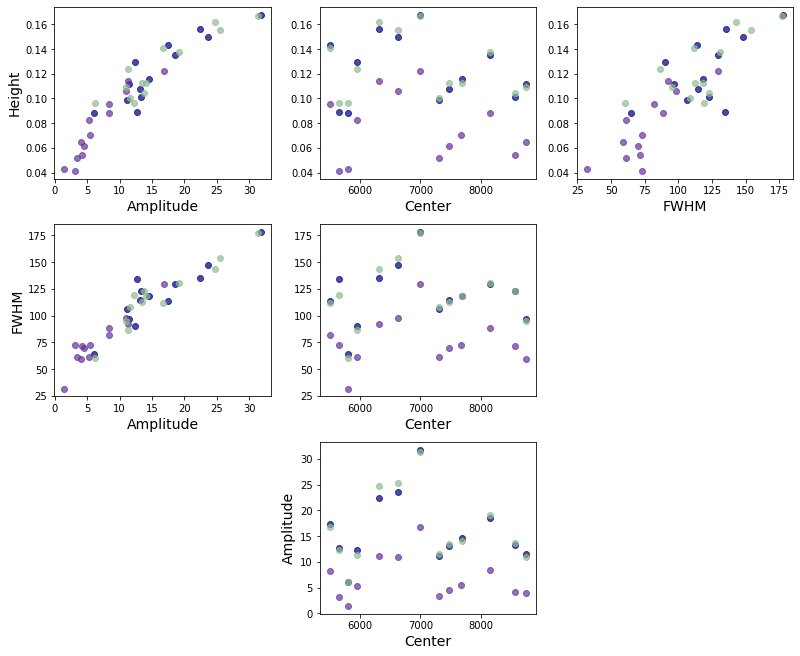

In [347]:
plotrel([gfits,gfits2,det_gfits],colors=['navy','rebeccapurple','darkseagreen'])
png('3gaussrel')

Text(0, 0.5, 'Center Fit - Min Center Fit')

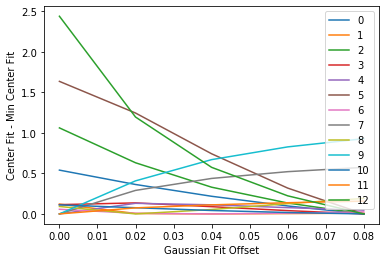

In [348]:
#plot centers as function of offset; add other methods (gauss+line; detrended) later
offs = np.arange(0,.1,.02)
for o in range(13):
    plt.plot(offs,cenarray[o]-np.min(cenarray[o]),label=str(o))
plt.legend()
plt.xlabel('Gaussian Fit Offset')
plt.ylabel('Center Fit - Min Center Fit')

In [349]:
det_centers

array([5504.78234763, 5654.03538067, 5797.22500671, 5957.63203305,
       6318.43910593, 6632.05503736, 6990.22580051, 7312.68358395,
       7478.21989207, 7683.08373516, 8158.20785079, 8560.83518559,
       8755.11521309])

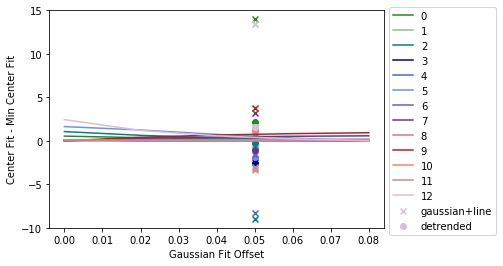

In [350]:
#plot center results from different methods
#detrended and gaussian+line defined lower down
cs = ['forestgreen','darkseagreen','teal','navy','royalblue','cornflowerblue','slateblue','rebeccapurple','palevioletred','firebrick','salmon','rosybrown','thistle']
offs = np.arange(0,.1,.02)
for o in range(13):
    plt.plot(offs,cenarray[o]-np.min(cenarray[o]),label=str(o),color=cs[o])
for d in range(len(det_centers)):
    plt.scatter(.05,det_centers[d]-np.min(cenarray[d]),color=cs[d])
    
    #add gaussian+line centers
    plt.scatter(.05,glcens[d]-np.min(cenarray[d]),color=cs[d],marker='x')
plt.scatter(.05,glcens[d]-np.min(cenarray[d]),color=cs[d],marker='x',label='gaussian+line')
plt.scatter(.05,det_centers[d]-np.min(cenarray[d]),color=cs[d],label='detrended')

#cutting off high ones
plt.ylim(-10,15)

plt.legend(bbox_to_anchor=(0, 0, 1.35, 1.04))
plt.xlabel('Gaussian Fit Offset')
plt.ylabel('Center Fit - Min Center Fit')
png('diffcenters')

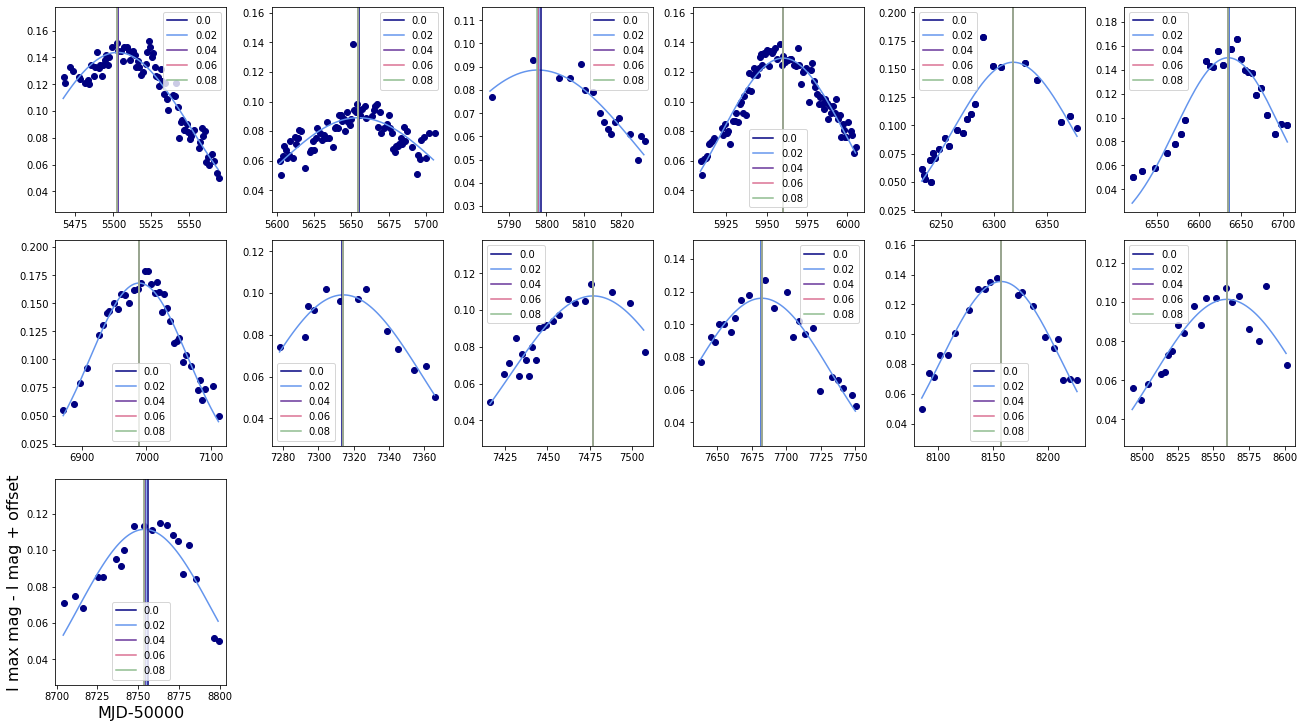

In [493]:
#plot centers from different offsets
fig = plt.figure(constrained_layout=True,figsize=(18,10))
gs = fig.add_gridspec(3,6)
for f in range(13):
    if f < 6: axt = fig.add_subplot(gs[0, f])
    elif f < 12: axt = fig.add_subplot(gs[1, f-6])
    else: axt = fig.add_subplot(gs[2, f-12])
    st = flareinds[f][0]
    end = flareinds[f][1]
    stdate = int(sog4['MJD-50000'][st:st+1])
    enddate = int(sog4['MJD-50000'][end-1:end])
    axt.scatter(sog4['MJD-50000'][st:end],np.max(sog4['I mag'][st:end])-sog4['I mag'][st:end]+.05,color='navy')
    xfits = np.linspace(enddate,stdate,enddate-stdate)
    bfit = gaussian(xfits,outs[f].best_values['amplitude'],outs[f].best_values['center'],outs[f].best_values['sigma'])
    axt.plot(xfits,bfit,color='cornflowerblue') 
    cs = ['navy','cornflowerblue','rebeccapurple','palevioletred','darkseagreen']
    for i in range(5):
        axt.axvline(gfl[i]['center'][f],color=cs[i],label=str(i*.02))
    axt.legend()
axt.set_ylabel('I max mag - I mag + offset',fontsize=16)
axt.set_xlabel('MJD-50000',fontsize=16)
png('13flarefits')

> - gauss plus line works for some but not all flares
- similar to detrending in a way
- other models to try?
- try to do various models with different bases and show how centers change (ex. sinusoidal)

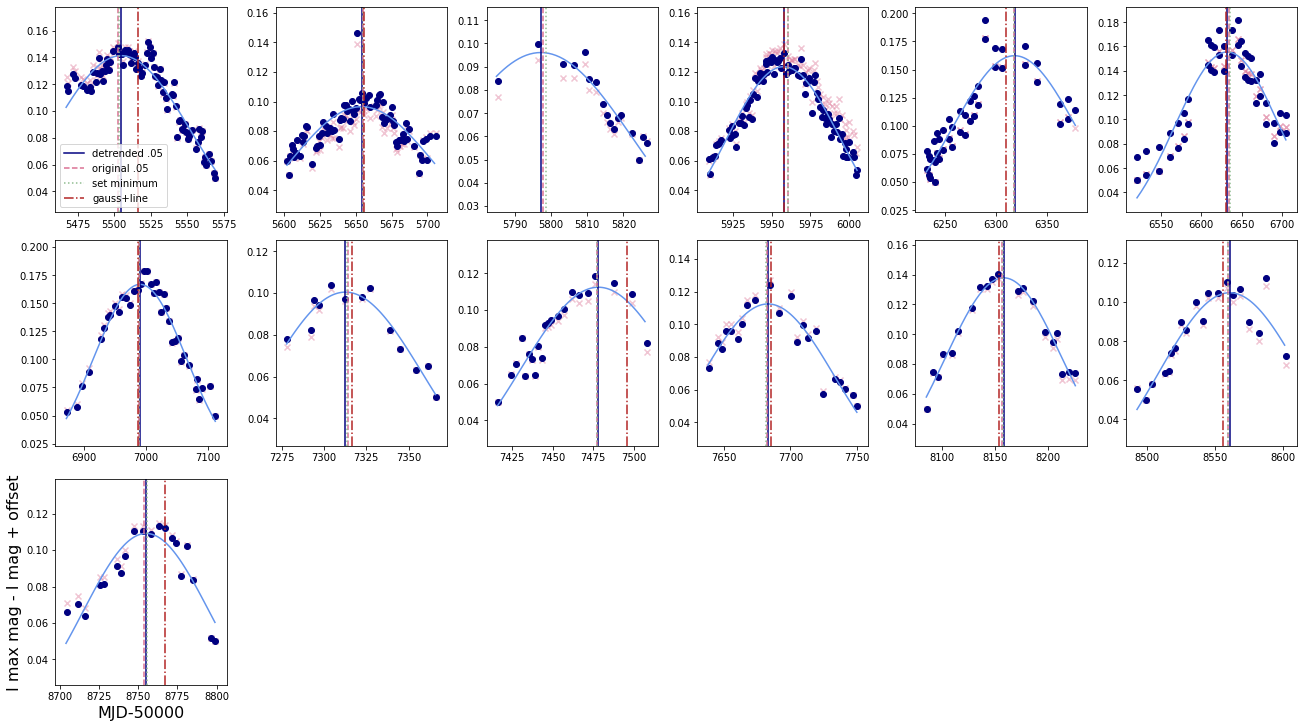

In [494]:
#show modeled 13 flares
#plotting function; removing extra stuff
fig = plt.figure(constrained_layout=True,figsize=(18,10))
gs = fig.add_gridspec(3,6)
for f in range(13):
    if f < 6: axt = fig.add_subplot(gs[0, f])
    elif f < 12: axt = fig.add_subplot(gs[1, f-6])
    else: axt = fig.add_subplot(gs[2, f-12])
    st = flareinds[f][0]
    end = flareinds[f][1]
    stdate = int(sog4['MJD-50000'][st:st+1])
    enddate = int(sog4['MJD-50000'][end-1:end])
    axt.scatter(sog4['MJD-50000'][st:end],np.max(sog4['I mag'][st:end])-sog4['I mag'][st:end]+.05,color='palevioletred',alpha=.4,marker='x')
    axt.scatter(sog4['MJD-50000'][st:end],.05+np.max(sog4['I detrend 2'][st:end])-sog4['I detrend 2'][st:end],color='navy')

    xfits = np.linspace(enddate,stdate,enddate-stdate)
    bfit = gaussian(xfits,det_outs[f].best_values['amplitude'],det_outs[f].best_values['center'],det_outs[f].best_values['sigma'])
    axt.plot(xfits,bfit,color='cornflowerblue') 
    axt.axvline(det_outs[f].best_values['center'],color='navy',label='detrended .05')
    axt.axvline(outs[f].best_values['center'],color='palevioletred',label='original .05',linestyle='dashed')
    axt.axvline(outs2[f].best_values['center'],color='darkseagreen',label='set minimum',linestyle='dotted')
    if np.abs(glcens[f]-det_outs[f].best_values['center'])<50 and f != 2: #can change to just f!=2
        axt.axvline(glcens[f],color='firebrick',label='gauss+line',linestyle='-.')
    if f == 0: axt.legend()
#     if f < 12 and f > 2:
#         d1 = np.abs(gfits['center'][f]-gfits2['center'][f])
#         d2 = np.abs(gfits2['center'][f]-det_gfits['center'][f+1])
#         d3 = np.abs(det_gfits['center'][f+1]-gfits['center'][f])
#         maxd = np.max(np.array([d1,d2,d3]))
#         print(maxd)
axt.set_ylabel('I max mag - I mag + offset',fontsize=16)
axt.set_xlabel('MJD-50000',fontsize=16)
png('det13fits2')

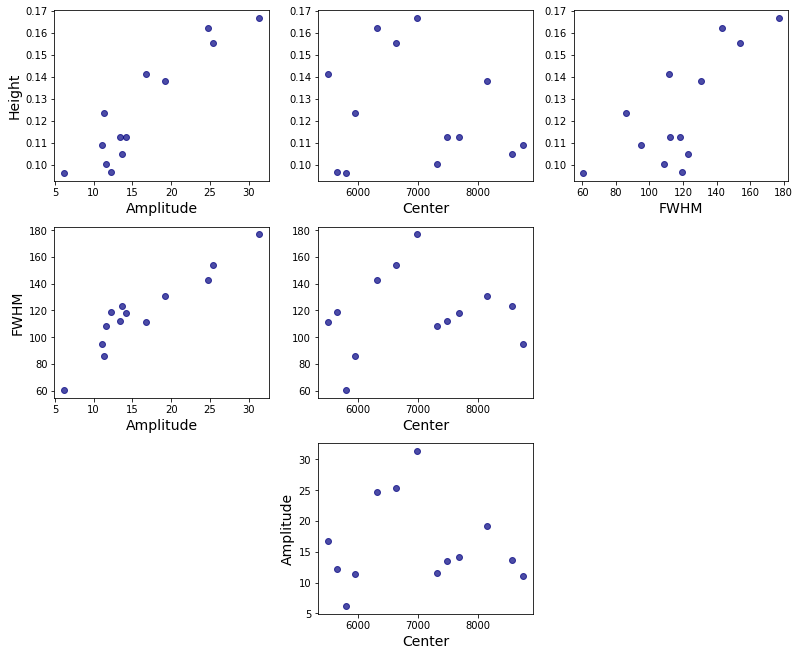

In [353]:
plotrel([det_gfits])
png('gaussreldet')

(14.79, 14.579999999999998)

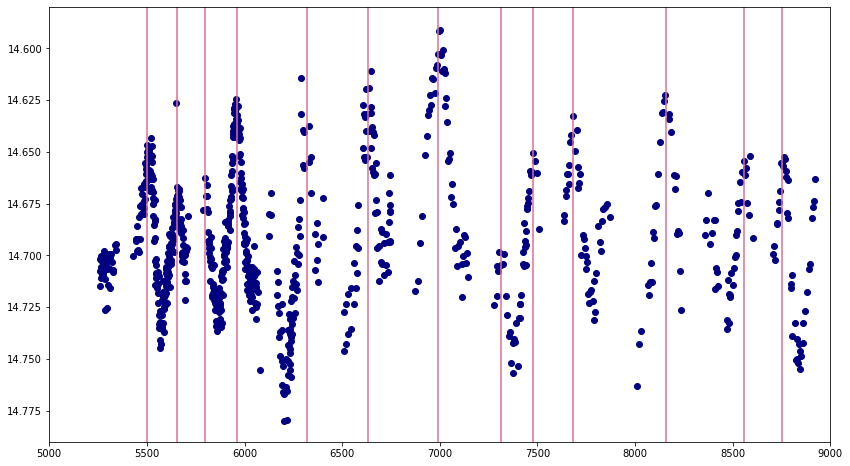

In [354]:
#plot 13 flare centers
plt.figure(figsize=(14,8))
plt.scatter(sog4['MJD-50000'],sog4['I detrend 2'],color='navy')
for c in centers:
    plt.axvline(c,0,1,color='palevioletred') 
plt.xlim(5000,9000)
plt.ylim(14.75+.04,14.54+.04)

(14.75, 14.65)

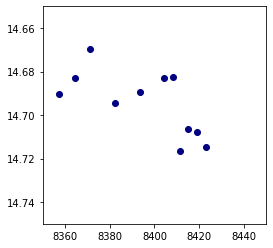

In [355]:
#example of flare we did not fit
plt.figure(figsize=(4,4))
plt.scatter(sog4['MJD-50000'],sog4['I detrend 2'],color='navy')
plt.xlim(8350,8450)
plt.ylim(14.75,14.65)

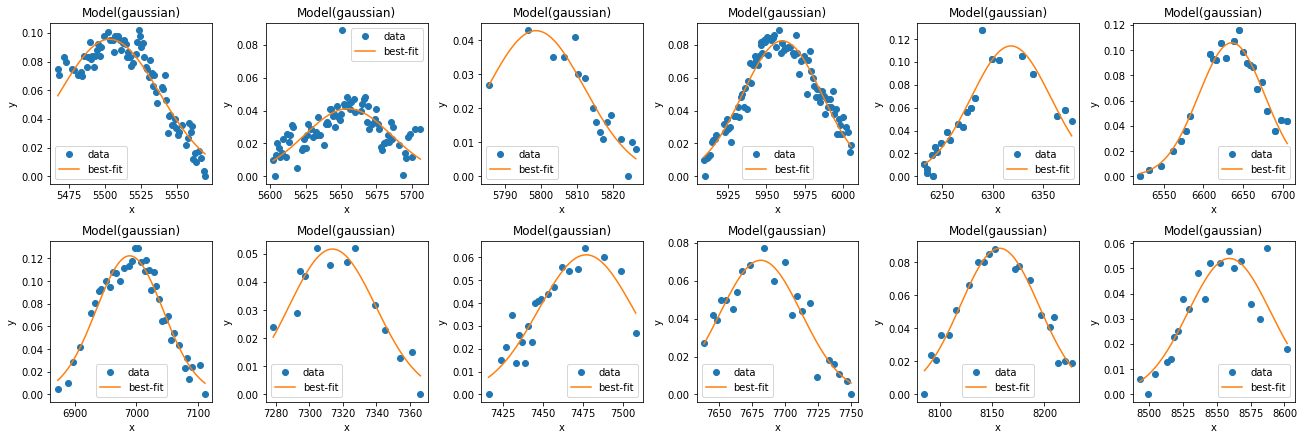

In [356]:
#no offset, zero point at mag maximum value (within flare)
fig = plt.figure(constrained_layout=True,figsize=(18,6))
gs = fig.add_gridspec(2,6)
# ax1 = fig.add_subplot(gs[0, 0])
# outs[0].plot_fit()
# ax2 = fig.add_subplot(gs[0, 1])
# outs[0].plot_fit
# ax3 = fig.add_subplot(gs[0, 0])
for f in range(12):
    if f < 6: axt = fig.add_subplot(gs[0, f])
    else: axt = fig.add_subplot(gs[1, f-6])
    outs2[f].plot_fit(numpoints=1000) #increases number of points so that functions smooth
#     axt.axvspan(gfits2['center'][f]-gfits2['center err'][f],gfits2['center'][f]+gfits2['center err'][f],alpha=.5)
# png('allgfits2')

In [357]:
#used to take out half flare
gfm = flaremid

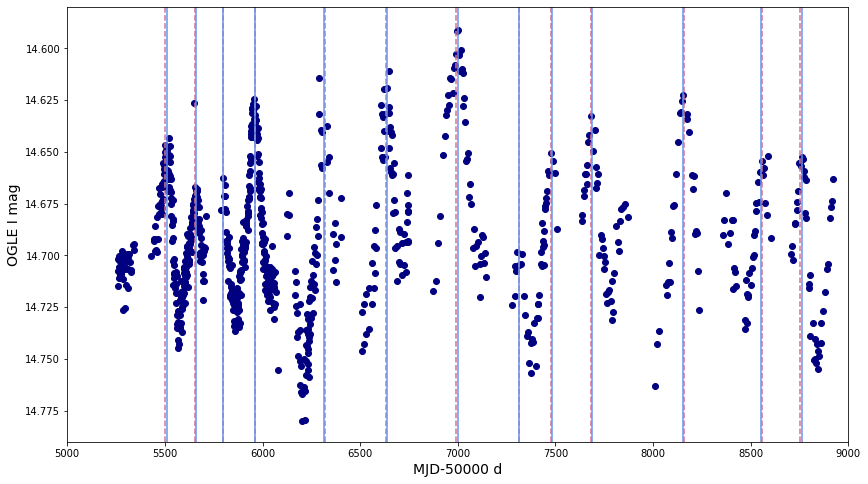

In [358]:
plt.figure(figsize=(14,8))
plt.scatter(og4['MJD-50000'],og4['I detrend 2'],color='navy')
for c in centers:
    plt.axvline(c,0,1,color='palevioletred',linestyle='dashed') 
for f in gfm:
    plt.axvline(f,0,1,color='cornflowerblue')
plt.xlim(5000,9000)
plt.ylim(14.75+.04,14.54+.04)
plt.xlabel('MJD-50000 d',fontsize=14)
plt.ylabel('OGLE I mag',fontsize=14)
plt.savefig('oldandnewcens.png',dpi=200,bbox_inches='tight')

In [359]:
gfm, centers = np.array(gfm), np.array(centers)

In [360]:
cenerr = centers - gfm
cenerr #difference between gaussian fit center and by-eye center

array([ -7.24028121,  -5.19999868,  -2.24670297,   0.2006646 ,
         3.03954066,  -0.60348458, -13.18939807,  -0.79893755,
        -2.92436859,  -2.59572862,   2.06283888,   4.40489096,
        -6.11820087])

In [361]:
np.mean(np.abs(cenerr))

3.8942335579376257

# 11. Repeat Some Analysis With Gaussian Centers
save and upload once final centers chosen
should work with 13 flares
just need to check on chi-squared minimization

do once model decided upon

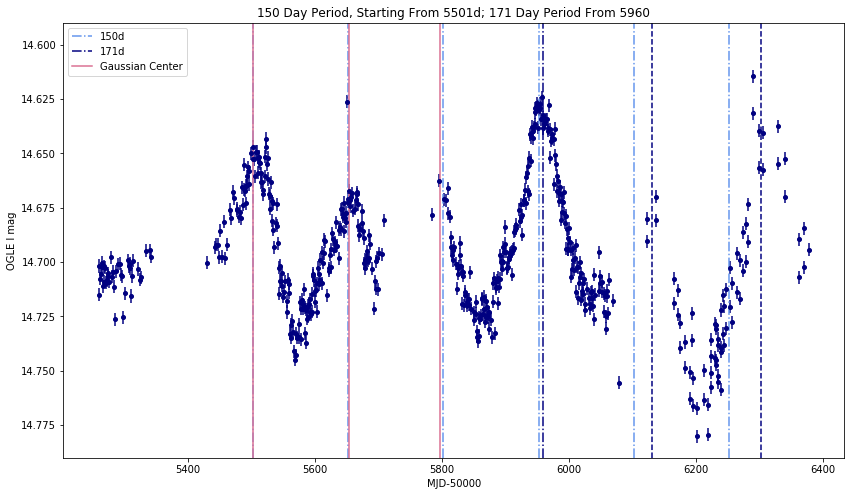

In [362]:
#r1 but with Gaussian lines
plt.figure(figsize=(14,8))
plt.errorbar(r1['MJD-50000'],r1['I detrend 2'],yerr=r1['I mag err'],marker='o',markersize=4,linestyle='None',color='navy')
plt.ylim(14.75+.04,14.55+.04)
plt.axvline(centers[0],0,1,linestyle='-.',color='cornflowerblue',label='150d')
for i in range(1,6):
    plt.axvline(centers[0]+150*i,0,1,linestyle='-.',color='cornflowerblue')
for j in range(1,3):
    plt.axvline(centers[j],0,1,color='palevioletred')
plt.axvline(centers[3],0,1,linestyle='-.',color='navy',label='171d')
plt.axvline(centers[0],0,1,color='palevioletred',label='Gaussian Center')
for i in range(1,3):
    plt.axvline(centers[3]+171*i,0,1,linestyle='dashed',color='navy')
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
plt.title('150 Day Period, Starting From 5501d; 171 Day Period From 5960')
plt.legend()
plt.savefig('gaussr1.png',dpi=200,bbox_inches='tight')

Text(0, 0.5, 'OGLE I mag')

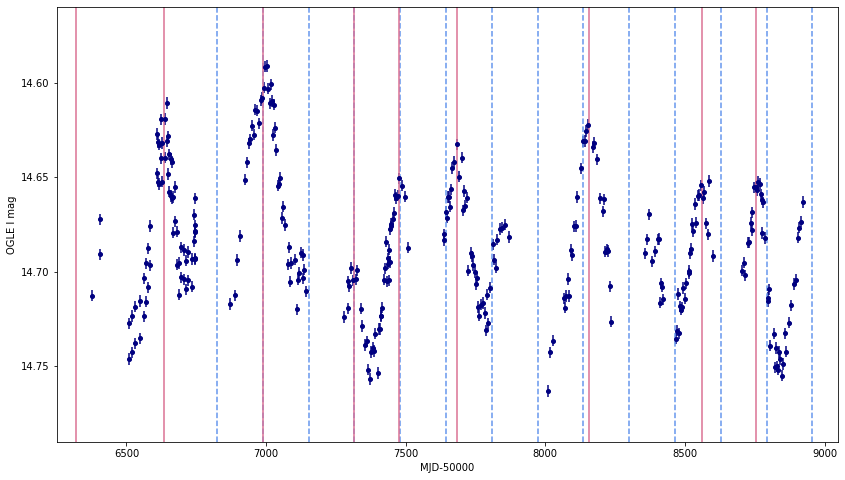

In [363]:
plt.figure(figsize=(14,8))
plt.errorbar(r2['MJD-50000'],r2['I detrend 2'],yerr=r2['I mag err'],marker='o',markersize=4,linestyle='None',color='navy')
plt.ylim(14.75+.04,14.52+.04)
for i in range(-1,13):
    plt.axvline(centers[6]+164*i,0,1,color='cornflowerblue',linestyle='dashed') #predicted
for j in range(4,len(centers)):
    plt.axvline(centers[j],0,1,color='palevioletred')
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')

Text(0.5, 1.0, '171 Day Period, Starting From 6630d')

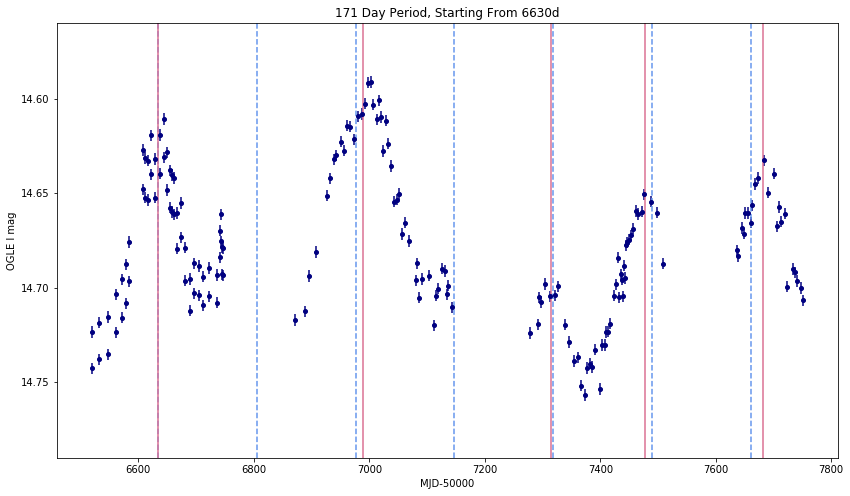

In [364]:
plt.figure(figsize=(14,8))
plt.errorbar(r3['MJD-50000'],r3['I detrend 2'],yerr=r3['I mag err'],marker='o',markersize=4,linestyle='None',color='navy')
plt.ylim(14.75+.04,14.52+.04)
for i in range(7):
    plt.axvline(centers[5]+171*i,0,1,linestyle='dashed',color='cornflowerblue')
#for i in range(1,3):
    #plt.axvline(7315+170*i,0,1,color='navy')
for j in range(4,9):
    plt.axvline(centers[j+1],0,1,color='palevioletred')
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
plt.title('171 Day Period, Starting From 6630d')

## Best Periods Still 150 and 201?
> maybe 199 or 200?

In [365]:
centers

array([5502.75971879, 5654.80000132, 5797.75329703, 5960.2006646 ,
       6318.03954066, 6634.39651542, 6988.81060193, 7314.20106245,
       7477.07563141, 7682.40427138, 8157.06283888, 8559.40489096,
       8753.88179913])

In [366]:
oc1 = ((centers[-3]+199*2)-centers[11])**2
oc2 = ((centers[-3]+199*3)-centers[12])**2
print(oc1+oc2)
oc1 = ((centers[-3]+200*2)-centers[11])**2
oc2 = ((centers[-3]+200*3)-centers[12])**2
print(oc1+oc2)
oc1 = ((centers[-3]+201*2)-centers[11])**2
oc2 = ((centers[-3]+201*3)-centers[12])**2
print(oc1+oc2)
oc1 = ((centers[-3]+202*2)-centers[11])**2
oc2 = ((centers[-3]+202*3)-centers[12])**2
print(oc1+oc2)

18.886191705228935
15.604221847866807
38.322251990504675
87.04028213314255


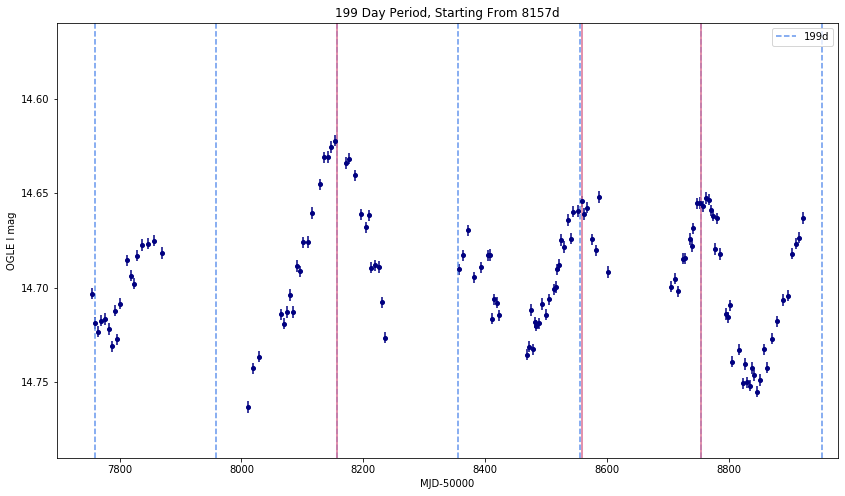

In [367]:
plt.figure(figsize=(14,8))
plt.errorbar(r4['MJD-50000'],r4['I detrend 2'],yerr=r4['I mag err'],marker='o',markersize=4,linestyle='None',color='navy')
plt.ylim(14.75+.04,14.52+.04)
for i in range(-1,5):
    plt.axvline(centers[-3]+199*i,0,1,linestyle='dashed',color='cornflowerblue')
plt.axvline(centers[-3]+199*(-2),0,1,linestyle='dashed',color='cornflowerblue',label='199d')
#for i in range(1,3):
    #plt.axvline(7315+170*i,0,1,color='navy')
for j in range(10,len(centers)):
    plt.axvline(centers[j],0,1,color='palevioletred')
#plt.axvline(centers[7],0,1,color='palevioletred',label='Gaussian Center')
plt.legend()
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
plt.title('199 Day Period, Starting From 8157d')
plt.savefig('199r4.png',dpi=200,bbox_inches='tight')

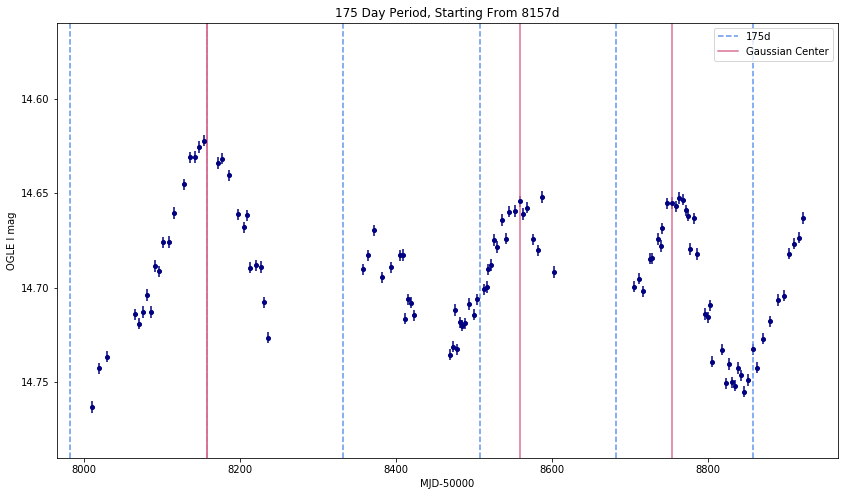

In [368]:
plt.figure(figsize=(14,8))
plt.errorbar(reg3['MJD-50000'],reg3['I detrend 2'],yerr=reg3['I mag err'],marker='o',markersize=4,linestyle='None',color='navy')
plt.ylim(14.75+.04,14.52+.04)
for i in range(-1,5):
    plt.axvline(centers[-3]+175*i,0,1,linestyle='dashed',color='cornflowerblue')
plt.axvline(centers[-3],0,1,linestyle='dashed',color='cornflowerblue',label='175d')
#for i in range(1,3):
    #plt.axvline(7315+170*i,0,1,color='navy')
for j in range(10,len(centers)):
    plt.axvline(centers[j],0,1,color='palevioletred')
plt.axvline(centers[10],0,1,color='palevioletred',label='Gaussian Center')
plt.legend()
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
plt.title('175 Day Period, Starting From 8157d')
plt.savefig('175reg3.png',dpi=200,bbox_inches='tight')

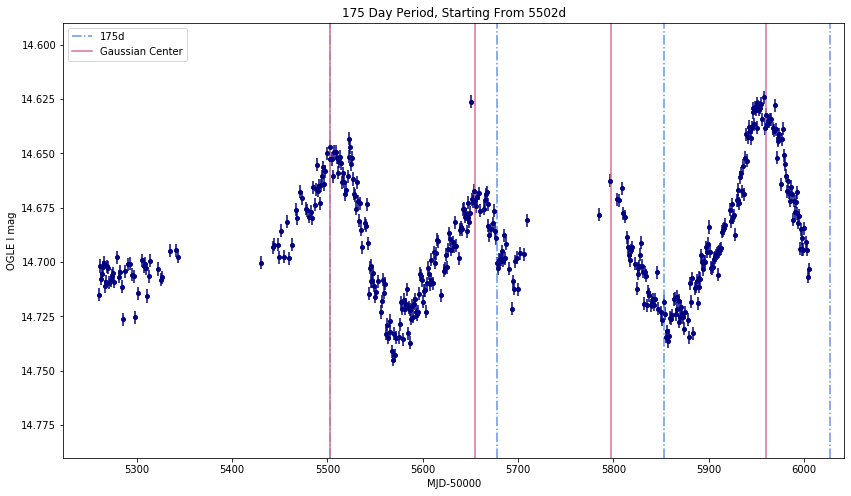

In [369]:
#r1 but with Gaussian lines
plt.figure(figsize=(14,8))
plt.errorbar(reg1['MJD-50000'],reg1['I detrend 2'],yerr=reg1['I mag err'],marker='o',markersize=4,linestyle='None',color='navy')
plt.ylim(14.75+.04,14.55+.04)
plt.axvline(centers[0],0,1,linestyle='-.',color='cornflowerblue',label='175d')
for i in range(1,4):
    plt.axvline(centers[0]+175*i,0,1,linestyle='-.',color='cornflowerblue')
for j in range(1,4):
    plt.axvline(centers[j],0,1,color='palevioletred')
plt.axvline(centers[0],0,1,color='palevioletred',label='Gaussian Center')
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
plt.title('175 Day Period, Starting From 5502d')
plt.legend()
#plt.savefig('175reg1.png',dpi=200,bbox_inches='tight')

In [370]:
#simple O-C for each epoch
oc1 = ((centers[0]+149)-centers[1])**2
oc2 = ((centers[0]+149*2)-centers[2])**2
oc3 = ((centers[0]+149*3)-centers[3])**2
print(oc1+oc2+oc3)

oc1 = ((centers[0]+150)-centers[1])**2
oc2 = ((centers[0]+150*2)-centers[2])**2
oc3 = ((centers[0]+150*3)-centers[3])**2
print(oc1+oc2+oc3)

oc1 = ((centers[0]+151)-centers[1])**2
oc2 = ((centers[0]+151*2)-centers[2])**2
oc3 = ((centers[0]+151*3)-centers[3])**2
print(oc1+oc2+oc3)

oc1 = ((centers[0]+152)-centers[1])**2
oc2 = ((centers[0]+152*2)-centers[2])**2
oc3 = ((centers[0]+152*3)-centers[3])**2
print(oc1+oc2+oc3)

oc1 = ((centers[0]+153)-centers[1])**2
oc2 = ((centers[0]+153*2)-centers[2])**2
oc3 = ((centers[0]+153*3)-centers[3])**2
print(oc1+oc2+oc3)

oc1 = ((centers[0]+154)-centers[1])**2
oc2 = ((centers[0]+154*2)-centers[2])**2
oc3 = ((centers[0]+154*3)-centers[3])**2
print(oc1+oc2+oc3)

oc1 = ((centers[0]+155)-centers[1])**2
oc2 = ((centers[0]+155*2)-centers[2])**2
oc3 = ((centers[0]+155*3)-centers[3])**2
print(oc1+oc2+oc3)

127.2952391011133
84.59468619064702
69.89413328018074
83.19358036971444
124.49302745924815
193.79247454878188
291.09192163831557


> we have 200 in the third epoch and 151
- but let's make regime plot again with these values
- periodogram best 149, 171 or 172, 200

- **put O-C function up above and do each with that, but this is good check for now**

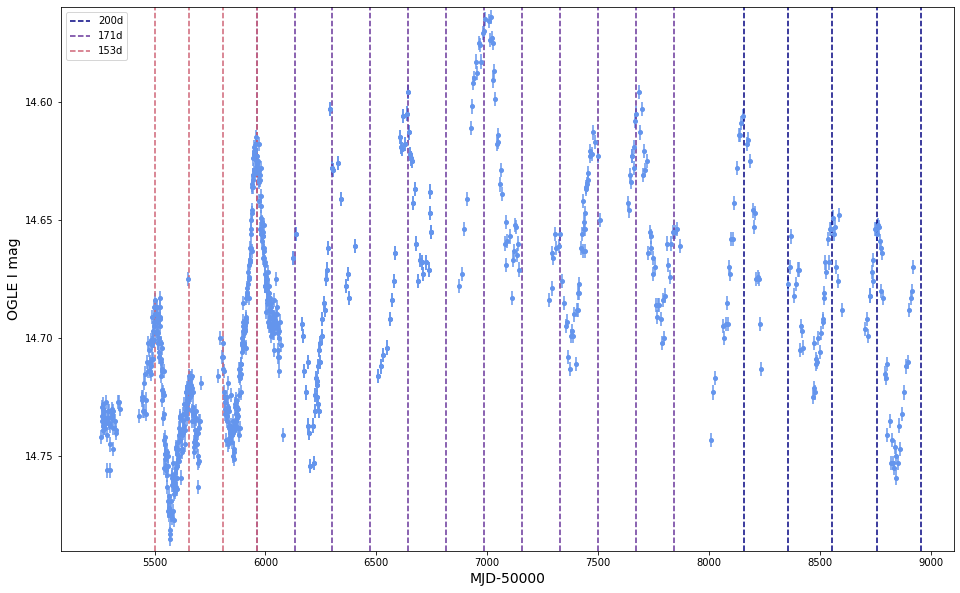

In [371]:
plt.figure(figsize=(16,10))
plt.errorbar(sog4['MJD-50000'],sog4['I mag'],yerr=sog4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
plt.ylim(14.75+.04,14.52+.04)
plt.axvline(centers[-3],0,1,linestyle='dashed',color=c2,label='200d')
for i in range(1,5):
    plt.axvline(centers[-3]+200*i,0,1,linestyle='dashed',color=c2)
plt.axvline(centers[3],0,1,linestyle='dashed',color=c3,label='171d')
for i in range(1,12):
    plt.axvline(centers[3]+171*i,0,1,linestyle='dashed',color=c3)
plt.axvline(centers[0],0,1,linestyle='dashed',color=c4,label='153d')
for i in range(1,4):
    plt.axvline(centers[0]+153*i,0,1,linestyle='dashed',color=c4)
#for i in range(len(flaremid)):
    #plt.axvline(flaremid[i],0,1,color=c3)

#for j in range(10,len(flaremid)):
    #plt.axvline(flaremid[j],0,1,color='palevioletred')
plt.xlabel('MJD-50000',fontsize=14)
plt.ylabel('OGLE I mag',fontsize=14)
plt.legend()
plt.savefig('3pdsalldatg.png',dpi=300,bbox_inches='tight')

# 12. Plot Flare # vs. Time
look for trend we can fit rather than using three regimes
using error of 10 days on flare centers

In [372]:
#used plot to find numbering of flares for which we have Gaussian-fit centers
flarenum = [0,1,2,3,5,7,9,11,12,13,15,17,18] #can't even be sure around 11 and 15

In [373]:
def parabola(x, a, b, c):
    x = np.array(x)
    return a*x**2 + b*x + c

In [374]:
fit_params, pcov = scipy.optimize.curve_fit(parabola, flarenum, centers)
fit_params

array([2.10058018e+00, 1.42339625e+02, 5.51457517e+03])

In [375]:
y_fit = parabola(flarenum, *fit_params)

In [376]:
#for linear fit, implying constant period
n = np.linspace(0,20)

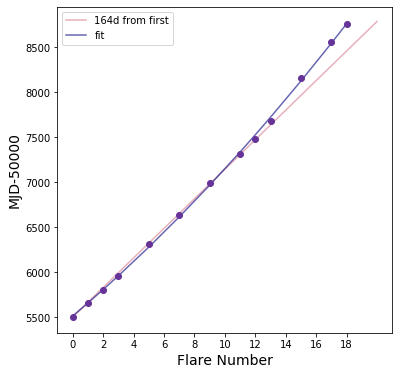

In [377]:
plt.figure(figsize = (6,6))
#flarenum = [0,1,3,5,7,9,11,12,13,15,17,18]
plt.plot(n,(164*n)+centers[0],color=c4,alpha=.5,label='164d from first')
#plt.plot(n,153*n+5501,color='palevioletred')
#plt.plot(n,(centers[-1]-flarenum[-1]*201)+201*x,color='navy',linestyle='dashed',alpha=.5,label='201d from last')
plt.errorbar(flarenum,centers,yerr=10,color=c3,linestyle='none',marker='o')
plt.plot(flarenum, y_fit, color=c2,label='fit',alpha=.6)
plt.legend()
plt.xticks(np.arange(0,20,2))
plt.xlabel('Flare Number',fontsize=14)
plt.ylabel('MJD-50000',fontsize=14)
plt.savefig('parabtimenum.png',dpi=200,bbox_inches='tight')

In [378]:
flarenum = np.array(flarenum)

Text(0, 0.5, 'Observed Center - Calculated (164d Pd) Center')

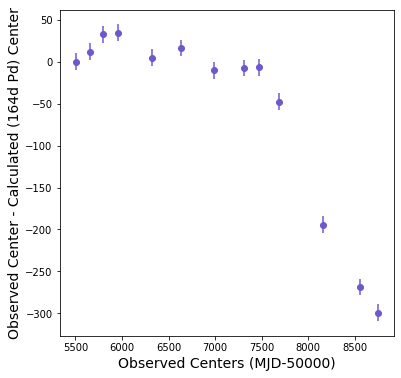

In [379]:
#O-C for 164 days
act_min_pred = [] #actual minus predicted using 164 days
i = 0
for f in flarenum:
    #print(mjd5cens[0]+164*f)
    #print (mjd5cens[i])
    act_min_pred.append(centers[0]+164*f - centers[i])
    i += 1
plt.figure(figsize=(6,6))
x = np.linspace(5500,8600)
plt.errorbar(centers,act_min_pred,xerr=10,yerr=10,linestyle='none',marker='o',color='slateblue')
plt.xlabel('Observed Centers (MJD-50000)',fontsize=14)
plt.ylabel('Observed Center - Calculated (164d Pd) Center',fontsize=14)

## Reverse Axes -- then fit can be used for phase-fold

In [380]:
fit_inv, icov = scipy.optimize.curve_fit(parabola, centers, flarenum)
inv_fit = parabola(centers, *fit_inv)
fit_inv

array([-3.55593414e-07,  1.05908660e-02, -4.75284216e+01])

In [381]:
f = np.linspace(0,20)
fm = 164*f+centers[0]

In [382]:
len(flarenum)

13

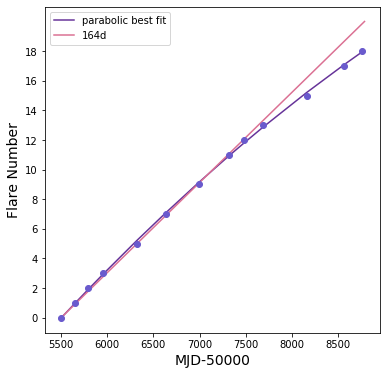

In [383]:
plt.figure(figsize = (6,6))
#plt.plot(n,(164*n)+centers[0],color='palevioletred',alpha=.5,label='164d from first')
#plt.plot(n,153*n+5501,color='palevioletred')
#plt.plot(n,(centers[-1]-flarenum[-1]*201)+201*x,color='navy',linestyle='dashed',alpha=.5,label='201d from last')
plt.plot(centers,inv_fit,color='rebeccapurple',label='parabolic best fit')
plt.errorbar(centers,flarenum,xerr=10,color='slateblue',linestyle='none',marker='o')
plt.yticks(np.arange(0,20,2))
plt.ylabel('Flare Number',fontsize=14)
plt.xlabel('MJD-50000',fontsize=14)
plt.plot(fm,f,color='palevioletred',label='164d')
plt.legend()
plt.savefig('invparabfit.png',dpi=200,bbox_inches='tight')

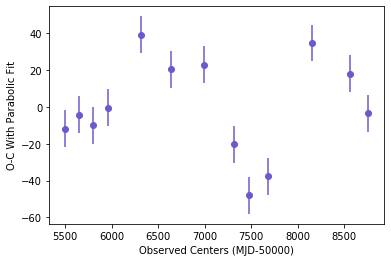

In [384]:
#O-C plot for parabolic fit
inv_fitm = inv_fit % 1
plt.errorbar(centers,centers-y_fit,xerr=10,yerr=10,linestyle='none',marker='o',color='slateblue')
plt.xlabel('Observed Centers (MJD-50000)')
plt.ylabel('O-C With Parabolic Fit')
plt.savefig('parabo-c.png',dpi=200,bbox_inches='tight')

In [385]:
shift_t = parabola(sog4['MJD-50000'],*fit_inv)
phase_t = shift_t%1

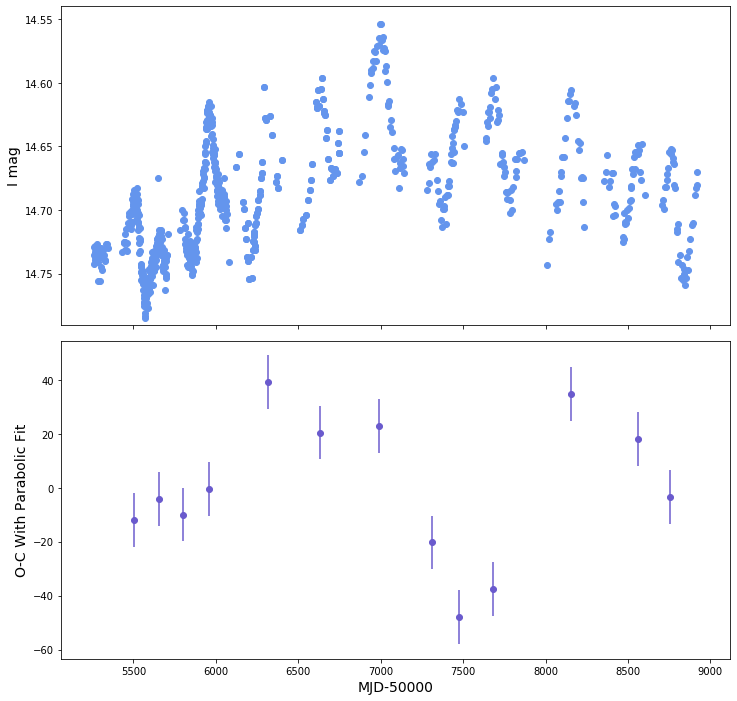

In [386]:
#O-C plot for parabolic fit
fig,ax = plt.subplots(2,1,figsize=(12,12),sharex=True)
inv_fitm = inv_fit % 1
ax[1].errorbar(centers,centers-y_fit,xerr=10,yerr=10,linestyle='none',marker='o',color='slateblue')
ax[1].set_ylabel('O-C With Parabolic Fit',fontsize=14)
ax[0].set_ylim(14.75+.04,14.5+.04)
plt.subplots_adjust(hspace=0.05)
ax[0].scatter(sog4['MJD-50000'],sog4['I mag'],color='cornflowerblue')
# for i in range(20):
#     ax[0].axvline(i,linestyle='dashed',color='slateblue')
ax[1].set_xlabel('MJD-50000',fontsize=14)
ax[0].set_ylabel('I mag',fontsize=14)

#ax[1].set_xlim(5000,9100)
plt.savefig('o-clc.png',dpi=200,bbox_inches='tight')

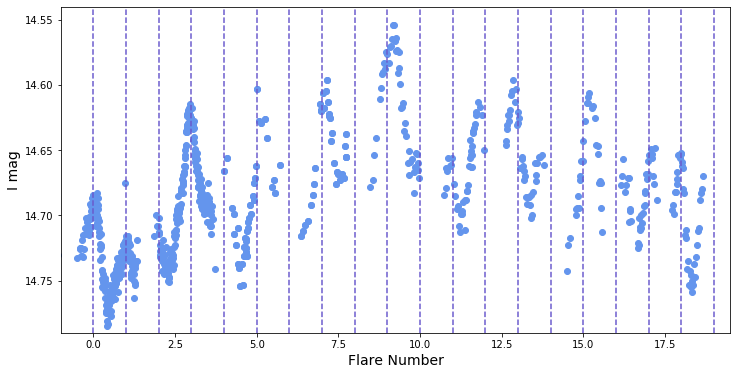

In [387]:
plt.figure(figsize=(12,6))
#plt.scatter(5500+180*shift_t,sog4['I mag'],color='cornflowerblue')
#for i in range(20):
    #plt.axvline(5500+180*i,linestyle='dashed',color='slateblue')
plt.scatter(shift_t,sog4['I mag'],color='cornflowerblue')
for i in range(20):
    plt.axvline(i,linestyle='dashed',color='slateblue')
plt.ylim(14.75+.04,14.5+.04)
plt.xlim(-1,19.5)
plt.xlabel('Flare Number',fontsize=14)
plt.ylabel('I mag',fontsize=14)
plt.savefig('magtshift.png',dpi=200,bbox_inches='tight')

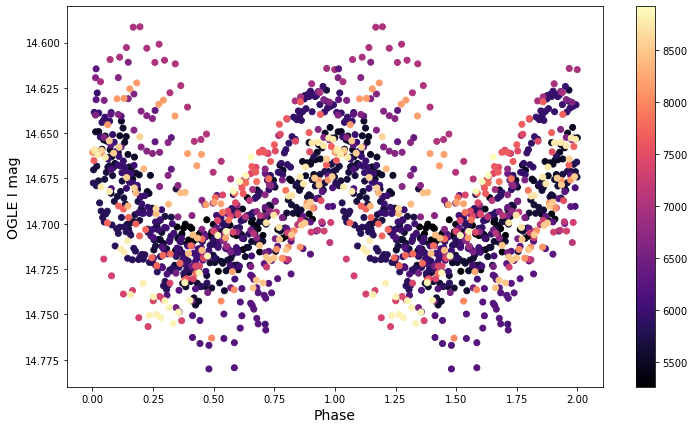

In [388]:
plt.figure(figsize=(12,7))
plt.ylim(14.75+.04,14.54+.04)
plt.scatter(phase_t,sog4['I detrend 2'],c=sog4['MJD-50000'],cmap='magma')
plt.scatter(1+phase_t,sog4['I detrend 2'],c=sog4['MJD-50000'],cmap='magma')
plt.ylabel('OGLE I mag',fontsize=14)
plt.xlabel('Phase',fontsize=14)
plt.colorbar()
plt.savefig('parabolicperiodcb.png',dpi=200,bbox_inches='tight')

### Trying With Higher-Order Polynomial

In [389]:
def third(x, a, b, c, d):
    x = np.array(x)
    return a*x**3 + b*x**2 + c*x + d

In [390]:
def fourth(x, a, b, c, d, e):
    x = np.array(x)
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

In [391]:
fit_inv2, icov2 = scipy.optimize.curve_fit(third, centers, flarenum)
fit_inv2

array([-4.71125298e-11,  6.53579309e-07,  3.47788083e-03, -3.10407070e+01])

In [392]:
#order three fit for o-c diagram
fit2, cov2 = scipy.optimize.curve_fit(third,flarenum,centers)
yfit2 = third(flarenum,*fit2)

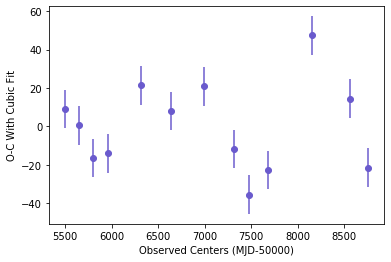

In [393]:
#O-C for order three fit
plt.errorbar(centers,centers-yfit2,xerr=10,yerr=10,linestyle='none',marker='o',color='slateblue')
plt.xlabel('Observed Centers (MJD-50000)')
plt.ylabel('O-C With Cubic Fit') #range of O-C not necessarily better
plt.savefig('cubico-c.png',dpi=200,bbox_inches='tight')

In [394]:
fit_inv3, icov3 = scipy.optimize.curve_fit(fourth, centers, flarenum)
fit_inv3

array([ 6.19700994e-14, -1.80737974e-09,  1.92437845e-05, -8.30268993e-02,
        1.18597309e+02])

In [395]:
shift_t2 = (third(sog4['MJD-50000'],*fit_inv2))%1

In [396]:
shift_t3 = (fourth(sog4['MJD-50000'],*fit_inv3))%1

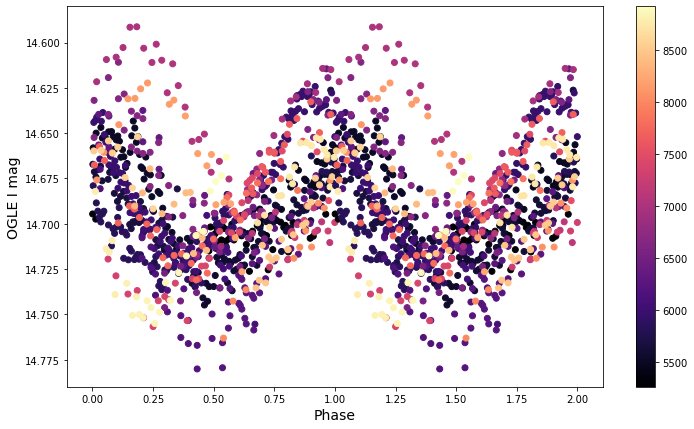

In [397]:
#order 3 polynomial fit
plt.figure(figsize=(12,7))
plt.ylim(14.75+.04,14.54+.04)
plt.scatter(shift_t2,sog4['I detrend 2'],c=sog4['MJD-50000'],cmap='magma')
plt.scatter(1+shift_t2,sog4['I detrend 2'],c=sog4['MJD-50000'],cmap='magma')
plt.ylabel('OGLE I mag',fontsize=14)
plt.xlabel('Phase',fontsize=14)
plt.colorbar()
plt.savefig('orderthreedet.png',dpi=200,bbox_inches='tight')

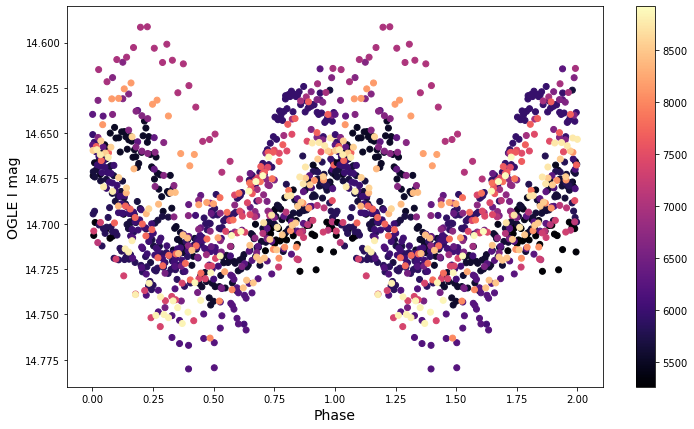

In [398]:
#order four
plt.figure(figsize=(12,7))
plt.ylim(14.75+.04,14.54+.04)
plt.scatter(shift_t3,sog4['I detrend 2'],c=sog4['MJD-50000'],cmap='magma')
plt.scatter(1+shift_t3,sog4['I detrend 2'],c=sog4['MJD-50000'],cmap='magma')
plt.ylabel('OGLE I mag',fontsize=14)
plt.xlabel('Phase',fontsize=14)
plt.colorbar()

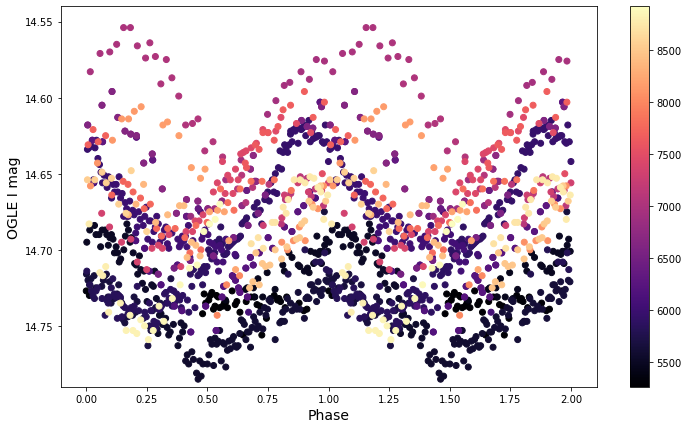

In [399]:
#order three fit
plt.figure(figsize=(12,7))
plt.ylim(14.75+.04,14.5+.04)
plt.scatter(shift_t2,sog4['I mag'],c=sog4['MJD-50000'],cmap='magma')
plt.scatter(1+shift_t2,sog4['I mag'],c=sog4['MJD-50000'],cmap='magma')
plt.ylabel('OGLE I mag',fontsize=14)
plt.xlabel('Phase',fontsize=14)
plt.colorbar()
plt.savefig('orderthree.png',dpi=200,bbox_inches='tight')

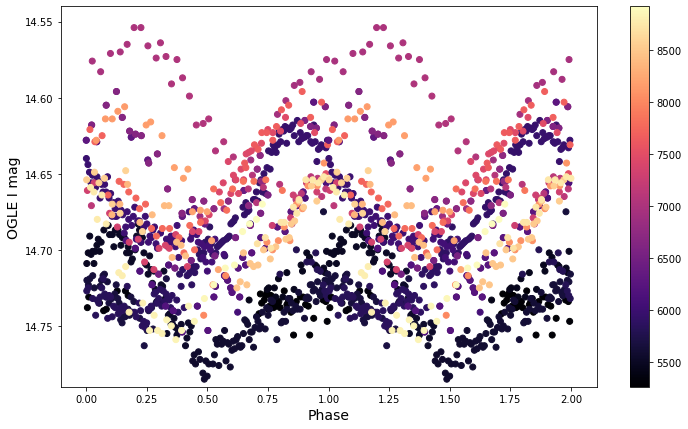

In [400]:
#order 4 fit
plt.figure(figsize=(12,7))
plt.ylim(14.75+.04,14.5+.04)
plt.scatter(shift_t3,sog4['I mag'],c=sog4['MJD-50000'],cmap='magma')
plt.scatter(1+shift_t3,sog4['I mag'],c=sog4['MJD-50000'],cmap='magma')
plt.ylabel('OGLE I mag',fontsize=14)
plt.xlabel('Phase',fontsize=14)
plt.colorbar()

In [401]:
consec = []
for f in range(1,len(flarenum)):
    if flarenum[f] == flarenum[f-1] + 1:
        consec.append(centers[f]-centers[f-1])
consec

[152.04028252798707,
 142.95329571578895,
 162.4473675694553,
 162.8745689611569,
 205.32863996495416,
 194.4769081667091]

# 13. Look At Recent Flares

In [402]:
centers[-1]-centers[-2]

194.4769081667091

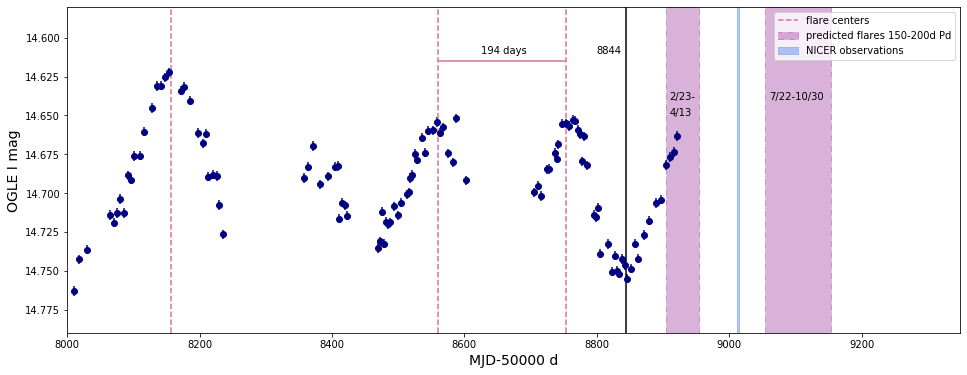

In [403]:
plt.figure(figsize=(16,6))
plt.errorbar(sog4['MJD-50000'],sog4['I detrend 2'],yerr=sog4['I mag err'],linestyle='none',marker='o',color='navy')
for c in centers[-2:]:
    plt.axvline(c,0,1,color='palevioletred',linestyle='dashed')
plt.axvline(centers[-3],0,1,color='palevioletred',linestyle='dashed',label='flare centers')
plt.axvspan(centers[-1]+150*1,centers[-1]+200*1,color='purple',alpha=.3,linestyle='-.',label='predicted flares 150-200d Pd')
plt.axvspan(centers[-1]+150*2,centers[-1]+200*2,color='purple',alpha=.3,linestyle='-.')

plt.text(8910,14.6+.04,'2/23-')
plt.text(8910,14.61+.04,'4/13')
plt.text(9061,14.6+.04,'7/22-10/30')
plt.axhline(14.575+.04,.417,.558,color='palevioletred')
plt.text(8625,14.57+.04,'194 days')
#plt.axvline(9015,0,1,color='lightcoral',label='Nicer Observations')
plt.axvspan(9012, 9015, alpha=0.5, color='cornflowerblue',label='NICER observations')
plt.axvline(8844,color='black')
plt.text(8800,14.57+.04,'8844')
plt.xlim(8000,)
plt.ylim(14.75+.04,14.54+.04)
plt.xlabel('MJD-50000 d',fontsize=14)
plt.ylabel('OGLE I mag',fontsize=14)
plt.legend()
plt.savefig('recentflares.png',dpi=300,bbox_inches='tight')

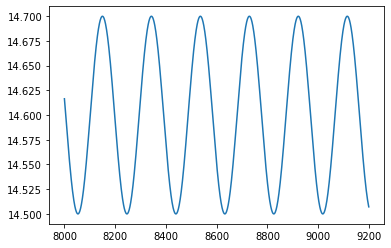

In [404]:
#including sine wave to guide eye
t = np.arange(8000,9200)
plt.plot(t,14.6+.1*np.sin(t/30.7))


(8000, 9000)

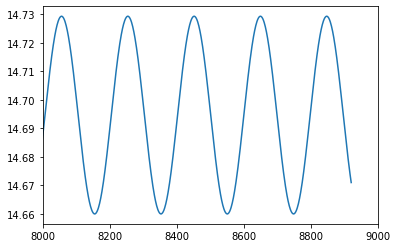

In [405]:
#do an actual sinusoidal fit
t_s = sog4['MJD-50000'][-120:]
t_fit = np.linspace(t_s.min(),t_s.max(),1000)
ls_fit = LombScargle(t_s, sog4['I detrend 2'][-120:], sog4['I mag err'][-120:]).model(t_fit, 1/198)
plt.plot(t_fit,ls_fit)
plt.xlim(8000,9000)

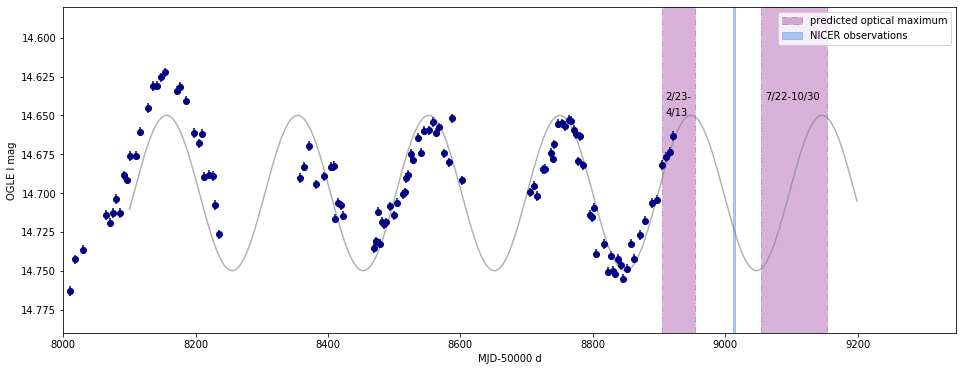

In [406]:
plt.figure(figsize=(16,6))
plt.errorbar(sog4['MJD-50000'],sog4['I detrend 2'],yerr=sog4['I mag err'],linestyle='none',marker='o',color='navy')
#for c in centers[-2:]:
    #plt.axvline(c,0,1,color='palevioletred',linestyle='dashed')
#plt.axvline(centers[-3],0,1,color='palevioletred',linestyle='dashed',label='flare centers')
plt.axvspan(centers[-1]+150*1,centers[-1]+200*1,color='purple',alpha=.3,linestyle='-.',label='predicted optical maximum')
plt.axvspan(centers[-1]+150*2,centers[-1]+200*2,color='purple',alpha=.3,linestyle='-.')

plt.text(8910,14.6+.04,'2/23-')
plt.text(8910,14.61+.04,'4/13')
plt.text(9061,14.6+.04,'7/22-10/30')
#plt.axhline(14.575,.417,.558,color='palevioletred')
#plt.text(8625,14.57,'193 days')
#plt.axvline(9015,0,1,color='lightcoral',label='Nicer Observations')
plt.axvspan(9012, 9015, alpha=0.5, color='cornflowerblue',label='NICER observations')

plt.xlim(8000,)
plt.ylim(14.75+.04,14.54+.04)
plt.xlabel('MJD-50000 d')
plt.ylabel('OGLE I mag')
plt.legend(loc='upper right')
#plt.savefig('annotatedrecentflares.png',dpi=300,bbox_inches='tight')
t = np.arange(8100,9200)
#plt.plot(t,14.66+.05*np.sin(4.8+t/31.67183367528717),color='grey',alpha=.6)
plt.plot(t,14.7+.05*np.sin(3.5+t/31.512678732195276),color='grey',alpha=.6)
#plt.plot(t,14.66+.05*np.sin(2.2+t/31.35352378910338),color='grey',alpha=.6)


#plt.plot(t,14.66+.05*np.sin(2.3+t/31.990143561470965),color='grey',linestyle='dashed')
#plt.plot(t_fit,ls_fit,color='black',alpha=.5) #fit by LombScargle
plt.savefig('OGLEsine198.png',dpi=300,bbox_inches='tight')


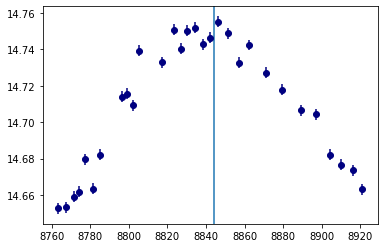

In [407]:
#find center of last minimum
plt.errorbar(sog4['MJD-50000'][-30:],sog4['I detrend 2'][-30:],yerr=sog4['I mag err'][-30:],linestyle='none',marker='o',color='navy')
#plt.xlim(8800,9000)
plt.axvline(8844)

In [408]:
#fit Gaussian to last minimum
x = load_sog4[-30:,4]
y = load_sog4[-30:,5]
mod = GaussianModel()
pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)
out.params['center'].value

8844.535455270005

171 days between last minimum and NICER observations

In [409]:
9015-8844

171

In [410]:
centers[-3]+199*5 #October 29 2020

9152.062838878988

In [411]:
centers[-1]+200*2 #doesn't matter where you set it, still around same time October

9153.881799131408

In [412]:
centers[-1]+200

8953.881799131408

In [413]:
centers[-1]+164*2 #August 19th 2020

9081.881799131408

In [414]:
centers[-1]+150*2 #even 153 days gives July 28th!

9053.881799131408

In [415]:
9012-centers[-1]

258.1182008685919

# 14. O-C for Each Regime
can now just go linearly starting from outs, based on how model changed

In [416]:
from uncertainties import ufloat

In [417]:
def gerrors(pd,st,end,inds):
    #index of start of prediction (one before first that's predicted)
    #predictions go from center that's fixed
    pred = np.arange(centers[st-1],centers[end]+5,pd)
    #actual start to end in centers
    actual = centers[st:end]
    errs=[]
    for i in range(len(inds)):
        act = actual[i]
        err = actual[i]-pred[inds[i]] #switching to actual - predicted
        errs.append(err)
    #print(np.abs(np.mean(errs)))
    return errs

In [418]:
centers[3]

5960.200664601158

In [419]:
pred

array([8155, 8360, 8565, 8770, 8975])

In [420]:
err151 = gerrors(151,1,4,[1,2,3]) #first, second, third flares
err171 = gerrors(171,4,10,[2,4,6,8,9,10])
pred = np.arange(centers[10],centers[-1]+100,201) #predictions for last two centers
actual = centers[11:] #last three centers
errs201 = []
inds = [2,3]
for i in range(len(inds)):
    err = actual[i]-pred[inds[i]]
    errs201.append(err)
errs201

[0.34205208571074763, -6.181039747581963]

In [421]:
#checked that 200 is best
pred = np.arange(centers[10],centers[-1]+100,200) #predictions for last two centers
actual = centers[11:] #last three centers
errs200 = []
inds = [2,3]
for i in range(len(inds)):
    err = actual[i]-pred[inds[i]]
    errs200.append(err)
print(errs200)
#print(np.sum(np.array(errs200)**2))
chi200 = np.sum(np.array(errs200)**2/100) #square of error
print(chi200)

[2.3420520857107476, -3.1810397475819627]
0.1560422184787838


In [422]:
err170 = gerrors(170,4,10,[2,4,6,8,9,10])
err170

[17.838876059005997,
 -5.804149185700226,
 8.609937328139495,
 -5.9996021502092844,
 -13.125033189052374,
 22.20360677590179]

In [423]:
err171

[15.838876059005997,
 -9.804149185700226,
 2.6099373281394946,
 -13.999602150209284,
 -22.125033189052374,
 12.20360677590179]

In [424]:
err151

[1.040282527987074, -7.006421756223972, 4.4409458132313375]

In [425]:
errs153 = gerrors(153,1,4,[1,2,3])
errs153

[-0.959717472012926, -11.006421756223972, -1.5590541867686625]

In [426]:
#testing for second regime
err170 = gerrors(170,4,10,[2,4,6,8,9,10])
print(err170,np.abs(np.mean(err170)))

[17.838876059005997, -5.804149185700226, 8.609937328139495, -5.9996021502092844, -13.125033189052374, 22.20360677590179] 3.953939273014233


In [427]:
#WON'T WORK LINEARLY SINCE GFITS DEFINED AT END
def chis(pd,st,end,inds,exp=False,cenerr=False):
    #index of start of prediction (one before first that's predicted)
    #predictions go from center that's fixed
    pred = np.arange(centers[st-1],centers[end]+5,pd)
    #actual start to end in centers
    actual = centers[st:end]
    if cenerr: act_err = gfits['center err'][st:end] #use errors on centers from Gaussian model
    else: ae = 10 #ten day error
    #print('act err:',act_err)
    chi=[]
    for i in range(len(inds)):
        act = actual[i]
        #print('actual:',act)
        #print('pred:',pred[inds[i]])
        #c = (actual[i]-pred[inds[i]])**2/pred[inds[i]]
        #ae = np.array(act_err[i:i+1])
        #print('act error:',ae)
        if exp: c = (actual[i]-pred[inds[i]])**2/pred[inds[i]] #use expected in denominator
        else: c = ((actual[i]-pred[inds[i]])/ae)**2
        #print('chi:',c)
        chi.append(c)
    chi = np.array(chi)
    #print(chi)
    return np.sum(chi)

In [428]:
#170 is just barely best with chi squared
print(chis(169,4,10,[2,4,6,8,9,10]))
print('170:',chis(170,4,10,[2,4,6,8,9,10]))
print(chis(171,4,10,[2,4,6,8,9,10]))
print(chis(172,4,10,[2,4,6,8,9,10]))
print(chis(175,4,10,[2,4,6,8,9,10]))
chi170 = chis(170,4,10,[2,4,6,8,9,10])

16.683760060461665
170: 11.27306543646326
11.882370812464853
18.511676188466446
74.51959231647122


In [429]:
print(chis(149,1,4,[1,2,3]))
print(chis(150,1,4,[1,2,3]))
print('151:',chis(151,1,4,[1,2,3]))
print(chis(152,1,4,[1,2,3]))
print(chis(153,1,4,[1,2,3]))
chi151 = chis(151,1,4,[1,2,3])

1.2729523910111329
0.8459468619064702
151: 0.6989413328018073
0.8319358036971445
1.2449302745924815


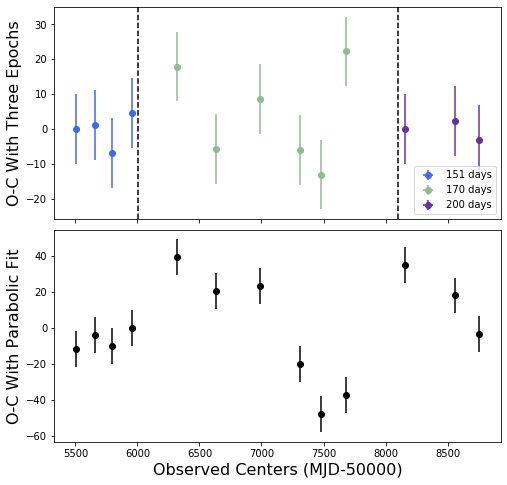

In [430]:
#stack two O-C plots
#put after chi squared final answer -- or move chi s up
fig,ax=plt.subplots(2,1,figsize=(8,8),sharex=True)
plt.subplots_adjust(hspace=.05)
ax[0].errorbar((centers[1],centers[2],centers[3]),err151,linestyle='none',xerr=10,yerr=10,marker='o',color='royalblue',label='151 days')
ax[0].errorbar((centers[0]),0,xerr=10,yerr=10,linestyle='none',marker='o',color='royalblue')

ax[0].errorbar(centers[4:10],err170,linestyle='none',xerr=10,yerr=10,marker='o',color='darkseagreen',label='170 days')
ax[0].errorbar(centers[10],0,xerr=10,yerr=10,linestyle='none',marker='o',color='rebeccapurple')

ax[0].errorbar(centers[11:],errs200,linestyle='none',xerr=10,yerr=10,marker='o',color='rebeccapurple',label='200 days')
ax[0].axvline(6006,linestyle='dashed',color='black')
ax[0].axvline(8101,linestyle='dashed',color='black')
ax[0].legend(loc='lower right')


ax[1].errorbar(centers,centers-y_fit,xerr=10,yerr=10,linestyle='none',marker='o',color='black')
ax[1].set_xlabel('Observed Centers (MJD-50000)',fontsize=16)
ax[1].set_ylabel('O-C With Parabolic Fit',fontsize=16)
ax[0].set_ylabel('O-C With Three Epochs',fontsize=16)

png('bothoc')

In [431]:
#try reduced chi squared
rcs = (chi151+chi170+chi200)/(13-5) #13 flares, five parameters?
rcs 

1.5160061234679814

In [432]:
#parabola chi
parabchi = np.sum(((centers-y_fit)/10)**2) #chi squared for changing period
print(parabchi)
print(parabchi/(13-2))

84.24624400506043
7.658749455005494


# make sure chi squared minimized

### summary of chi squared
- verify degrees of freedom and error
- will have to manually do chi squared coding for each centers iteration
- 1.5 and 7.7 are the reduced values with latest

In [433]:
outs[0].params

Parameters([('amplitude',
             <Parameter 'amplitude', value=17.431662865924242 +/- 0.449, bounds=[-inf:inf]>),
            ('center',
             <Parameter 'center', value=5502.759718787926 +/- 1.07, bounds=[-inf:inf]>),
            ('sigma',
             <Parameter 'sigma', value=48.39647247550032 +/- 1.42, bounds=[0.0:inf]>),
            ('fwhm',
             <Parameter 'fwhm', value=113.96498131475767 +/- 3.35, bounds=[-inf:inf], expr='2.3548200*sigma'>),
            ('height',
             <Parameter 'height', value=0.14369286274070572 +/- 0.00144, bounds=[-inf:inf], expr='0.3989423*amplitude/max(2.220446049250313e-16, sigma)'>)])

## new best periods
> If we're just going based on Gaussian centers, we need to re-establish the best periods within each regime, even if the error is a couple of days
- 151,170,200

# 15. If Most Recent Flare Super Flare

Text(0, 0.5, 'OGLE I mag')

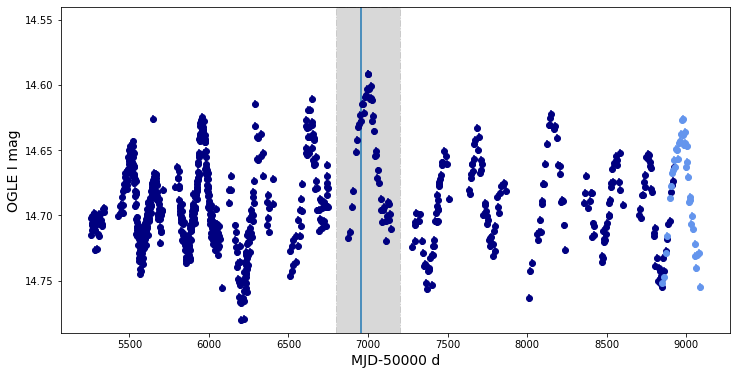

In [434]:
#if shifted down and left
plt.figure(figsize=(12,6))
plt.errorbar(sog4['MJD-50000'],sog4['I detrend 2'],yerr=sog4['I mag err'],linestyle='none',marker='o',color='navy')

plt.axvspan(6800,7200,color='grey',alpha=.3,linestyle='-.')
plt.errorbar(sog4['MJD-50000'][612:650]+1975,sog4['I detrend 2'][612:650]+.035,yerr=sog4['I mag err'][612:650],linestyle='none',marker='o',color='cornflowerblue')
plt.axvline(6956)#where last observation was?
plt.ylim(14.75+.04,14.5+.04)
plt.xlabel('MJD-50000 d',fontsize=14)
plt.ylabel('OGLE I mag',fontsize=14)

<ErrorbarContainer object of 3 artists>

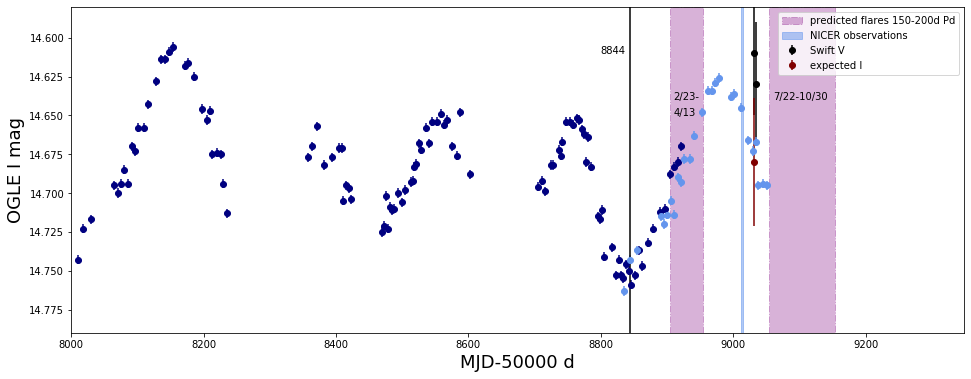

In [435]:
#recent wide flare moved
plt.figure(figsize=(16,6))
plt.errorbar(sog4['MJD-50000'],sog4['I mag'],yerr=sog4['I mag err'],linestyle='none',marker='o',color='navy')
# for c in centers[-2:]:
#     plt.axvline(c,0,1,color='palevioletred',linestyle='dashed')
# plt.axvline(centers[-3],0,1,color='palevioletred',linestyle='dashed',label='flare centers')
plt.axvspan(centers[-1]+150*1,centers[-1]+200*1,color='purple',alpha=.3,linestyle='-.',label='predicted flares 150-200d Pd')
plt.axvspan(centers[-1]+150*2,centers[-1]+200*2,color='purple',alpha=.3,linestyle='-.')

plt.text(8910,14.6+.04,'2/23-')
plt.text(8910,14.61+.04,'4/13')
plt.text(9061,14.6+.04,'7/22-10/30')
#plt.axhline(14.575,.417,.558,color='palevioletred')
#plt.text(8625,14.57,'193 days')
#plt.axvline(9015,0,1,color='lightcoral',label='Nicer Observations')
plt.axvspan(9012, 9015, alpha=0.5, color='cornflowerblue',label='NICER observations')
plt.axvline(8844,color='black')
plt.text(8800,14.57+.04,'8844')
plt.xlim(8000,)
plt.ylim(14.75+.04,14.54+.04)
plt.errorbar(9031,14.61,color='black',yerr=.04,linestyle='none',marker='o',label='Swift V')
plt.errorbar(9035,14.63,color='black',yerr=.04,linestyle='none',marker='o')

plt.errorbar(9031,14.68,color='maroon',yerr=.041,linestyle='none',marker='o',label='expected I')
plt.xlabel('MJD-50000 d',fontsize=18)
plt.ylabel('OGLE I mag',fontsize=18)
plt.legend(loc='upper right')
plt.errorbar(sog4['MJD-50000'][743:770]+825,sog4['I mag'][743:770]+.02,yerr=sog4['I mag err'][743:770],linestyle='none',marker='o',color='cornflowerblue')



<ErrorbarContainer object of 3 artists>

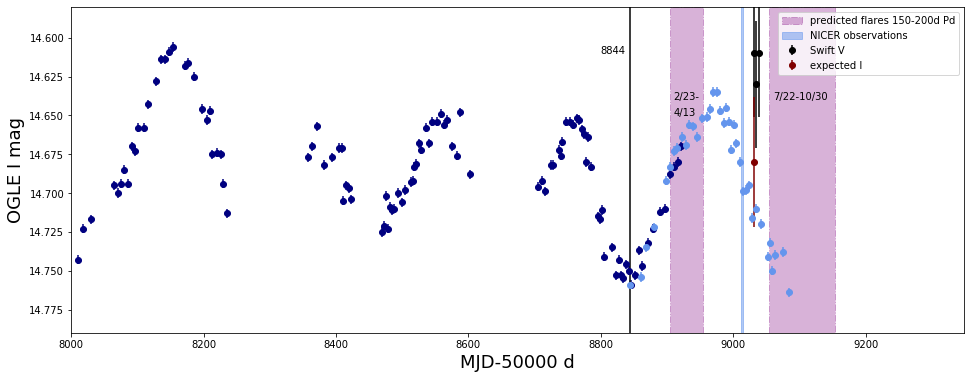

In [436]:
#shifting middle wide flare
plt.figure(figsize=(16,6))
plt.errorbar(sog4['MJD-50000'],sog4['I mag'],yerr=sog4['I mag err'],linestyle='none',marker='o',color='navy')
# for c in centers[-2:]:
#     plt.axvline(c,0,1,color='palevioletred',linestyle='dashed')
# plt.axvline(centers[-3],0,1,color='palevioletred',linestyle='dashed',label='flare centers')
plt.axvspan(centers[-1]+150*1,centers[-1]+200*1,color='purple',alpha=.3,linestyle='-.',label='predicted flares 150-200d Pd')
plt.axvspan(centers[-1]+150*2,centers[-1]+200*2,color='purple',alpha=.3,linestyle='-.')

plt.text(8910,14.6+.04,'2/23-')
plt.text(8910,14.61+.04,'4/13')
plt.text(9061,14.6+.04,'7/22-10/30')
#plt.axhline(14.575,.417,.558,color='palevioletred')
#plt.text(8625,14.57,'193 days')
#plt.axvline(9015,0,1,color='lightcoral',label='Nicer Observations')
plt.axvspan(9012, 9015, alpha=0.5, color='cornflowerblue',label='NICER observations')
plt.axvline(8844,color='black')
plt.text(8800,14.57+.04,'8844')
plt.xlim(8000,)
plt.ylim(14.75+.04,14.54+.04)
plt.errorbar(9031,14.61,color='black',yerr=.041,linestyle='none',marker='o',label='Swift V')
plt.errorbar(9035,14.63,color='black',yerr=.041,linestyle='none',marker='o')
plt.errorbar(9039,14.61,color='black',yerr=.041,linestyle='none',marker='o')

plt.errorbar(9031,14.68,color='maroon',yerr=.042,linestyle='none',marker='o',label='expected I')
#plt.errorbar(9035,14.70,color='maroon',yerr=.041,linestyle='none',marker='o')

plt.xlabel('MJD-50000 d',fontsize=18)
plt.ylabel('OGLE I mag',fontsize=18)
plt.legend(loc='upper right')
plt.errorbar(sog4['MJD-50000'][612:650]+1972.56257,sog4['I mag'][612:650]+.081,yerr=sog4['I mag err'][612:650],linestyle='none',marker='o',color='cornflowerblue')
#png('superflare4')

(13.33, 13.22)

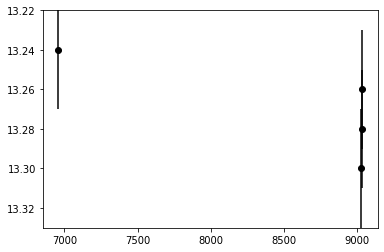

In [437]:
#plot of changing U mag
plt.errorbar([6956,9031,9035.18,9039.03],[13.24,13.3,13.26,13.28],yerr=.03,linestyle='none',marker='o',color='black')
plt.ylim(13.33,13.22)
#plt.xlim(8900,9100)

# 15. Remove Middle Wide Flare Before Phase-Fold

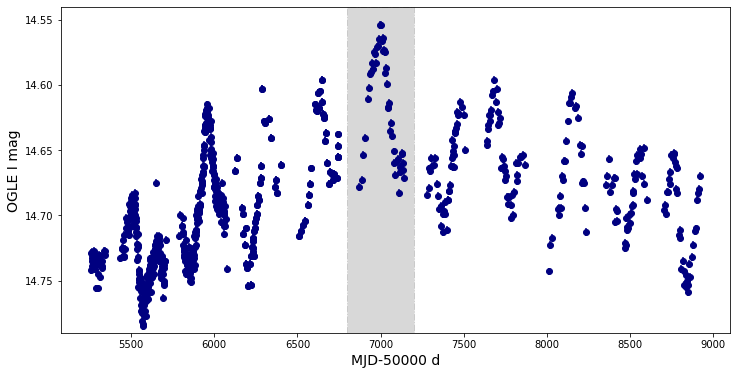

In [438]:
plt.figure(figsize=(12,6))
plt.errorbar(sog4['MJD-50000'],sog4['I mag'],yerr=sog4['I mag err'],linestyle='none',marker='o',color='navy')

plt.axvspan(6800,7200,color='grey',alpha=.3,linestyle='-.')

plt.ylim(14.75+.04,14.5+.04)
plt.xlabel('MJD-50000 d',fontsize=14)
plt.ylabel('OGLE I mag',fontsize=14)
plt.savefig('fullcurveshaded.png',dpi=200,bbox_inches='tight')

Text(0, 0.5, 'OGLE I mag')

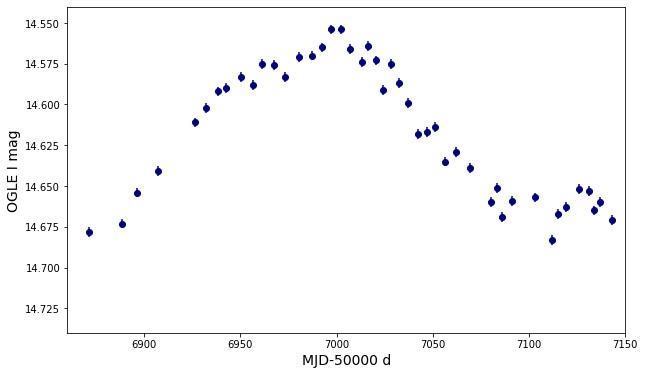

In [439]:
#plot of middle flare, not saved right now
plt.figure(figsize=(10,6))
plt.errorbar(sog4['MJD-50000'],sog4['I mag'],yerr=sog4['I mag err'],linestyle='none',marker='o',color='navy')

plt.xlim(6860,7150)
plt.ylim(14.7+.04,14.5+.04)
plt.xlabel('MJD-50000 d',fontsize=14)
plt.ylabel('OGLE I mag',fontsize=14)

In [440]:
sogf = pd.concat((sog4[:612],sog4[651:])) #filtered sog4
firstpart = phase_t[:612]
thirdpart = phase_t[651:]
phase_f = np.concatenate((firstpart,thirdpart))

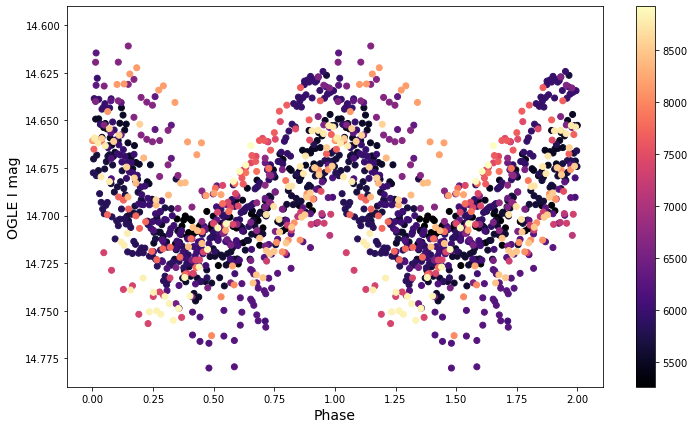

In [441]:
plt.figure(figsize=(12,7))
plt.ylim(14.75+.04,14.55+.04)
plt.scatter(phase_f,sogf['I detrend 2'],c=sogf['MJD-50000'],cmap='magma')
plt.scatter(1+phase_f,sogf['I detrend 2'],c=sogf['MJD-50000'],cmap='magma')
plt.ylabel('OGLE I mag',fontsize=14)
plt.xlabel('Phase',fontsize=14)
plt.colorbar()

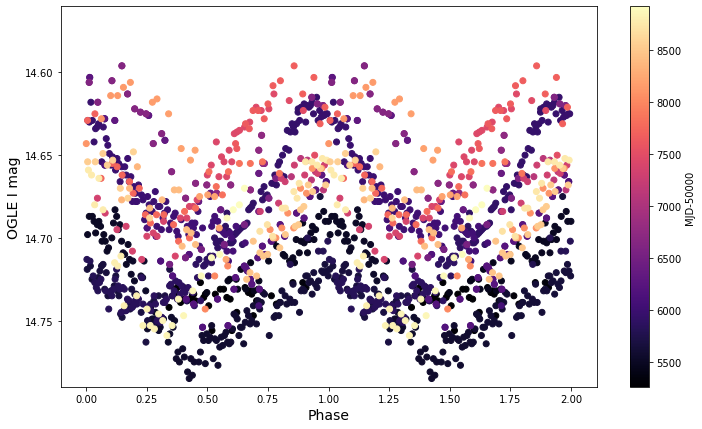

In [442]:
#same but detrended
plt.figure(figsize=(12,7))
plt.ylim(14.75+.04,14.52+.04)
plt.scatter(phase_f,sogf['I mag'],c=sogf['MJD-50000'],cmap='magma')
plt.scatter(1+phase_f,sogf['I mag'],c=sogf['MJD-50000'],cmap='magma')
plt.ylabel('OGLE I mag',fontsize=14)
plt.xlabel('Phase',fontsize=14)
plt.colorbar(label='MJD-50000')

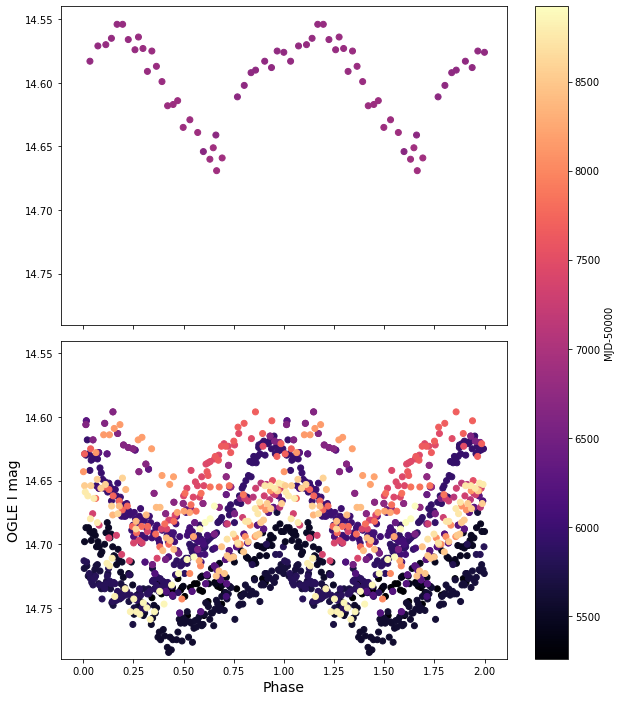

In [443]:
#is this the envisioned two-panel figure?
fig,ax=plt.subplots(2,1,figsize=(10,12),sharey=True,sharex=True)
#midphase = np.roll((sog4['MJD-50000'][612:650]-sog4['MJD-50000'][612])/(sog4['MJD-50000'][650]-sog4['MJD-50000'][612]),18)
#ax[0].scatter(midphase,sog4['I mag'][612:650],color='black')
#ax[0].scatter(1+midphase,sog4['I mag'][612:650],color='black')
#ax[0].scatter(sog4['MJD-50000'][612:650],sog4['I mag'][612:650],color='black')

#plotting fold just separately
im1=ax[0].scatter(phase_t[614:648],sog4['I mag'][614:648],c=sog4['MJD-50000'][614:648],cmap='magma',vmin=5540,vmax=9000)
im1=ax[0].scatter(1+phase_t[614:648],sog4['I mag'][614:648],c=sog4['MJD-50000'][614:648],cmap='magma',vmin=5540,vmax=9000)


ax[1].set_ylim(14.75+.04,14.5+.04)
plt.subplots_adjust(hspace=0.05)
im=ax[1].scatter(phase_f,sogf['I mag'],c=sogf['MJD-50000'],cmap='magma')
ax[1].scatter(1+phase_f,sogf['I mag'],c=sogf['MJD-50000'],cmap='magma')
ax[1].set_ylabel('OGLE I mag',fontsize=14)
ax[1].set_xlabel('Phase',fontsize=14)
fig.colorbar(im,ax=ax,label='MJD-50000')
png('sepflareor')

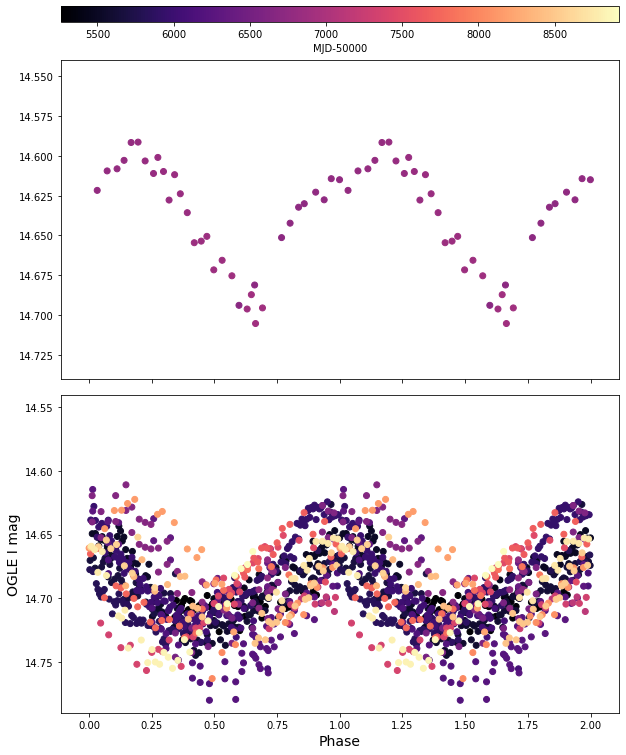

In [444]:
#is this the envisioned two-panel figure?
fig,ax=plt.subplots(2,1,figsize=(10,12),sharex=True)
#midphase = np.roll((sog4['MJD-50000'][612:650]-sog4['MJD-50000'][612])/(sog4['MJD-50000'][650]-sog4['MJD-50000'][612]),18)
#ax[0].scatter(midphase,sog4['I mag'][612:650],color='black')
#ax[0].scatter(1+midphase,sog4['I mag'][612:650],color='black')
#ax[0].scatter(sog4['MJD-50000'][612:650],sog4['I mag'][612:650],color='black')

#plotting fold just separately
im1=ax[0].scatter(phase_t[614:648],sog4['I detrend 2'][614:648],c=sog4['MJD-50000'][614:648],cmap='magma',vmin=5540,vmax=9000)
im1=ax[0].scatter(1+phase_t[614:648],sog4['I detrend 2'][614:648],c=sog4['MJD-50000'][614:648],cmap='magma',vmin=5540,vmax=9000)


ax[1].set_ylim(14.75+.04,14.5+.04)
plt.subplots_adjust(hspace=0.05)
im=ax[1].scatter(phase_f,sogf['I detrend 2'],c=sogf['MJD-50000'],cmap='magma')
ax[1].scatter(1+phase_f,sogf['I detrend 2'],c=sogf['MJD-50000'],cmap='magma')
ax[1].set_ylabel('OGLE I mag',fontsize=14)
ax[1].set_xlabel('Phase',fontsize=14)
ax[0].set_ylim(14.7+.04,14.5+.04)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax[0],
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='upper right',bbox_to_anchor=(0, .17, 1, 1),
                   bbox_transform=ax[0].transAxes,
                   borderpad=0,
                   )

fig.colorbar(im,cax=axins,label='MJD-50000',orientation='horizontal',pad=.08)
png('sepflaredet')

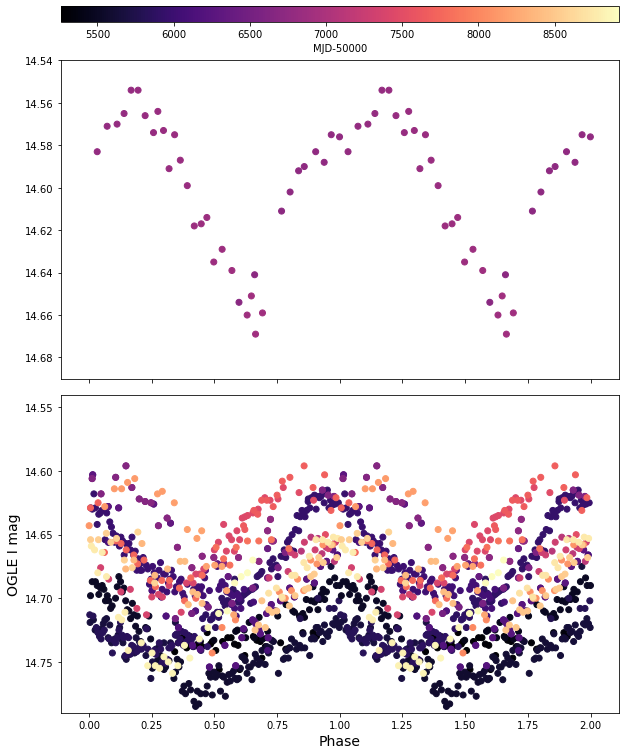

In [445]:
#is this the envisioned two-panel figure?
fig,ax=plt.subplots(2,1,figsize=(10,12),sharex=True)
#midphase = np.roll((sog4['MJD-50000'][612:650]-sog4['MJD-50000'][612])/(sog4['MJD-50000'][650]-sog4['MJD-50000'][612]),18)
#ax[0].scatter(midphase,sog4['I mag'][612:650],color='black')
#ax[0].scatter(1+midphase,sog4['I mag'][612:650],color='black')
#ax[0].scatter(sog4['MJD-50000'][612:650],sog4['I mag'][612:650],color='black')

#plotting fold just separately
im1=ax[0].scatter(phase_t[614:648],sog4['I mag'][614:648],c=sog4['MJD-50000'][614:648],cmap='magma',vmin=5540,vmax=9000)
im1=ax[0].scatter(1+phase_t[614:648],sog4['I mag'][614:648],c=sog4['MJD-50000'][614:648],cmap='magma',vmin=5540,vmax=9000)

ax[0].set_ylim(14.65+.04,14.5+.04)
ax[1].set_ylim(14.75+.04,14.5+.04)
plt.subplots_adjust(hspace=0.05)
im=ax[1].scatter(phase_f,sogf['I mag'],c=sogf['MJD-50000'],cmap='magma')
ax[1].scatter(1+phase_f,sogf['I mag'],c=sogf['MJD-50000'],cmap='magma')
ax[1].set_ylabel('OGLE I mag',fontsize=14)
ax[1].set_xlabel('Phase',fontsize=14)
axins = inset_axes(ax[0],
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='upper right',bbox_to_anchor=(0, .17, 1, 1),
                   bbox_transform=ax[0].transAxes,
                   borderpad=0,
                   )

fig.colorbar(im,cax=axins,label='MJD-50000',orientation='horizontal',pad=.08)
png('sepflareor')

# FWHM of Flares -- Can Delete to Get to Normal Final

In [446]:
#leaving the by-eye values for now
fwhm = [60,50,50,45,90,90,130,55,60,70,90,60,50] #used 50 for half flare

<ErrorbarContainer object of 3 artists>

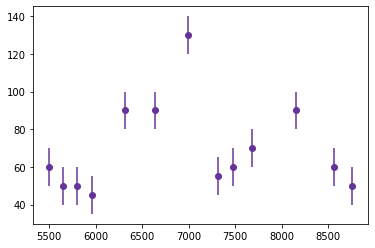

In [447]:
plt.errorbar(centers,fwhm,xerr=10,yerr=10,linestyle='none',marker='o',color='rebeccapurple')

In [448]:
h = []
for c in range(len(centers)):
    height = np.max(sog4['I detrend 2'][flareinds[c][0]:flareinds[c][1]])-np.min(sog4['I detrend 2'][flareinds[c][0]:flareinds[c][1]])
    h.append(height)
h

[0.10153638737007498,
 0.0966368159203963,
 0.0496567164179087,
 0.08250248756219491,
 0.1441243781094581,
 0.13176119402984732,
 0.12856218905472616,
 0.05371641791044368,
 0.06848756218905017,
 0.07398507462686688,
 0.09056385399733458,
 0.062358551795478334,
 0.062948916802128]

> can also try using Gaussian fits again!!!


In [449]:
outs2[-1].params['center']

<Parameter 'center', value=8755.943745124776 +/- 1.65, bounds=[-inf:inf]>

In [450]:
sog4.head()

JD   I mag  I mag err          MJD   MJD-50000  I detrend 2  \
0  2.455261e+06  14.742      0.003  55260.14719  5260.14719    14.714925   
1  2.455262e+06  14.729      0.003  55261.15051  5261.15051    14.701785   
2  2.455263e+06  14.735      0.003  55262.14427  5262.14427    14.707645   
3  2.455265e+06  14.733      0.003  55264.11167  5264.11167    14.705505   
4  2.455266e+06  14.730      0.003  55265.11299  5265.11299    14.702365   

   phase 164  
0   7.888307  
1   8.891627  
2   9.885387  
3  11.852787  
4  12.854107

In [451]:
outs[0].params['center']

<Parameter 'center', value=5502.759718787926 +/- 1.07, bounds=[-inf:inf]>

In [452]:
outs[11].params

Parameters([('amplitude',
             <Parameter 'amplitude', value=13.25026642030893 +/- 0.857, bounds=[-inf:inf]>),
            ('center',
             <Parameter 'center', value=8559.404890964699 +/- 2.75, bounds=[-inf:inf]>),
            ('sigma',
             <Parameter 'sigma', value=52.15833300125895 +/- 4.01, bounds=[0.0:inf]>),
            ('fwhm',
             <Parameter 'fwhm', value=122.82348571802461 +/- 9.44, bounds=[-inf:inf], expr='2.3548200*sigma'>),
            ('height',
             <Parameter 'height', value=0.1013470227509614 +/- 0.00287, bounds=[-inf:inf], expr='0.3989423*amplitude/max(2.220446049250313e-16, sigma)'>)])

In [453]:
outs2[11].params

Parameters([('amplitude',
             <Parameter 'amplitude', value=4.123574968007065 +/- 0.306, bounds=[-inf:inf]>),
            ('center',
             <Parameter 'center', value=8559.279002436417 +/- 2.54, bounds=[-inf:inf]>),
            ('sigma',
             <Parameter 'sigma', value=30.482667688102662 +/- 2.75, bounds=[0.0:inf]>),
            ('fwhm',
             <Parameter 'fwhm', value=71.78119552529792 +/- 6.49, bounds=[-inf:inf], expr='2.3548200*sigma'>),
            ('height',
             <Parameter 'height', value=0.053967339695837474 +/- 0.00333, bounds=[-inf:inf], expr='0.3989423*amplitude/max(2.220446049250313e-16, sigma)'>)])

In [454]:
#gfits2.to_csv('gaussianfits2.csv')
#gfits2

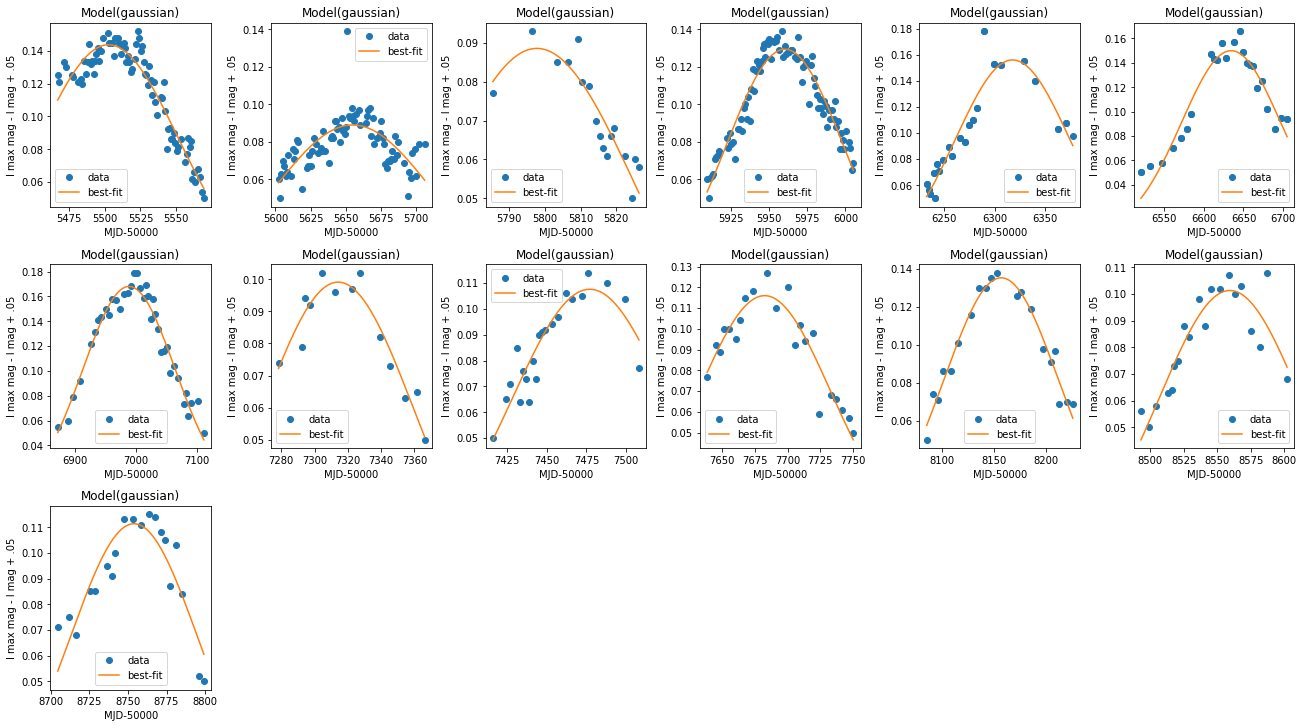

In [455]:
#plotting function; removing extra stuff
fig = plt.figure(constrained_layout=True,figsize=(18,10))
gs = fig.add_gridspec(3,6)
# ax1 = fig.add_subplot(gs[0, 0])
# outs[0].plot_fit()
# ax2 = fig.add_subplot(gs[0, 1])
# outs[0].plot_fit
# ax3 = fig.add_subplot(gs[0, 0])
for f in range(13):
    if f < 6: axt = fig.add_subplot(gs[0, f])
    elif f < 12: axt = fig.add_subplot(gs[1, f-6])
    else: axt = fig.add_subplot(gs[2, f-12])
    outs[f].plot_fit(numpoints=500,xlabel='MJD-50000',ylabel='I max mag - I mag + .05')
    #axt.axvspan(gfits['center'][f]-gfits['center err'][f],gfits['center'][f]+gfits['center err'][f],alpha=.5)
#png('allgfits')

In [456]:
flareinds[0][1]

130

In [457]:
outs[0].best_values

{'amplitude': 17.431662865924242,
 'center': 5502.759718787926,
 'sigma': 48.39647247550032}

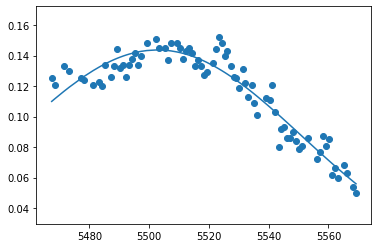

In [458]:
st = flareinds[0][0]
end = flareinds[0][1]
plt.scatter(sog4['MJD-50000'][st:end],np.max(sog4['I mag'][st:end])-sog4['I mag'][st:end]+.05)
plt.plot(sog4['MJD-50000'][st:end],outs[0].best_fit) 

In [459]:
type(np.array(sog4['MJD-50000'][50:130]))

numpy.ndarray

In [460]:
outs[0].params

Parameters([('amplitude',
             <Parameter 'amplitude', value=17.431662865924242 +/- 0.449, bounds=[-inf:inf]>),
            ('center',
             <Parameter 'center', value=5502.759718787926 +/- 1.07, bounds=[-inf:inf]>),
            ('sigma',
             <Parameter 'sigma', value=48.39647247550032 +/- 1.42, bounds=[0.0:inf]>),
            ('fwhm',
             <Parameter 'fwhm', value=113.96498131475767 +/- 3.35, bounds=[-inf:inf], expr='2.3548200*sigma'>),
            ('height',
             <Parameter 'height', value=0.14369286274070572 +/- 0.00144, bounds=[-inf:inf], expr='0.3989423*amplitude/max(2.220446049250313e-16, sigma)'>)])

In [461]:
float(sog4['MJD-50000'][550:551])

6520.406090000179

Text(0.5, 0, 'MJD-50000')

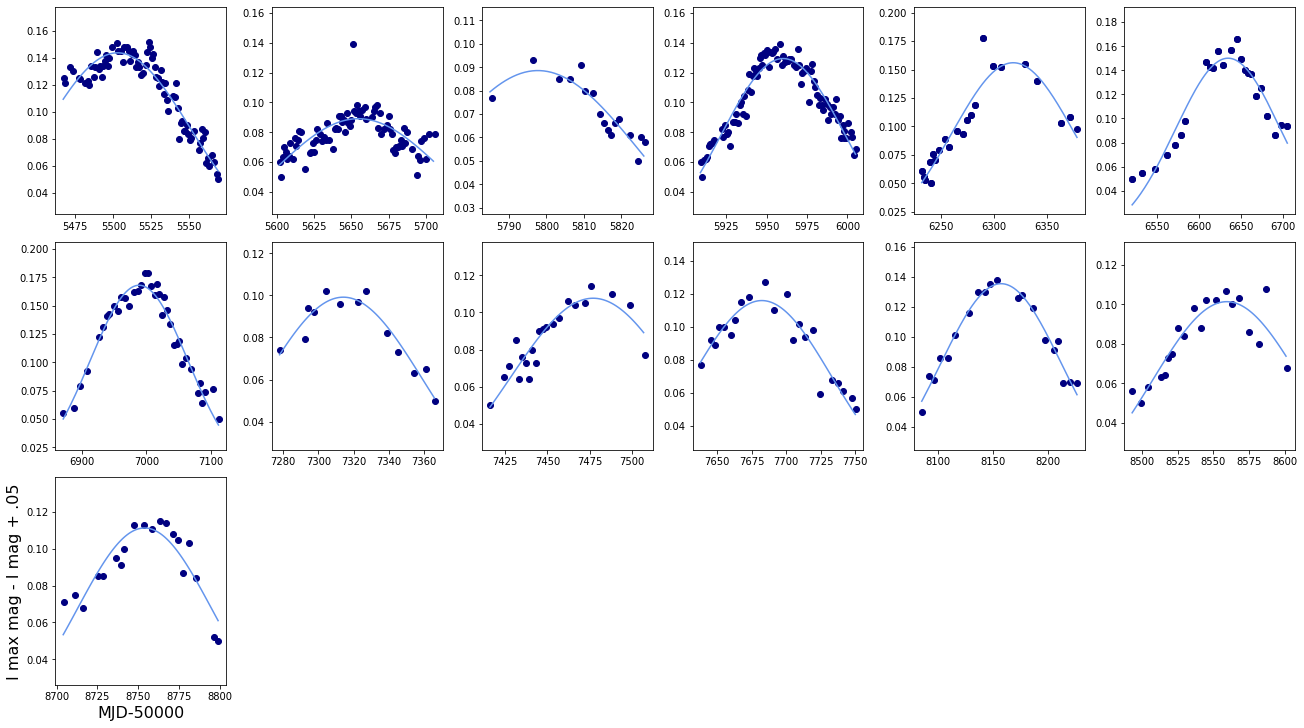

In [462]:
#plotting function; removing extra stuff
fig = plt.figure(constrained_layout=True,figsize=(18,10))
gs = fig.add_gridspec(3,6)
for f in range(13):
    if f < 6: axt = fig.add_subplot(gs[0, f])
    elif f < 12: axt = fig.add_subplot(gs[1, f-6])
    else: axt = fig.add_subplot(gs[2, f-12])
    st = flareinds[f][0]
    end = flareinds[f][1]
    stdate = int(sog4['MJD-50000'][st:st+1])
    enddate = int(sog4['MJD-50000'][end-1:end])
    axt.scatter(sog4['MJD-50000'][st:end],np.max(sog4['I mag'][st:end])-sog4['I mag'][st:end]+.05,color='navy')
    xfits = np.linspace(enddate,stdate,enddate-stdate)
    bfit = gaussian(xfits,outs[f].best_values['amplitude'],outs[f].best_values['center'],outs[f].best_values['sigma'])
    axt.plot(xfits,bfit,color='cornflowerblue') 
axt.set_ylabel('I max mag - I mag + .05',fontsize=16)
axt.set_xlabel('MJD-50000',fontsize=16)
#png('13flarefits')

In [463]:
outs[0].params

Parameters([('amplitude',
             <Parameter 'amplitude', value=17.431662865924242 +/- 0.449, bounds=[-inf:inf]>),
            ('center',
             <Parameter 'center', value=5502.759718787926 +/- 1.07, bounds=[-inf:inf]>),
            ('sigma',
             <Parameter 'sigma', value=48.39647247550032 +/- 1.42, bounds=[0.0:inf]>),
            ('fwhm',
             <Parameter 'fwhm', value=113.96498131475767 +/- 3.35, bounds=[-inf:inf], expr='2.3548200*sigma'>),
            ('height',
             <Parameter 'height', value=0.14369286274070572 +/- 0.00144, bounds=[-inf:inf], expr='0.3989423*amplitude/max(2.220446049250313e-16, sigma)'>)])

Text(0.5, 0, 'FWHM')

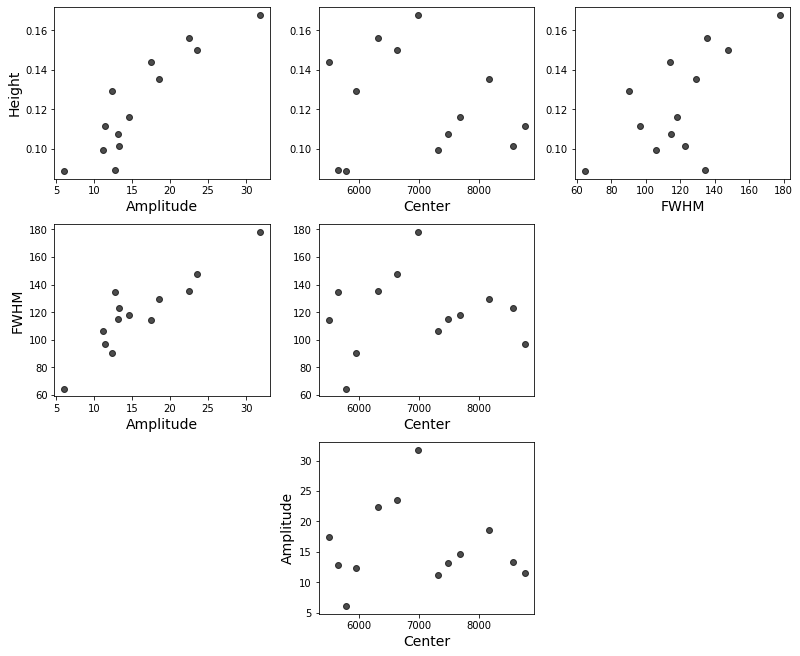

In [464]:
#with .05 offset
fig3 = plt.figure(constrained_layout=True,figsize=(11,9))
gs = fig3.add_gridspec(3, 3)
ax1 = fig3.add_subplot(gs[0, 0])
ax2 = fig3.add_subplot(gs[0, 1],sharey=ax1)
ax3 = fig3.add_subplot(gs[0, 2],sharey=ax1)
ax4 = fig3.add_subplot(gs[1, 0])
ax5 = fig3.add_subplot(gs[1, 1],sharey=ax4)
ax6 = fig3.add_subplot(gs[2, 1])
ax1.errorbar(gfits['amp'],gfits['height'],linestyle='none',marker='o',alpha=.7,color='black')
ax1.set_ylabel('Height',fontsize=14)
ax1.set_xlabel('Amplitude',fontsize=14)
#ax1.set_ylim(19.98,19.86)

ax2.errorbar(gfits['center'],gfits['height'],linestyle='none',marker='o',alpha=.7,color='black')
#ax[0][1].set_ylabel('Height (I mag)')
ax2.set_xlabel('Center',fontsize=14)
#ax2.set_ylim(14.74,14.56)

ax4.errorbar(gfits['amp'],gfits['fwhm'],linestyle='none',marker='o',alpha=.7,color='black')
ax4.set_ylabel('FWHM',fontsize=14)
ax4.set_xlabel('Amplitude',fontsize=14)

ax5.errorbar(gfits['center'],gfits['fwhm'],linestyle='none',marker='o',alpha=.7,color='black')
#ax[0][1].set_ylabel('Height (I mag)')
ax5.set_xlabel('Center',fontsize=14)


ax6.errorbar(gfits['center'],gfits['amp'],linestyle='none',marker='o',alpha=.7,color='black')
ax6.set_xlabel('Center',fontsize=14)
ax6.set_ylabel('Amplitude',fontsize=14)

ax3.errorbar(gfits['fwhm'],gfits['height'],linestyle='none',marker='o',alpha=.7,color='black')
ax3.set_xlabel('FWHM',fontsize=14)
#png('gaussrel')

Text(0.5, 0, 'FWHM')

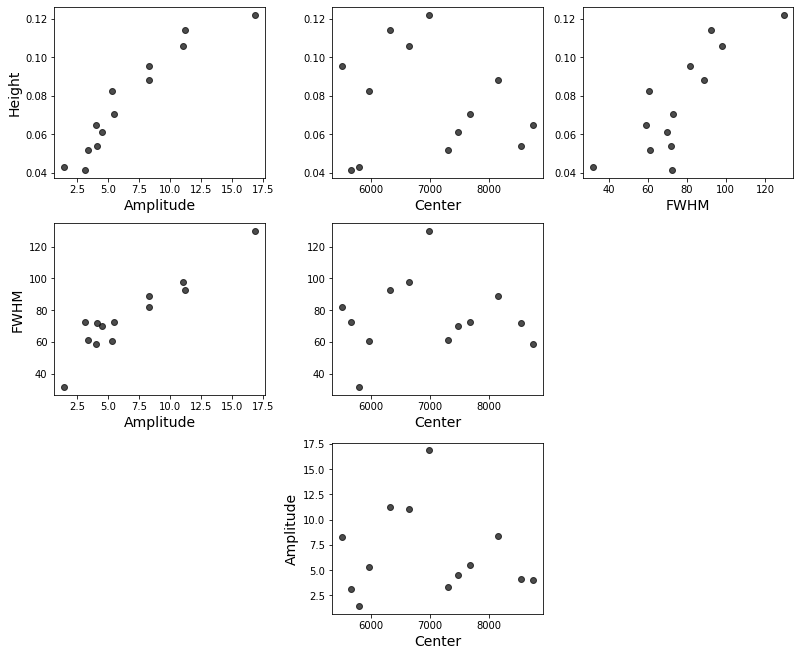

In [465]:
#no offset
fig3 = plt.figure(constrained_layout=True,figsize=(11,9))
gs = fig3.add_gridspec(3, 3)
ax1 = fig3.add_subplot(gs[0, 0])
ax2 = fig3.add_subplot(gs[0, 1],sharey=ax1)
ax3 = fig3.add_subplot(gs[0, 2],sharey=ax1)
ax4 = fig3.add_subplot(gs[1, 0])
ax5 = fig3.add_subplot(gs[1, 1],sharey=ax4)
ax6 = fig3.add_subplot(gs[2, 1])
ax1.errorbar(gfits2['amp'],gfits2['height'],xerr=gfits2['amp err'],yerr=gfits2['height err'],linestyle='none',marker='o',alpha=.7,color='black')
ax1.set_ylabel('Height',fontsize=14)
ax1.set_xlabel('Amplitude',fontsize=14)
#ax1.set_ylim(19.98,19.86)

ax2.errorbar(gfits2['center'],gfits2['height'],xerr=gfits2['center err'],yerr=gfits2['height err'],linestyle='none',marker='o',alpha=.7,color='black')
#ax[0][1].set_ylabel('Height (I mag)')
ax2.set_xlabel('Center',fontsize=14)
#ax2.set_ylim(14.74,14.56)

ax4.errorbar(gfits2['amp'],gfits2['fwhm'],yerr=gfits2['fwhm err'],xerr=gfits2['amp err'],linestyle='none',marker='o',alpha=.7,color='black')
ax4.set_ylabel('FWHM',fontsize=14)
ax4.set_xlabel('Amplitude',fontsize=14)

ax5.errorbar(gfits2['center'],gfits2['fwhm'],xerr=gfits2['center err'],yerr=gfits2['height err'],linestyle='none',marker='o',alpha=.7,color='black')
#ax[0][1].set_ylabel('Height (I mag)')
ax5.set_xlabel('Center',fontsize=14)


ax6.errorbar(gfits2['center'],gfits2['amp'],xerr=gfits2['center err'],yerr=gfits2['amp err'],linestyle='none',marker='o',alpha=.7,color='black')
ax6.set_xlabel('Center',fontsize=14)
ax6.set_ylabel('Amplitude',fontsize=14)

ax3.errorbar(gfits2['fwhm'],gfits2['height'],xerr=gfits2['fwhm err'],yerr=gfits2['height err'],linestyle='none',marker='o',alpha=.7,color='black')
ax3.set_xlabel('FWHM',fontsize=14)
#png('gaussrel2')

(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

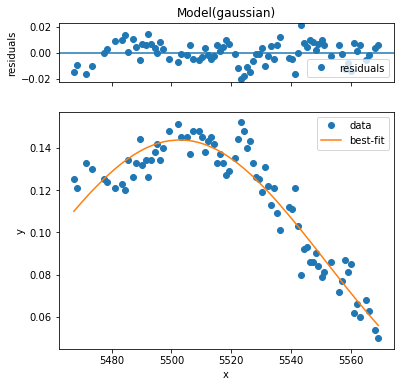

In [466]:
#can easily plot gaussian and residuals
outs[0].plot() #does the constant (causing the different y-axis affect the error calculations?)

In [467]:
outs[0].params

Parameters([('amplitude',
             <Parameter 'amplitude', value=17.431662865924242 +/- 0.449, bounds=[-inf:inf]>),
            ('center',
             <Parameter 'center', value=5502.759718787926 +/- 1.07, bounds=[-inf:inf]>),
            ('sigma',
             <Parameter 'sigma', value=48.39647247550032 +/- 1.42, bounds=[0.0:inf]>),
            ('fwhm',
             <Parameter 'fwhm', value=113.96498131475767 +/- 3.35, bounds=[-inf:inf], expr='2.3548200*sigma'>),
            ('height',
             <Parameter 'height', value=0.14369286274070572 +/- 0.00144, bounds=[-inf:inf], expr='0.3989423*amplitude/max(2.220446049250313e-16, sigma)'>)])

In [495]:
import numpy, scipy.optimize
#found online: https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
#trying sine wave fits
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

In [502]:
res = fit_sin(sog4['MJD-50000'][40:150],sog4['I mag'][40:150])

In [521]:
sinmods = []
sinmdet = []
flarei = flareinds
flarei[0] = [40,150]
for f in flarei:
    st = f[0]
    end = f[1]
    res = fit_sin(sog4['MJD-50000'][st:end],sog4['I mag'][st:end])
    resd = fit_sin(sog4['MJD-50000'][st:end],sog4['I detrend 2'][st:end])
    sinmdet.append(resd)
    sinmods.append(res)
#fig,ax = plt.subplots(3,6)

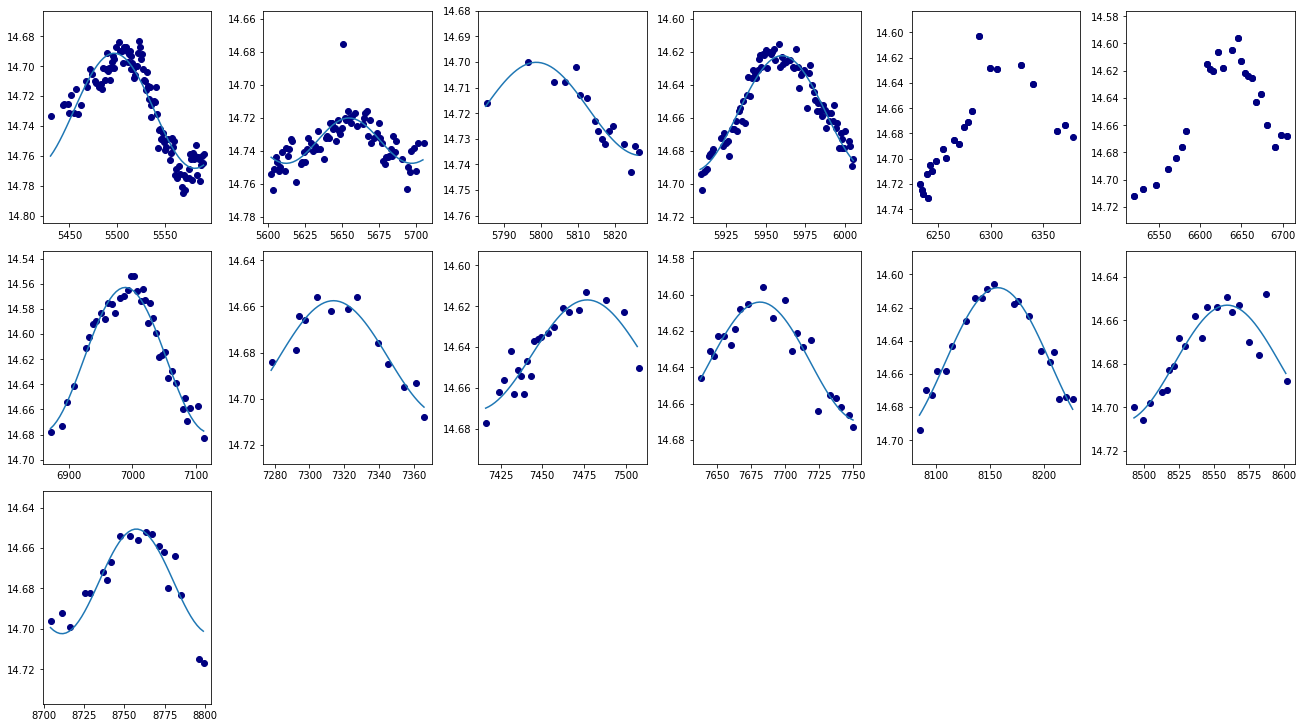

In [531]:
fig = plt.figure(constrained_layout=True,figsize=(18,10))
gs = fig.add_gridspec(3,6)
for f in range(13):
    if f < 6: axt = fig.add_subplot(gs[0, f])
    elif f < 12: axt = fig.add_subplot(gs[1, f-6])
    else: axt = fig.add_subplot(gs[2, f-12])
    st = flareinds[f][0]
    end = flareinds[f][1]
    stdate = int(sog4['MJD-50000'][st:st+1])
    enddate = int(sog4['MJD-50000'][end-1:end])
    axt.scatter(sog4['MJD-50000'][st:end],sog4['I mag'][st:end],color='navy')
    axt.plot(np.linspace(stdate,enddate),sinmods[f]["fitfunc"](np.linspace(stdate,enddate)))
    #axt.plot(sog4['MJD-50000'][st:end],sinmdet[f]["fitfunc"](sog4['MJD-50000'][st:end]),color='rebeccapurple',alpha=.6)

    axt.set_ylim(np.max(sog4['I mag'][st:end])+.02,np.min(sog4['I mag'][st:end])-.02)
    

In [552]:
st = flareinds[0][0]
end = flareinds[0][1]
stdate = int(sog4['MJD-50000'][st:st+1])
enddate = int(sog4['MJD-50000'][end-1:end])
ff = np.arange(stdate,enddate,.1)
scipy.signal.find_peaks(-1*sinmods[0]["fitfunc"](ff))[0]

array([670])

5497.000000000244

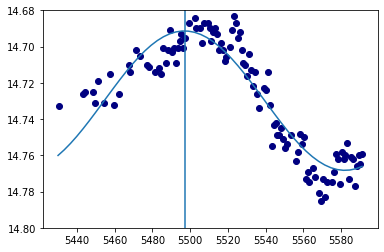

In [549]:
#figure out what the center is based on these models
#later -- extend indices for some?
#scipy.signal.find_peaks to show asymmetry?
plt.scatter(sog4['MJD-50000'][st:end],sog4['I mag'][st:end],color='navy')

plt.plot(np.linspace(stdate,enddate),sinmods[0]["fitfunc"](np.linspace(stdate,enddate)))
plt.ylim(14.8,14.68)
plt.axvline(ff[670])
ff[670]

In [556]:
#function to find center of each according to sinusoidal model
def peakplot(ind,plot=True):
    st = flareinds[ind][0]
    end = flareinds[ind][1]
    stdate = int(sog4['MJD-50000'][st:st+1])
    enddate = int(sog4['MJD-50000'][end-1:end])
    ff = np.arange(stdate,enddate,.1)
    pk = scipy.signal.find_peaks(-1*sinmods[ind]["fitfunc"](ff))[0]
    if plot:
        plt.scatter(sog4['MJD-50000'][st:end],sog4['I mag'][st:end],color='navy')
        plt.plot(np.linspace(stdate,enddate),sinmods[ind]["fitfunc"](np.linspace(stdate,enddate)))
        plt.ylim(np.max(sog4['I mag'][st:end])+.02,np.min(sog4['I mag'][st:end])-.02)
        plt.axvline(ff[pk])
    return ff[pk] #returns center

array([5654.8])

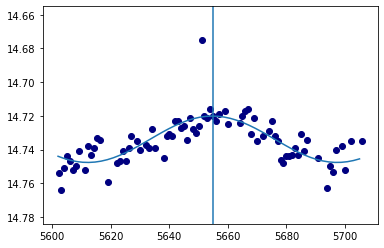

In [554]:
peakplot(1)

In [565]:
sincens = []
for i in range(13):
     sincens.append(peakplot(i,plot=False))
sincens

[array([5497.]),
 array([5654.8]),
 array([5798.7]),
 array([5960.3]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([6988.6]),
 array([7313.9]),
 array([7477.]),
 array([7681.8]),
 array([8157.1]),
 array([8559.4]),
 array([8757.4])]

In [566]:
#hard code for now
sincens = np.array([5497,5654.8,5798.7,5960.3,np.nan,np.nan,6988.6,7313.9,7477,7681.8,8157.1,8559.4,8757.4])

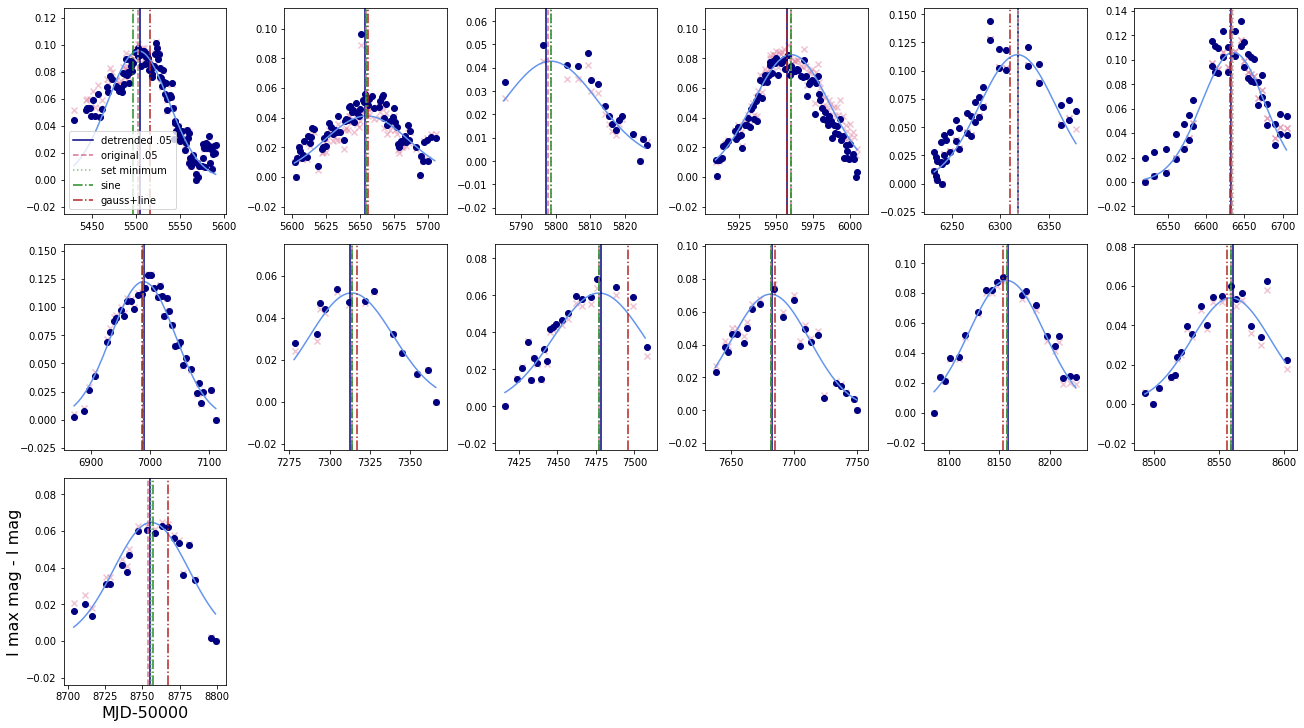

In [594]:
#redo center plot and add these
#show modeled 13 flares
#plotting function; removing extra stuff
fig = plt.figure(constrained_layout=True,figsize=(18,10))
gs = fig.add_gridspec(3,6)
for f in range(13):
    if f < 6: axt = fig.add_subplot(gs[0, f])
    elif f < 12: axt = fig.add_subplot(gs[1, f-6])
    else: axt = fig.add_subplot(gs[2, f-12])
    st = flareinds[f][0]
    end = flareinds[f][1]
    stdate = int(sog4['MJD-50000'][st:st+1])
    enddate = int(sog4['MJD-50000'][end-1:end])
    axt.scatter(sog4['MJD-50000'][st:end],np.max(sog4['I mag'][st:end])-sog4['I mag'][st:end],color='palevioletred',alpha=.4,marker='x')
    axt.scatter(sog4['MJD-50000'][st:end],np.max(sog4['I detrend 2'][st:end])-sog4['I detrend 2'][st:end],color='navy')

    xfits = np.linspace(enddate,stdate,enddate-stdate)
    #changed to use gaussian model with no offset
    bfit = gaussian(xfits,gfl[0]['amp'][f],gfl[0]['center'][f],gfl[0]['sigma'][f])
    axt.plot(xfits,bfit,color='cornflowerblue') 
    axt.axvline(det_outs[f].best_values['center'],color='navy',label='detrended .05')
    axt.axvline(outs[f].best_values['center'],color='palevioletred',label='original .05',linestyle='dashed')
    axt.axvline(outs2[f].best_values['center'],color='darkseagreen',label='set minimum',linestyle='dotted')
    axt.axvline(sincens[f],color='forestgreen',label='sine',linestyle='-.')

    if f != 2: #can change to just f!=2
        axt.axvline(glcens[f],color='firebrick',label='gauss+line',linestyle='-.')
    if f == 0: axt.legend()
#     if f < 12 and f > 2:
#         d1 = np.abs(gfits['center'][f]-gfits2['center'][f])
#         d2 = np.abs(gfits2['center'][f]-det_gfits['center'][f+1])
#         d3 = np.abs(det_gfits['center'][f+1]-gfits['center'][f])
#         maxd = np.max(np.array([d1,d2,d3]))
#         print(maxd)
axt.set_ylabel('I max mag - I mag',fontsize=16) #no offset since model now has max I mag set to zero
axt.set_xlabel('MJD-50000',fontsize=16)
#png('det13fits2')

In [590]:
#checking chi squared of different models
gfl

0     8.32614
1     3.18435
2     1.45228
3     5.34087
4     11.2465
5      11.044
6     16.8794
7     3.35949
8     4.55734
9     5.48361
10    8.35267
11    4.12357
12    4.06613
Name: amp, dtype: object

Text(0, 0.5, 'Center Fit - Min Center Fit')

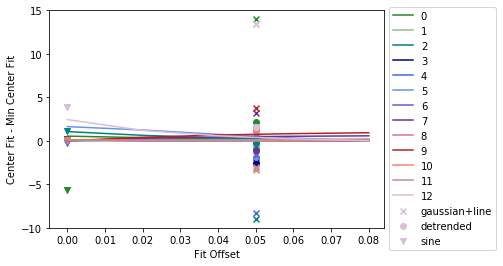

In [570]:
#adding sine wave centers
cs = ['forestgreen','darkseagreen','teal','navy','royalblue','cornflowerblue','slateblue','rebeccapurple','palevioletred','firebrick','salmon','rosybrown','thistle']
offs = np.arange(0,.1,.02)
for o in range(13):
    plt.plot(offs,cenarray[o]-np.min(cenarray[o]),label=str(o),color=cs[o])
for d in range(len(det_centers)):
    plt.scatter(.05,det_centers[d]-np.min(cenarray[d]),color=cs[d])
    
    #add gaussian+line centers
    plt.scatter(.05,glcens[d]-np.min(cenarray[d]),color=cs[d],marker='x')
    plt.scatter(0,sincens[d]-np.min(cenarray[d]),color=cs[d],marker='v')
plt.scatter(.05,glcens[d]-np.min(cenarray[d]),color=cs[d],marker='x',label='gaussian+line')
plt.scatter(.05,det_centers[d]-np.min(cenarray[d]),color=cs[d],label='detrended')
plt.scatter(0,sincens[d]-np.min(cenarray[d]),color=cs[d],marker='v',label='sine')
#cutting off high ones
plt.ylim(-10,15)

plt.legend(bbox_to_anchor=(0, 0, 1.35, 1.04))
plt.xlabel('Fit Offset')
plt.ylabel('Center Fit - Min Center Fit')

# Make Histogram of Centers Using Different Models
> model with no offset is zero point


In [574]:
no_off = np.array(gfl[0]['center'])


In [575]:
#make arrays of differences between centers
#difference between detrended and no offset
det_no = det_centers - no_off
det_no

array([ 1.63735935, -0.8840245 , -1.36754221, -2.61890503,  0.49435407,
       -3.46031727,  1.36178411, -1.0326874 ,  1.14297184,  1.43715399,
        1.06269896,  1.55618315, -0.82853204])

In [576]:
#gaussian + line and no offset
gl_no = glcens - no_off
gl_no

array([ 13.43672736,   0.77538854, -10.00929608,  -2.59747092,
        -8.35040928,  -4.73713335,  -1.72466351,   3.15767554,
        18.88525715,   3.73068755,  -3.43565363,  -3.05751321,
        10.94104674])

In [583]:
#get rid of third flare since not well-fit by gaussian+line
gl_no = list(gl_no[:2]) + list(gl_no[3:])
gl_no

[13.436727359600809,
 0.7753885367765179,
 -2.597470920726664,
 -8.350409281354587,
 -4.737133354891739,
 -1.7246635094679732,
 3.1576755399300964,
 18.885257153581733,
 3.7306875489866798,
 -3.435653632986032,
 -3.0575132130306883,
 10.941046740834281]

In [580]:
#for each offset 0.2-0.8
off_no2 = np.array(gfl[1]['center']) - no_off
off_no4 = np.array(gfl[2]['center']) - no_off
off_no6 = np.array(gfl[3]['center']) - no_off
off_no8 = np.array(gfl[4]['center']) - no_off

Text(0, 0.5, '# Flares')

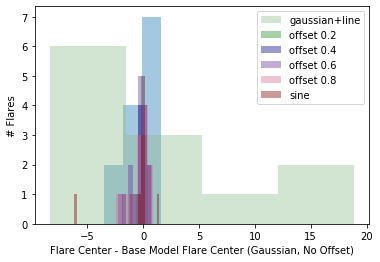

In [611]:
import seaborn as sb
sb.distplot(det_no,kde=False)
sb.distplot(gl_no,color='darkseagreen',kde=False,label='gaussian+line')
sb.distplot(off_no2,color='forestgreen',kde=False,label='offset 0.2')
sb.distplot(off_no4,color='navy',kde=False,label='offset 0.4')
sb.distplot(off_no6,color='rebeccapurple',kde=False,label='offset 0.6')
sb.distplot(off_no8,color='palevioletred',kde=False,label='offset 0.8')
#sine model
sb.distplot(sincens - no_off,color='maroon',kde=False,label='sine')

plt.legend()
plt.xlabel('Flare Center - Base Model Flare Center (Gaussian, No Offset)')
plt.ylabel('# Flares')

In [612]:
sincens - no_off

array([-6.14498827, -0.11940517,  0.10745108,  0.04906192,         nan,
               nan, -0.26401641,  0.18372865, -0.07692024,  0.15341883,
       -0.04515184,  0.12099756,  1.45625488])

# Triangle Model

In [714]:
#scipy optimize curve fit but then have to define triangle as one function
def triangle(x,s1,i1,s2,i2,findpk=False):
    '''
    Triangle function using two line slopes and two intercepts.
    Assumes first slope is positive, second is negative'''
    #y1 = s1*x + i1
    #y2 = s2*x + i2
    #find intersection point -- x value where y1 = y2
    peak = (i2 - i1)/(s1-s2)
    #use first line for x less than peak
    x1 = x[x<=peak]
    x2 = x[x>=peak]
    
    y1 = s1*x1+i1
    y2 = s2*x2+i2
    y = np.concatenate((y1,y2))
    if findpk: return y,peak
    else: return y

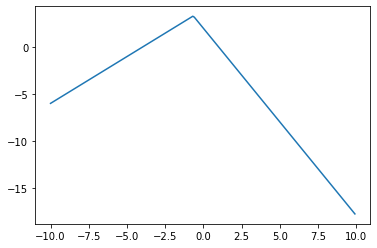

In [630]:
#test triangle function
ytest = triangle(np.arange(-10,10,.1),1,4,-2,2)
plt.plot(np.arange(-10,10,.1),ytest) #they have same length

- tried triang function
- tried simple scipy optimize

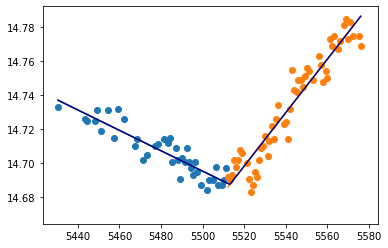

In [718]:
ffx = sog4['MJD-50000'][40:135]
linmodel1 = np.polyfit(ffx[:40],sog4['I mag'][40:80], 1)
plt.scatter(ffx[:40],sog4['I mag'][40:80])
plt.plot(ffx[:40],line(ffx[:40],linmodel1[0],linmodel1[1]))
linmodel2 = np.polyfit(ffx[40:],sog4['I mag'][80:135], 1)
plt.scatter(ffx[40:],sog4['I mag'][80:135])
plt.plot(ffx[40:],line(ffx[40:],linmodel2[0],linmodel2[1]))
#plot using triangle funtion
plt.plot(ffx,triangle(ffx,linmodel1[0],linmodel1[1],linmodel2[0],linmodel2[1]),color='navy')

In [664]:
print('initial slopes:',linmodel1[0],linmodel2[0])
print('initial intercepts:',linmodel1[1],linmodel2[1])

initial slopes: -0.0005985275003180042 0.00156868513600045
initial intercepts: 17.987260526350806 6.039076967831613


In [673]:
from scipy.optimize import curve_fit

x = sog4['MJD-50000'][40:135]
y = sog4['I mag'][40:135]

init_vals = [linmodel1[0],linmodel1[1],linmodel2[0],linmodel2[1]]  # for slope1, int1, slope2, int2
best_vals, covar = curve_fit(triangle, x, y, p0=init_vals)

In [680]:
bv = best_vals
bv

array([-5.88732145e-04,  1.79337129e+01,  1.58370382e-03,  5.95566154e+00])

In [704]:
#difference between initial and final values
bv - init_vals

array([ 9.79535491e-06, -5.35476373e-02,  1.50186883e-05, -8.34154248e-02])

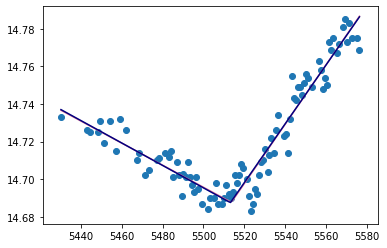

In [685]:
#plot initial and best fit
plt.plot(ffx,triangle(ffx,bv[0],bv[1],bv[2],bv[3]),color='palevioletred') #final fit
plt.scatter(ffx,sog4['I mag'][40:135])
plt.plot(ffx,triangle(ffx,linmodel1[0],linmodel1[1],linmodel2[0],linmodel2[1]),color='navy') #initial guess

In [689]:
#with lmfit instead; then find these different peaks
tmodel = Model(triangle)

In [720]:
init_vals

[-0.0005985275003180042,
 17.987260526350806,
 0.00156868513600045,
 6.039076967831613]

In [717]:
#print center (peak) from this fit
triangle(ffx,-5.88732145e-04,  1.79337129e+01,  1.58370382e-03,  5.95566154e+00,findpk=True)[1]

5513.649908663705

In [722]:
#peak from initial values
triangle(ffx,init_vals[0],  init_vals[1],  init_vals[2],  init_vals[3],findpk=True)[1]

5513.157019431251

In [724]:
#params = tmodel.make_params(s1=-.0006,i1=18,s2=.002,i2=6)
#tmodel.set_param_hint('s1', max=-.00001)
#tmodel.set_param_hint('s2', max=.1)
params = tmodel.make_params(s1=init_vals[0],i1=init_vals[1],s2=init_vals[2],i2=init_vals[3])
tmodel.set_param_hint('s1', max=-.00001)
tmodel.set_param_hint('s2', max=.1)

In [725]:
#result = tmodel.fit(sog4['I mag'][40:135], x=ffx,s1=-.0005,i1=18,s2=.001,i2=6) #guess parameters?
result = tmodel.fit(sog4['I mag'][40:135], x=ffx,s1=-.0005,i1=18,s2=.001,i2=6) #guess parameters?

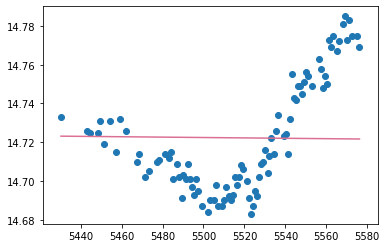

In [726]:
tfit = triangle(ffx,result.params['s1'].value,result.params['i1'].value,result.params['s2'].value,result.params['i2'].value)
plt.plot(ffx,tfit,color='palevioletred') #final fit
plt.scatter(ffx,sog4['I mag'][40:135])

In [727]:
result

In [730]:
init_vals

[-0.0005985275003180042,
 17.987260526350806,
 0.00156868513600045,
 6.039076967831613]

In [733]:
#try curve_fit with worse initial values; not best values from

init_vals2 = [linmodel1[0]+.00005,linmodel1[1]+.05,linmodel2[0]-.0001,linmodel2[1]-.05]  # for slope1, int1, slope2, int2
best_vals2, covar2 = curve_fit(triangle, x, y, p0=init_vals2)

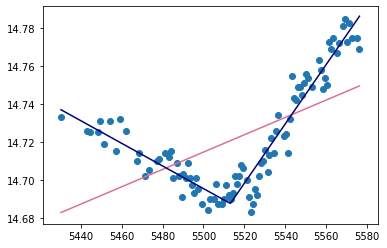

In [734]:
plt.plot(ffx,triangle(ffx,best_vals2[0],best_vals2[1],best_vals2[2],best_vals2[3]),color='palevioletred') #final fit
plt.scatter(ffx,sog4['I mag'][40:135])
plt.plot(ffx,triangle(ffx,linmodel1[0],linmodel1[1],linmodel2[0],linmodel2[1]),color='navy') #initial guess

okay, the problem is that curve_fit only works when the initial values are really close to the final
   - the last example shows they can't be guessed or transferred between flares, they'd have to be obtained from those separate linear models; or, of course I can go in another direction

things to try 
   - get initial values from linear fits a little differently (cut off at different index)
   - use a center guess as a parameter in triangle and then keep that reasonable

In [959]:
def triangfit(ind,cut1=0,cut2=0,div=0,mult=False,off=False,rs=[],stcut=False,plot=True,chis=False):
    '''Fit triangle to flare.
    mult: boolean to use multiple initial fits
    rs: range of div to pass in
    off: boolean for rs to be different index cutoffs (more or less data used)
    stcut: boolean for rs to cut points from flare start rather than end
    plot: boolean for plotting; default True
    chis: boolean for returning chi-squared value(s); default to False'''
    #cutoff allows you to decrease the point involved 
    st = flareinds[ind][0]+cut1
    end = flareinds[ind][1]-cut2
    x = sog4['MJD-50000'][st:end]
    y = sog4['I mag'][st:end]
    yerr = sog4['I mag err'][st:end]
    if plot: plt.scatter(x,y,color='cornflowerblue')
    split = int(div+(end-st)/2)
    #div moves where the cutoff is; positive div moves cutoff to right
    if mult: #mult can either be range of divisions or index cutoffs
        pks = []
        chi2 = []
        rchi2 = []
        for r in rs:
            if off: 
                if stcut: 
                    st = flareinds[ind][0]+r
                    #commented out changing split based on overwritten starts to separate variables
                    #split = int(div+(end-st)/2)
                else: 
                    end = flareinds[ind][1]-r
                    #split = int(div+(end-st)/2)
                #have to redefine what's ulimately fit
                #original flareinds x and y already scattered; showing any extra data with transparency
                x = sog4['MJD-50000'][st:end]
                y = sog4['I mag'][st:end]
                #to do: add errorbars
                yerr = sog4['I mag err'][st:end]
                #scatters again with last-defined x,y, so more points if negative rs used (and off=True)
                if plot: plt.scatter(x,y,alpha=.4,color='cornflowerblue')
            #split changed if off is False
            else: split = int(r+(end-st)/2)
            lin1 = np.polyfit(x[:split],y[:split], 1)
            lin2 = np.polyfit(x[split:],y[split:], 1)
            #split defined wrt beginning so has to be changed if stcut
            #want the split to still happen in the same place
            if stcut:
                 #subtract r to cancel out for r being added to start
                lin1 = np.polyfit(x[:split-r],y[:split-r], 1)
                #print(st+split-r) confirmed that the above line maintained the point of split
                lin2 = np.polyfit(x[split-r:],y[split-r:], 1)
            if plot: plt.plot(x,triangle(x,lin1[0],lin1[1],lin2[0],lin2[1]),color='navy',linestyle='dotted')
            #improve fit using curve_fit
            iv = [lin1[0],lin1[1],lin2[0],lin2[1]]  # for slope1, int1, slope2, int2
            #print(iv)
            bvs, covar = curve_fit(triangle, x, y, p0=iv)
            b_fit,bpk = triangle(x,bvs[0],bvs[1],bvs[2],bvs[3],findpk=True)
            #print(bpk)
            pks.append(bpk)
            if plot: plt.plot(x,b_fit,color='darkseagreen')
            #plt.legend()
            if chis:
                chi = np.sum((np.array(y)-np.array(b_fit))**2/(yerr**2))
                chi2.append(chi)
                #also add reduced chi squared since different numbers of points used if off
                rchi2.append(chi/(len(x)-4))
        if plot:
            plt.plot(x,triangle(x,lin1[0],lin1[1],lin2[0],lin2[1]),color='navy',linestyle='dotted',label='initial fit')
            plt.plot(x,b_fit,color='darkseagreen',label='best fit')
            plt.ylim(np.max(y)+.02,np.min(y)-.02)
 
            plt.legend()
        if chis: return pks,chi2,rchi2
        else: return pks
    else:
        split = int(div+(end-st)/2)
        lin1 = np.polyfit(x[:split],y[:split], 1)
        lin2 = np.polyfit(x[split:],y[split:], 1)
        #plt.scatter(x,y)
        if plot: plt.plot(x,triangle(x,lin1[0],lin1[1],lin2[0],lin2[1]),color='navy',label='initial fit',linestyle='dotted')
        #improve fit using curve_fit
        iv = [lin1[0],lin1[1],lin2[0],lin2[1]]  # for slope1, int1, slope2, int2
        bvs, covar = curve_fit(triangle, x, y, p0=iv)
        b_fit,bpk = triangle(x,bvs[0],bvs[1],bvs[2],bvs[3],findpk=True)
        if plot:
            plt.plot(x,b_fit,color='darkseagreen',label='best fit')
            plt.legend()
            plt.ylim(np.max(y)+.02,np.min(y)-.02)
        if chis:
            chi = np.sum((np.array(y)-np.array(b_fit))**2/(yerr**2))
            rchi = (chi/(len(x)-4)) #four triangle params
            return bpk, chi, rchi
        else: return bpk

5507.515587887069

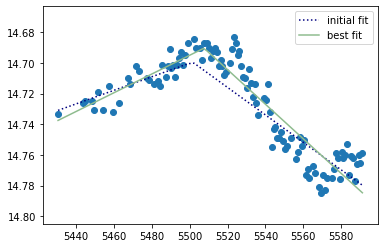

In [818]:
#automatic cut at middle index
triangfit(0)

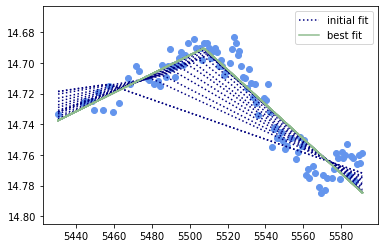

In [1022]:
#changing split point
divcen1,divc1,divr1 = triangfit(0,mult=True,rs=np.arange(-20,14,2),chis=True)
#png('initsens')

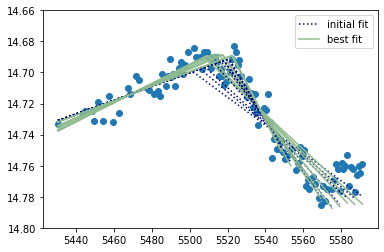

In [829]:
#varying indices used in fit (inclusion of data)
#positive rs get rid of data
#leaving for now
dindpk = triangfit(0,mult=True,off=True,rs=np.arange(0,40,4))
plt.ylim(14.8,14.66)
#png('rangesens')

(14.8, 14.66)

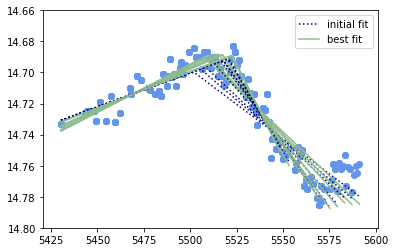

In [1023]:
endcen1,endc1,endr1 = triangfit(0,mult=True,off=True,rs=np.arange(0,40,4),chis=True)
plt.ylim(14.8,14.66)

Text(0, 0.5, 'Best Fit Peak')

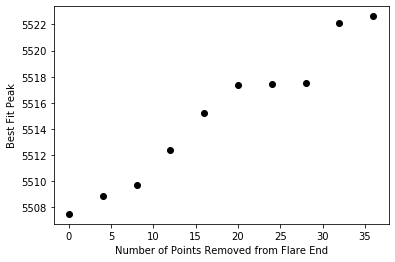

In [830]:
plt.scatter(np.arange(0,40,4),dindpk,color='black')
plt.xlabel('Number of Points Removed from Flare End')
plt.ylabel('Best Fit Peak')

In [831]:
dindpk #no more plateau once split point maintained

[5507.515587887069,
 5508.863921792431,
 5509.7029716677225,
 5512.41227178408,
 5515.236689996548,
 5517.356573777751,
 5517.43525112512,
 5517.519482251844,
 5522.082483798053,
 5522.6146722325375]

- okay so the initial fit works well so far -- at least for this peak
- only one final fit was completely off, and it was an unreasonable linear cutoff anyway
- however, there is sensitivity to the cutoff of indices used in the fit

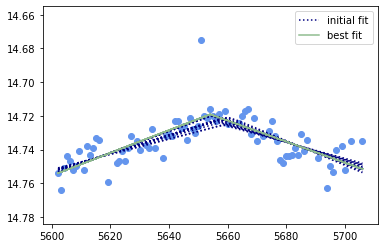

In [1024]:
#second flare: different splits
divcen2,divc2,divr2 = triangfit(1,mult=True,rs=np.arange(-10,10),chis=True)

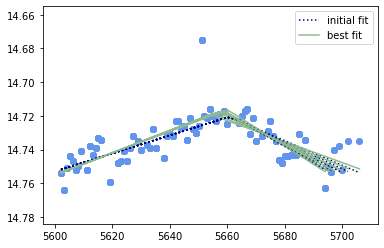

In [1025]:
#also checked start data -- stays at 5654
#cutting off points from right
endcen2,endc2,endr2 = triangfit(1,mult=True,off=True,rs=np.arange(0,10),chis=True)

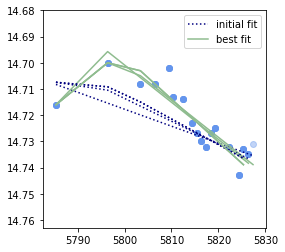

In [1026]:
#different numbers of final points
plt.figure(figsize=(4,4))
endcen3,endc3,endr3 = triangfit(2,mult=True,off=True,rs=np.arange(-1,2),chis=True) 


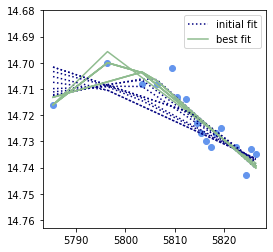

In [1027]:
#different split points
#generally getting rid of obviously wrong fits
plt.figure(figsize=(4,4))
divcen3,divc3,divr3 = triangfit(2,mult=True,rs=np.arange(-4,4),chis=True) 


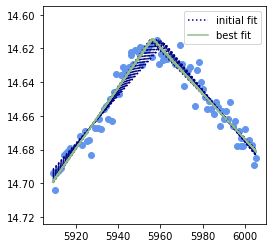

In [1028]:
#fourth flare
#location of split
plt.figure(figsize=(4,4))
divcen4,divc4,divr4 = triangfit(3,mult=True,rs=np.arange(-5,10),chis=True) 


4.704226109715819

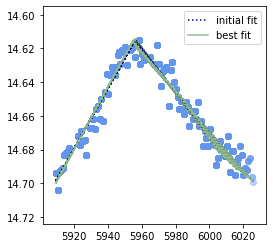

In [1030]:
#fourth flare different data inclusion
plt.figure(figsize=(4,4))
endcen4,endc4,endr4 = triangfit(3,mult=True,off=True,rs=np.arange(-20,20),chis=True) 

4.704226109715819


(14.72, 14.6)

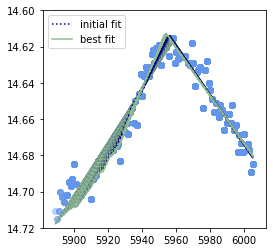

In [1035]:
#checking start of flare data changes
#fourth flare different data inclusion
plt.figure(figsize=(4,4))
stcen4,stc4,str4 = triangfit(3,mult=True,off=True,stcut=True,rs=np.arange(-20,20),chis=True) 

plt.ylim(14.72,14.6)

8.215112096969278


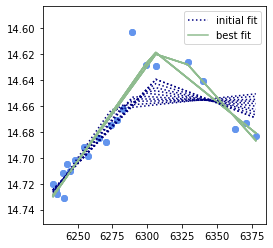

In [1036]:
#fifth flare split
plt.figure(figsize=(4,4))
divcen5,divc5,divr5 = triangfit(4,mult=True,rs=np.arange(-4,6),chis=True) 


8.215112096969278


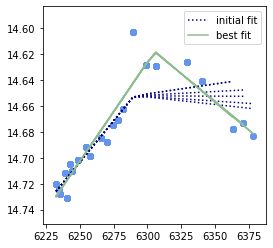

In [1038]:
#data inclusion; small for stcut if you don't add data
plt.figure(figsize=(4,4))
endcen5,endc5,endr5 = triangfit(4,mult=True,off=True,rs=np.arange(-1,4),chis=True) 
#lower than gaussian value

In [858]:
centers[4]

6318.039540660164

5.398833386388105
6636.693086680804 6634.3965154154575


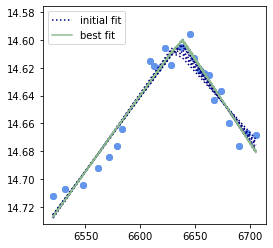

In [1034]:
#moving split
plt.figure(figsize=(4,4))
divcen6,divc6,divr6 = triangfit(5,mult=True,rs=np.arange(-5,5),chis=True) 
#lower than gaussian value

5.398833386388105
6636.693086680804 6634.3965154154575


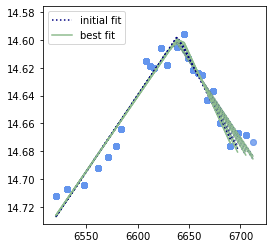

In [1039]:
plt.figure(figsize=(4,4))
endcen6,endc6,endr6 = triangfit(5,mult=True,off=True,rs=np.arange(-2,5),chis=True) 

5.398833386388105
6636.693086680804 6634.3965154154575


(14.74, 14.58)

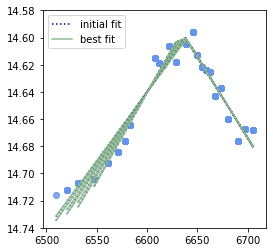

In [1040]:
plt.figure(figsize=(4,4))
stcen6,stc6,str6 = triangfit(5,mult=True,off=True,stcut=True,rs=np.arange(-2,5),chis=True) 
plt.ylim(14.74,14.58)

2.377419345510134
6996.372899077475 6988.810601929297


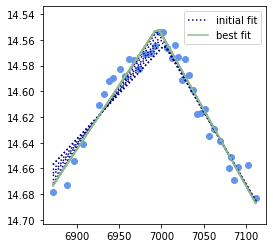

In [1041]:
plt.figure(figsize=(4,4))
divcen7,divc7,divr7 = triangfit(6,mult=True,rs=np.arange(-2,5),chis=True) 

2.377419345510134
6996.372899077475 6988.810601929297


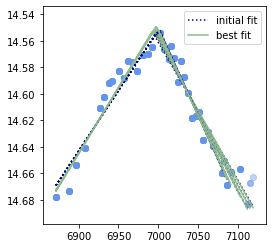

In [1042]:
plt.figure(figsize=(4,4))
endcen7,endc7,endr7 = triangfit(6,mult=True,off=True,rs=np.arange(-2,5),chis=True) 

2.377419345510134
6996.372899077475 6988.810601929297


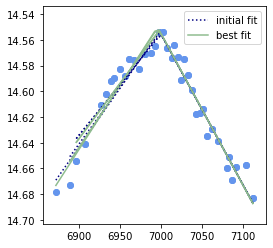

In [1043]:
plt.figure(figsize=(4,4))
stcen7,stc7,str7 = triangfit(6,mult=True,off=True,stcut=True,rs=np.arange(0,3),chis=True) 

9.304164571462934
7323.177498853615 7314.2010624509485


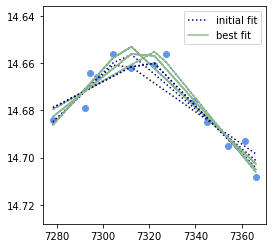

In [1044]:
plt.figure(figsize=(4,4))
divcen8,divc8,divr8 = triangfit(7,mult=True,rs=np.arange(-3,3),chis=True) 

9.304164571462934
7323.177498853615 7314.2010624509485


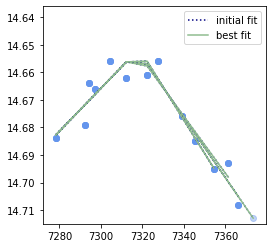

In [1045]:
plt.figure(figsize=(4,4))
endcen8,endc8,endr8 = triangfit(7,mult=True,off=True,rs=np.arange(-1,3),chis=True) 

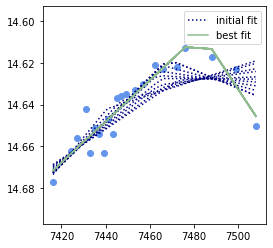

In [1046]:
plt.figure(figsize=(4,4))
divcen9,divc9,divr9 = triangfit(8,mult=True,rs=np.arange(-5,5),chis=True) 


20.753729359202225
7482.734475102729 7477.075631412105


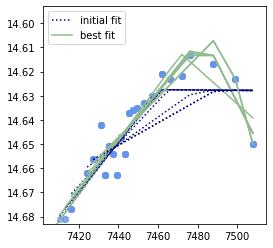

In [1047]:
plt.figure(figsize=(4,4))
stcen9,stc9,str9 = triangfit(8,mult=True,off=True,stcut=True,rs=np.arange(-3,3),chis=True) 

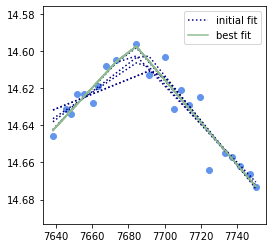

In [1048]:
plt.figure(figsize=(4,4))
divcen10,divc10,divr10 = triangfit(9,mult=True,rs=np.arange(-3,3),chis=True) 


0.9746912792761577
7683.09011231793 7682.40427137706


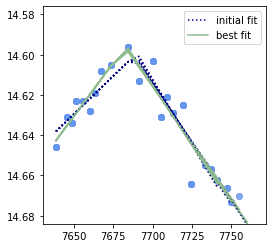

In [1049]:
plt.figure(figsize=(4,4))
endcen10,endc10,endr10 = triangfit(9,mult=True,off=True,rs=np.arange(-3,3),chis=True) 

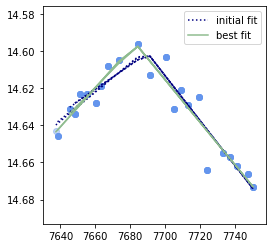

In [1050]:
plt.figure(figsize=(4,4))
stcen10,stc10,str10 = triangfit(9,mult=True,off=True,stcut=True,rs=np.arange(-1,3),chis=True) 


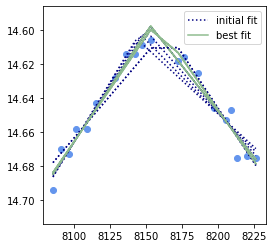

In [1051]:
plt.figure(figsize=(4,4))
divcen11,divc11,divr11 = triangfit(10,mult=True,rs=np.arange(-3,3),chis=True) 


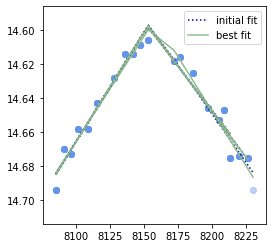

In [1052]:
plt.figure(figsize=(4,4))
endcen11,endc11,endr11 = triangfit(10,mult=True,off=True,rs=np.arange(-1,3),chis=True) 


(14.72, 14.59)

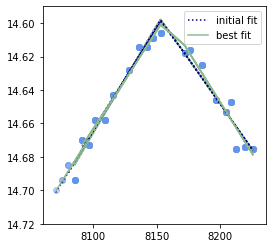

In [1053]:
plt.figure(figsize=(4,4))
stcen11,stc11,str11 = triangfit(10,mult=True,off=True,stcut=True,rs=np.arange(-3,3),chis=True) 
plt.ylim(14.72,14.59)

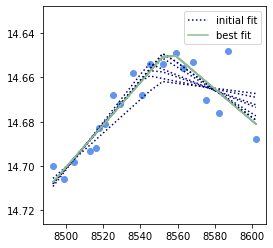

In [1054]:
plt.figure(figsize=(4,4))
divcen12,divc12,divr12 = triangfit(11,mult=True,rs=np.arange(-3,3),chis=True) 


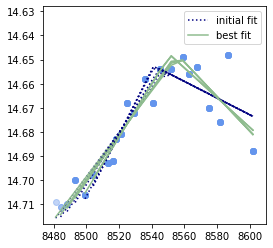

In [1055]:
plt.figure(figsize=(4,4))
stcen12,stc12,str12 = triangfit(11,mult=True,off=True,stcut=True,rs=np.arange(-3,3),chis=True) 

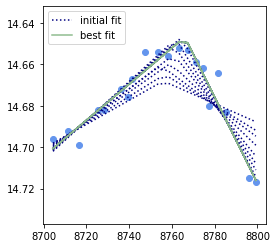

In [1069]:
#last flare!
plt.figure(figsize=(4,4))
divcen13,divc13,divr13 = triangfit(12,mult=True,rs=np.arange(-6,3),chis=True) 

(14.76, 14.64)

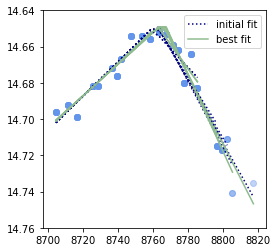

In [1058]:
plt.figure(figsize=(4,4))
endcen13,endc13,endr13 = triangfit(12,mult=True,off=True,rs=np.arange(-3,3),chis=True) 

plt.ylim(14.76,14.64)

2.7358158464667213
8764.97493650282 8753.881799131408


(14.74, 14.64)

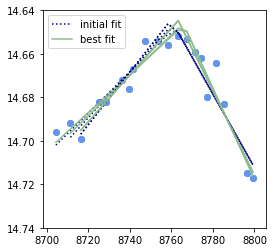

In [1059]:
plt.figure(figsize=(4,4))
stcen13,stc13,str13 = triangfit(12,mult=True,off=True,stcut=True,rs=np.arange(0,3),chis=True) 
print(np.max(f13)-np.min(f13)) #center changing by
print(np.mean(f13),centers[12])
plt.ylim(14.74,14.64)
#keep in mind -- never changed variables at same time

# Try Parameter Grid Searches
- tried one out for fun w/ plt.imshow
- **these variables are likely covariant so do more grids this weekend**
- be more exact (or automated) about  bounds

In [951]:
#example
pk13,chi13,rchi13 = triangfit(12,mult=True,off=True,stcut=True,rs=np.arange(0,3),plot=False,chis=True)

In [953]:
rchi13 #higher with fewer start points

[4.384162147138425, 4.435662060761789, 4.849466283272726]

In [1002]:
#don't use mult to get a grid; once this is working use own function
rchis = np.zeros((20,20))
pks = np.zeros((20,20))
#cutting of data from the start
for i in np.arange(-20,20,2):
    #moving split
    for j in np.arange(-20,20,2):
        pk,chi,rchi = triangfit(0,cut1=i,div=j,plot=False,chis=True)
        iind = int((20+i)/2.)
        jind = int((20+j)/2.)
        rchis[iind][jind] = rchi
        pks[iind][jind] = pk

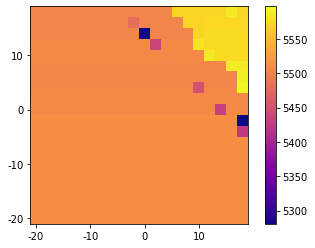

In [1019]:
plt.imshow(pks,origin='lower',cmap='plasma')
plt.yticks(np.arange(0,20,5),np.arange(-20,20,10))
plt.xticks(np.arange(0,20,5),np.arange(-20,20,10))
plt.colorbar()

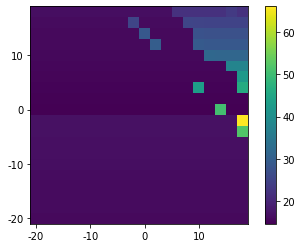

In [1018]:
plt.imshow(rchis,origin='lower')
plt.yticks(np.arange(0,20,5),np.arange(-20,20,10))
plt.xticks(np.arange(0,20,5),np.arange(-20,20,10))
plt.colorbar()

# Get Reasonable Values for Now
- can do more quanitifying, automation, etc. this weekend
- rerun to get peak values
- add a histogram or two to Overleaf
- upload to Github

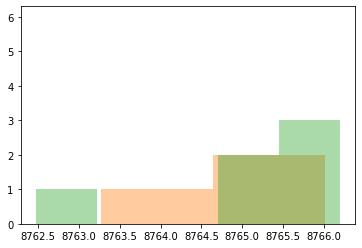

In [1070]:
#example of hist for (last) flare
#will be better to do 2D searches, but will leave this for now
sb.distplot(divcen13,kde=False)
sb.distplot(stcen13,kde=False)
sb.distplot(endcen13,kde=False)

Text(0, 0.5, 'Reduced Chi-Squared')

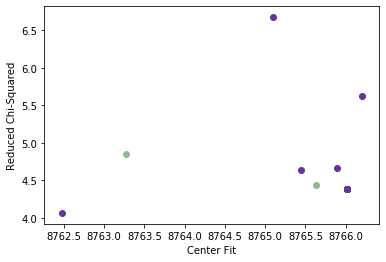

In [1075]:
#just trying to see if there's a trend between rchi and center fit
plt.scatter(divcen13,divr13,color='navy')
plt.scatter(stcen13,str13,color='darkseagreen')
plt.scatter(endcen13,endr13,color='rebeccapurple')
plt.xlabel('Center Fit')
plt.ylabel('Reduced Chi-Squared')

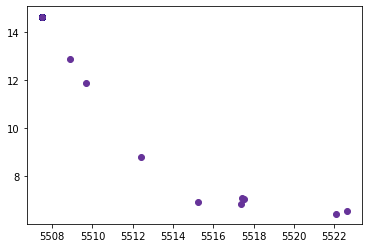

In [1077]:
#first flare
plt.scatter(divcen1,divr1,color='navy')
plt.scatter(endcen1,endr1,color='rebeccapurple')
#remember the centers increased with the number of points removed from the end, though

# Add to Hist With Other Methods

In [1081]:
#concatenate possible centers for each and then find difference from gaussian w/ no offset
#if it gets too crowded, just give mean for each
#add means to hist and then make separate with all deviations for each
divcen1,endcen1 = np.array(divcen1),np.array(endcen1)
tri1 = np.concatenate((divcen1,endcen1))

In [1090]:
#for now use the mean center from the different initial split
#worry about data inclusion later
meandivcens = [np.mean(divcen1),np.mean(divcen2),np.mean(divcen3),np.mean(divcen4),np.mean(divcen5),
              np.mean(divcen6),np.mean(divcen7),np.mean(divcen8),np.mean(divcen9),np.mean(divcen10),
              np.mean(divcen11),np.mean(divcen12),np.mean(divcen13)]
meandivcens = np.array(meandivcens)

Text(0, 0.5, '# Flares')

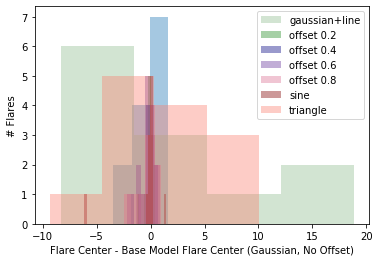

In [1093]:
import seaborn as sb
sb.distplot(det_no,kde=False)
sb.distplot(gl_no,color='darkseagreen',kde=False,label='gaussian+line')
sb.distplot(off_no2,color='forestgreen',kde=False,label='offset 0.2')
sb.distplot(off_no4,color='navy',kde=False,label='offset 0.4')
sb.distplot(off_no6,color='rebeccapurple',kde=False,label='offset 0.6')
sb.distplot(off_no8,color='palevioletred',kde=False,label='offset 0.8')
#sine model
sb.distplot(sincens - no_off,color='maroon',kde=False,label='sine')
#triangle
sb.distplot(meandivcens - no_off,color='salmon',kde=False,label='triangle')

plt.legend()
plt.xlabel('Flare Center - Base Model Flare Center (Gaussian, No Offset)')
plt.ylabel('# Flares')

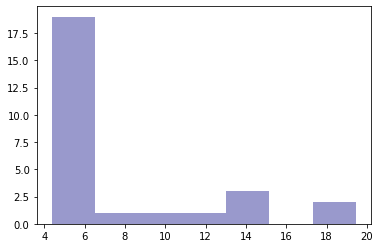

In [1086]:
#all centers found with triangles for first flare - gaussian center with no vertical offset
sb.distplot(tri1 - no_off[0],color='navy',kde=False,label='flare 1')


- not going to add anything more to Overleaf today
- reasonable bounds to grid (cutting out obvious extra data)
- 2D parameter searches since covariant
- scatterplots/histograms; especially one with all methods
- 13 flares fit with triangles (and Gaussians) in one plot; so need to start returning the fit as well
- triangles are good for individualizing the flares